Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16736524845288449350
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10071670784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14864898173651720553
physical_device_desc: "device: 0, name: TITAN Xp COLLECTORS EDITION, pci bus id: 0000:06:00.0, compute capability: 6.1"
]
Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8036, 7) 

       steering_angle     throttle        brake        speed
count     8036.000000  8036.000000  8036.000000  8036.000000
mean         0.004070     0.869660     0.001970    28.169839
std          0.128840     0.301326     0.036565     6.149327
min         -0.942695     0.000000     0.000000     0.502490
25%          0.000000     0.985533     0.000000    30.183093
50%          0.000000     0.985533     0.000000    30.186400
75%          0.000000     0.985533     0.000000    30.186640
max   

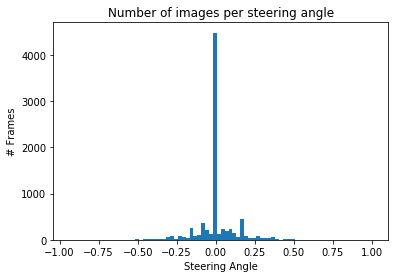

In [1]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json
import csv
import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

#from IPython.display import display # Allows the use of display() for DataFrames
# Visualizations will be shown in the notebook.
 
 # Get randomized datasets for training and validation
 
# shuffle data

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

 
lines=[]
 
with open('driving_log3.csv') as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)
images=[]
 
seed = 7
np.random.seed(seed)
 
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('driving_log3.csv', names=columns)
 
print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")
 
print("Data loaded...")
 
binwidth = 0.025
 
# histogram before image augmentation
plt.hist(data.steering_angle,bins=np.arange(min(data.steering_angle), max(data.steering_angle) + binwidth, binwidth))
plt.title('Number of images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Frames')
plt.show()
 
#images_center,images_left,images_right=[]


In [2]:
# Get randomized datasets for training and validation

# shuffle data
data = data.reindex(np.random.permutation(data.index))

num_train = int((len(data) / 10.) * 9.)

X_train = data.iloc[:num_train]
X_validation = data.iloc[num_train:]

print("X_train has {} elements.".format(len(X_train)))
print("X_valid has {} elements.".format(len(X_validation)))
#print("X_valid has {} elements.".format(X_train.center.iloc[53]))
#print("X_valid has {} elements.".format(data))

X_train has 7232 elements.
X_valid has 804 elements.


In [3]:
# model training variables
NB_EPOCH = 10
BATCH_SIZE = 32

## DATA AUGMENTATION

#### Mirror Image

IMG/center_2016_12_01_13_46_37_613.jpg
0.0
-0.0
shape in/out: (160, 320, 3) (160, 320, 3)


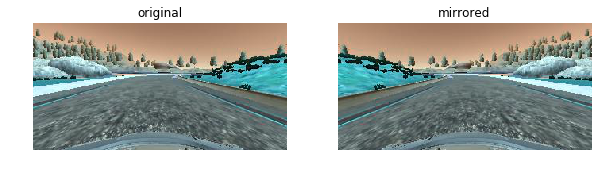

In [4]:
def mirrored(img, steering_angle):
    mirrored_image = cv2.flip(img, 1)
    steering_angle = -1 * steering_angle
    return mirrored_image, steering_angle

test_img =cv2.imread(data.center.iloc[53])
print(data.center.iloc[53])

steering_angle_test= data.steering_angle.iloc[53]

print(steering_angle_test)

translated_image, steering_angle_trans = mirrored(test_img,steering_angle_test)
print(steering_angle_trans)
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(translated_image.squeeze(), cmap='gray')
axs[1].set_title('mirrored')

print('shape in/out:', test_img.shape, translated_image.shape)

##### Random Brightness

IMG/center_2016_12_01_13_46_37_613.jpg
shape in/out: (160, 320, 3) (160, 320, 3)


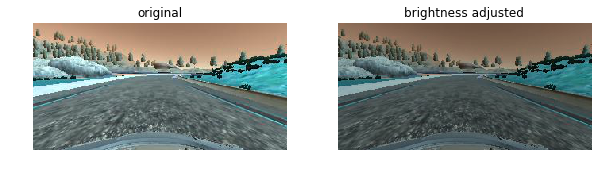

In [5]:
import cv2
def random_brightness(img, brightness=None):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if brightness:
        img[:,:,2] += brightness
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

test_img =cv2.imread(data.center.iloc[53])
print(data.center.iloc[53])

test_dst = random_brightness(test_img)


fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze())
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze())
axs[1].set_title('brightness adjusted')

print('shape in/out:', test_img.shape, test_dst.shape)

##### Cropping and resize

IMG/center_2016_12_01_13_46_37_613.jpg
shape in/out: (160, 320, 3) (64, 64, 3)


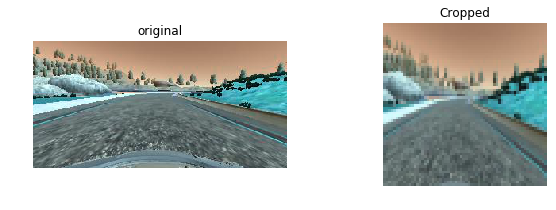

In [6]:
# crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood
def resize_image(img):
   
    shape = img.shape
    #img = img[math.floor(shape[0]/3):shape[0]-25, 0:shape[1]]
    img=img[0:140, 25:320]
    img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)    
    return img

test_img =cv2.imread(data.center.iloc[53])
print(data.center.iloc[53])
test_dst = resize_image(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze())
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze())
axs[1].set_title('Cropped')

print('shape in/out:', test_img.shape, test_dst.shape)

##### Random Translate

IMG/center_2016_12_01_13_46_37_613.jpg
0.0
-0.14505629449326285
shape in/out: (160, 320, 3) (160, 320, 3)


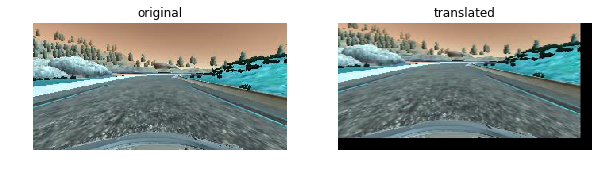

In [7]:
import cv2

def random_translate(img,steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = 100 * np.random.uniform() - 100 / 2
    ty = 40 * np.random.uniform() - 40 / 2
    steering_angle = steering_angle + tx / 40 * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

#test_img = X_train[103]
#steering_angle_test= Y_train[103]
test_img =cv2.imread(data.center.iloc[53])
print(data.center.iloc[53])

steering_angle_test= data.steering_angle.iloc[53]

print(steering_angle_test)

translated_image, steering_angle_trans = random_translate(test_img,steering_angle_test)
print(steering_angle_trans)
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(translated_image.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, translated_image.shape)

In [8]:
def apply_random_transformation(img, steering_angle):
    
    transformed_image, steering_angle = random_translate(img, steering_angle)
    transformed_image = random_brightness(transformed_image)
       
    if np.random.random() < 0.5:
        transformed_image, steering_angle = mirrored(transformed_image, steering_angle)
            
    #transformed_image = resize_image(transformed_image)
    
    return transformed_image, steering_angle

In [9]:
def load_and_augment_image(line_data):
    i = np.random.randint(3)
    
    if (i == 0):
        path_file = line_data['left'][0].strip()
        shift_angle = 0.25
    elif (i == 1):
        path_file = line_data['center'][0].strip()
        shift_angle = 0.
    elif (i == 2):
        path_file = line_data['right'][0].strip()
        shift_angle = -0.25
        
    steering_angle = line_data['steering_angle'][0] + shift_angle
    
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, steering_angle = apply_random_transformation(img, steering_angle)
    return img, steering_angle

In [10]:
# generators in multi-threaded applications is not thread-safe. Hence below:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()
        
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

In [11]:
import threading

### Keras generator ( to train more images without running into memory issue)

In [12]:
generated_steering_angles = []
threshold = 1

@threadsafe_generator
def generate_batch_data(_data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, 160, 320,3))
    batch_steering = np.zeros(batch_size)
    
    while 1:
        for batch_index in range(batch_size):
            row_index = np.random.randint(len(_data))
            line_data = _data.iloc[[row_index]].reset_index()
            
            # idea borrowed from Vivek Yadav: Sample images such that images with lower angles 
            # have lower probability of getting represented in the dataset. This alleviates 
            # any problems we may ecounter due to model having a bias towards driving straight.
            
            keep = 0
            while keep == 0:
                x, y = load_and_augment_image(line_data)
                if abs(y) < .1:
                    val = np.random.uniform()
                    if val > threshold:
                        keep = 1
                else:
                    keep = 1
            
            batch_images[batch_index] = x
            batch_steering[batch_index] = y
            generated_steering_angles.append(y)
        yield batch_images, batch_steering
        


## MODEL ARCHITECTURE
CNN architecture:
- crop image to eliminate hood and horizon
- Normalize data
- Use 4 convolution layers with batch normalization and activation ELU,
- 1 Flatten layer and 2 dense layer with activation ELU and using dropout to not overfit the network,
- learning rate 1e-4 instead of default 1e-3 for Adam optimzer

In [13]:
# from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda
from keras.layers import Cropping2D
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

# TODO: Build Convolutional Neural Network in Keras Here
model = Sequential()
model.add(Cropping2D(cropping=((75,25), (0,0)), input_shape=(160,320,3)))

model.add(Lambda(lambda x: x/127.5 - 1))

model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='Conv1'))

model.add(BatchNormalization())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv2'))

model.add(BatchNormalization())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv3'))

model.add(Flatten())

model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512, activation='elu', name='FC1'))

model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1, name='output'))

model.summary()

# compile
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=[])
#model.fit(X_train,Y_train, validation_split=0.2,shuffle=True,nb_epoch=5)
#model.save('modelnv2_0211.h5')

C:\Users\vikass\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), activation="elu", name="Conv1", strides=(4, 4), padding="same")`
  
C:\Users\vikass\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="elu", name="Conv2", strides=(2, 2), padding="same")`
C:\Users\vikass\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="elu", name="Conv3", strides=(2, 2), padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 60, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 60, 320, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 15, 80, 16)        3088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 16)        64        
_________________________________________________________________
Conv2 (Conv2D)               (None, 8, 40, 32)         12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 40, 32)         128       
_________________________________________________________________
Conv3 (Conv2D)               (None, 4, 20, 64)         51264     
__________

## TRAINING and VALIDATION

In [14]:

class LifecycleCallback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_train_end(self, logs={}):
        print('END TRAINING')
        
# Calculate the correct number of samples per epoch based on batch size
def calc_samples_per_epoch(array_size, batch_size):
    num_batches = array_size / batch_size
    samples_per_epoch = math.ceil(num_batches)
    samples_per_epoch = samples_per_epoch * batch_size
    return samples_per_epoch


In [15]:
lifecycle_callback = LifecycleCallback()       

train_generator = generate_batch_data(X_train, BATCH_SIZE)
validation_generator = generate_batch_data(X_validation, BATCH_SIZE)

samples_per_epoch = calc_samples_per_epoch((len(X_train)*3), BATCH_SIZE)
nb_val_samples = calc_samples_per_epoch((len(X_validation)*3), BATCH_SIZE)

history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              samples_per_epoch = samples_per_epoch, 
                              nb_val_samples = nb_val_samples,
                              nb_epoch = NB_EPOCH, verbose=1,
                              callbacks=[lifecycle_callback])


C:\Users\vikass\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\vikass\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., validation_data=<__main__...., verbose=1, callbacks=[<__main__..., steps_per_epoch=21696, epochs=10, validation_steps=2432)`
  


BEGIN TRAINING
Epoch 1/10


  303/21696 [..............................] - ETA: 17:04:16 - loss: 1.835 - ETA: 8:49:19 - loss: 1.514 - ETA: 6:04:27 - loss: 1.42 - ETA: 4:42:17 - loss: 1.51 - ETA: 3:52:59 - loss: 1.44 - ETA: 3:20:05 - loss: 1.34 - ETA: 2:56:29 - loss: 1.28 - ETA: 2:38:50 - loss: 1.22 - ETA: 2:25:07 - loss: 1.22 - ETA: 2:14:03 - loss: 1.21 - ETA: 2:05:00 - loss: 1.23 - ETA: 1:57:30 - loss: 1.23 - ETA: 1:51:12 - loss: 1.23 - ETA: 1:45:47 - loss: 1.23 - ETA: 1:41:01 - loss: 1.22 - ETA: 1:36:54 - loss: 1.20 - ETA: 1:33:17 - loss: 1.21 - ETA: 1:30:03 - loss: 1.19 - ETA: 1:27:11 - loss: 1.18 - ETA: 1:24:33 - loss: 1.15 - ETA: 1:22:12 - loss: 1.14 - ETA: 1:20:04 - loss: 1.12 - ETA: 1:18:06 - loss: 1.11 - ETA: 1:17:15 - loss: 1.09 - ETA: 1:16:16 - loss: 1.11 - ETA: 1:15:29 - loss: 1.11 - ETA: 1:15:03 - loss: 1.10 - ETA: 1:14:24 - loss: 1.13 - ETA: 1:13:54 - loss: 1.14 - ETA: 1:13:12 - loss: 1.13 - ETA: 1:12:54 - loss: 1.13 - ETA: 1:12:24 - loss: 1.11 - ETA: 1:11:56 - loss: 1.10 - ETA: 1:11:35 - loss: 1.10 

  617/21696 [..............................] - ETA: 56:13 - loss: 0.59 - ETA: 56:13 - loss: 0.59 - ETA: 56:11 - loss: 0.59 - ETA: 56:09 - loss: 0.59 - ETA: 56:08 - loss: 0.59 - ETA: 56:07 - loss: 0.58 - ETA: 56:04 - loss: 0.58 - ETA: 56:03 - loss: 0.58 - ETA: 56:04 - loss: 0.58 - ETA: 56:04 - loss: 0.58 - ETA: 56:06 - loss: 0.58 - ETA: 56:06 - loss: 0.58 - ETA: 56:07 - loss: 0.58 - ETA: 56:07 - loss: 0.58 - ETA: 56:06 - loss: 0.58 - ETA: 56:06 - loss: 0.58 - ETA: 56:06 - loss: 0.57 - ETA: 56:05 - loss: 0.57 - ETA: 56:04 - loss: 0.57 - ETA: 56:06 - loss: 0.57 - ETA: 56:08 - loss: 0.57 - ETA: 56:07 - loss: 0.57 - ETA: 56:05 - loss: 0.57 - ETA: 56:04 - loss: 0.57 - ETA: 56:04 - loss: 0.57 - ETA: 56:03 - loss: 0.57 - ETA: 56:02 - loss: 0.57 - ETA: 56:00 - loss: 0.56 - ETA: 56:00 - loss: 0.56 - ETA: 55:58 - loss: 0.56 - ETA: 55:57 - loss: 0.56 - ETA: 55:55 - loss: 0.56 - ETA: 55:51 - loss: 0.56 - ETA: 55:52 - loss: 0.56 - ETA: 55:51 - loss: 0.56 - ETA: 55:51 - loss: 0.56 - ETA: 55:50 - loss

  931/21696 [>.............................] - ETA: 53:55 - loss: 0.42 - ETA: 53:55 - loss: 0.42 - ETA: 53:55 - loss: 0.42 - ETA: 53:55 - loss: 0.42 - ETA: 53:55 - loss: 0.42 - ETA: 53:55 - loss: 0.42 - ETA: 53:54 - loss: 0.42 - ETA: 53:54 - loss: 0.42 - ETA: 53:54 - loss: 0.42 - ETA: 53:53 - loss: 0.42 - ETA: 53:53 - loss: 0.42 - ETA: 53:52 - loss: 0.42 - ETA: 53:52 - loss: 0.42 - ETA: 53:52 - loss: 0.42 - ETA: 53:51 - loss: 0.42 - ETA: 53:51 - loss: 0.42 - ETA: 53:52 - loss: 0.42 - ETA: 53:51 - loss: 0.42 - ETA: 53:52 - loss: 0.42 - ETA: 53:51 - loss: 0.42 - ETA: 53:50 - loss: 0.42 - ETA: 53:50 - loss: 0.42 - ETA: 53:50 - loss: 0.41 - ETA: 53:50 - loss: 0.41 - ETA: 53:50 - loss: 0.41 - ETA: 53:50 - loss: 0.41 - ETA: 53:51 - loss: 0.41 - ETA: 53:51 - loss: 0.41 - ETA: 53:52 - loss: 0.41 - ETA: 53:53 - loss: 0.41 - ETA: 53:53 - loss: 0.41 - ETA: 53:54 - loss: 0.41 - ETA: 53:54 - loss: 0.41 - ETA: 53:54 - loss: 0.41 - ETA: 53:55 - loss: 0.41 - ETA: 53:55 - loss: 0.41 - ETA: 53:55 - loss

 1245/21696 [>.............................] - ETA: 53:06 - loss: 0.34 - ETA: 53:06 - loss: 0.34 - ETA: 53:05 - loss: 0.34 - ETA: 53:06 - loss: 0.34 - ETA: 53:05 - loss: 0.34 - ETA: 53:05 - loss: 0.34 - ETA: 53:04 - loss: 0.34 - ETA: 53:04 - loss: 0.34 - ETA: 53:04 - loss: 0.34 - ETA: 53:04 - loss: 0.34 - ETA: 53:04 - loss: 0.34 - ETA: 53:03 - loss: 0.34 - ETA: 53:02 - loss: 0.34 - ETA: 53:01 - loss: 0.34 - ETA: 53:01 - loss: 0.34 - ETA: 53:00 - loss: 0.34 - ETA: 53:00 - loss: 0.34 - ETA: 52:59 - loss: 0.34 - ETA: 52:59 - loss: 0.34 - ETA: 52:58 - loss: 0.34 - ETA: 52:57 - loss: 0.34 - ETA: 52:57 - loss: 0.34 - ETA: 52:56 - loss: 0.34 - ETA: 52:55 - loss: 0.34 - ETA: 52:55 - loss: 0.34 - ETA: 52:54 - loss: 0.34 - ETA: 52:53 - loss: 0.34 - ETA: 52:53 - loss: 0.34 - ETA: 52:53 - loss: 0.34 - ETA: 52:52 - loss: 0.34 - ETA: 52:51 - loss: 0.34 - ETA: 52:50 - loss: 0.34 - ETA: 52:49 - loss: 0.34 - ETA: 52:49 - loss: 0.34 - ETA: 52:48 - loss: 0.34 - ETA: 52:48 - loss: 0.34 - ETA: 52:47 - loss

 1559/21696 [=>............................] - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:23 - loss: 0.30 - ETA: 52:22 - loss: 0.30 - ETA: 52:22 - loss: 0.29 - ETA: 52:22 - loss: 0.29 - ETA: 52:22 - loss: 0.29 - ETA: 52:22 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:21 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:20 - loss: 0.29 - ETA: 52:20 - loss

 1873/21696 [=>............................] - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:43 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss: 0.26 - ETA: 51:44 - loss

 2187/21696 [==>...........................] - ETA: 51:12 - loss: 0.24 - ETA: 51:12 - loss: 0.24 - ETA: 51:12 - loss: 0.24 - ETA: 51:12 - loss: 0.24 - ETA: 51:12 - loss: 0.24 - ETA: 51:12 - loss: 0.24 - ETA: 51:11 - loss: 0.24 - ETA: 51:11 - loss: 0.24 - ETA: 51:11 - loss: 0.24 - ETA: 51:11 - loss: 0.24 - ETA: 51:11 - loss: 0.24 - ETA: 51:11 - loss: 0.24 - ETA: 51:10 - loss: 0.24 - ETA: 51:10 - loss: 0.24 - ETA: 51:10 - loss: 0.24 - ETA: 51:10 - loss: 0.24 - ETA: 51:09 - loss: 0.24 - ETA: 51:09 - loss: 0.24 - ETA: 51:09 - loss: 0.24 - ETA: 51:08 - loss: 0.24 - ETA: 51:09 - loss: 0.24 - ETA: 51:08 - loss: 0.24 - ETA: 51:08 - loss: 0.24 - ETA: 51:08 - loss: 0.24 - ETA: 51:07 - loss: 0.24 - ETA: 51:07 - loss: 0.24 - ETA: 51:07 - loss: 0.24 - ETA: 51:07 - loss: 0.24 - ETA: 51:07 - loss: 0.24 - ETA: 51:07 - loss: 0.24 - ETA: 51:07 - loss: 0.23 - ETA: 51:07 - loss: 0.23 - ETA: 51:07 - loss: 0.23 - ETA: 51:06 - loss: 0.23 - ETA: 51:06 - loss: 0.23 - ETA: 51:06 - loss: 0.23 - ETA: 51:06 - loss

 2501/21696 [==>...........................] - ETA: 50:29 - loss: 0.22 - ETA: 50:29 - loss: 0.22 - ETA: 50:29 - loss: 0.22 - ETA: 50:29 - loss: 0.22 - ETA: 50:28 - loss: 0.22 - ETA: 50:28 - loss: 0.22 - ETA: 50:28 - loss: 0.22 - ETA: 50:28 - loss: 0.22 - ETA: 50:28 - loss: 0.22 - ETA: 50:27 - loss: 0.22 - ETA: 50:27 - loss: 0.22 - ETA: 50:27 - loss: 0.22 - ETA: 50:27 - loss: 0.22 - ETA: 50:27 - loss: 0.22 - ETA: 50:27 - loss: 0.22 - ETA: 50:26 - loss: 0.22 - ETA: 50:26 - loss: 0.22 - ETA: 50:26 - loss: 0.22 - ETA: 50:26 - loss: 0.22 - ETA: 50:25 - loss: 0.22 - ETA: 50:25 - loss: 0.22 - ETA: 50:25 - loss: 0.22 - ETA: 50:24 - loss: 0.22 - ETA: 50:24 - loss: 0.22 - ETA: 50:24 - loss: 0.22 - ETA: 50:24 - loss: 0.22 - ETA: 50:24 - loss: 0.22 - ETA: 50:24 - loss: 0.22 - ETA: 50:23 - loss: 0.22 - ETA: 50:23 - loss: 0.22 - ETA: 50:23 - loss: 0.22 - ETA: 50:23 - loss: 0.22 - ETA: 50:23 - loss: 0.22 - ETA: 50:22 - loss: 0.22 - ETA: 50:22 - loss: 0.22 - ETA: 50:22 - loss: 0.22 - ETA: 50:22 - loss

 2815/21696 [==>...........................] - ETA: 49:33 - loss: 0.20 - ETA: 49:33 - loss: 0.20 - ETA: 49:33 - loss: 0.20 - ETA: 49:33 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:32 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:31 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss: 0.20 - ETA: 49:30 - loss

 3129/21696 [===>..........................] - ETA: 48:39 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:37 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:38 - loss: 0.19 - ETA: 48:37 - loss: 0.19 - ETA: 48:37 - loss: 0.19 - ETA: 48:37 - loss: 0.19 - ETA: 48:37 - loss: 0.19 - ETA: 48:36 - loss: 0.19 - ETA: 48:36 - loss: 0.19 - ETA: 48:36 - loss: 0.19 - ETA: 48:36 - loss: 0.19 - ETA: 48:36 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:35 - loss: 0.19 - ETA: 48:34 - loss: 0.19 - ETA: 48:34 - loss: 0.19 - ETA: 48:34 - loss: 0.19 - ETA: 48:34 - loss: 0.19 - ETA: 48:34 - loss: 0.19 - ETA: 48:33 - loss: 0.19 - ETA: 48:33 - loss: 0.19 - ETA: 48:33 - loss: 0.19 - ETA: 48:33 - loss: 0.19 - ETA: 48:33 - loss: 0.19 - ETA: 48:32 - loss

 3443/21696 [===>..........................] - ETA: 47:48 - loss: 0.18 - ETA: 47:48 - loss: 0.18 - ETA: 47:48 - loss: 0.18 - ETA: 47:48 - loss: 0.18 - ETA: 47:47 - loss: 0.18 - ETA: 47:47 - loss: 0.18 - ETA: 47:47 - loss: 0.18 - ETA: 47:47 - loss: 0.18 - ETA: 47:46 - loss: 0.18 - ETA: 47:46 - loss: 0.18 - ETA: 47:46 - loss: 0.18 - ETA: 47:46 - loss: 0.18 - ETA: 47:46 - loss: 0.18 - ETA: 47:46 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:45 - loss: 0.18 - ETA: 47:44 - loss: 0.18 - ETA: 47:44 - loss: 0.18 - ETA: 47:44 - loss: 0.18 - ETA: 47:44 - loss: 0.18 - ETA: 47:44 - loss: 0.18 - ETA: 47:44 - loss: 0.18 - ETA: 47:43 - loss: 0.18 - ETA: 47:43 - loss: 0.18 - ETA: 47:43 - loss: 0.18 - ETA: 47:43 - loss: 0.18 - ETA: 47:43 - loss: 0.18 - ETA: 47:43 - loss: 0.18 - ETA: 47:42 - loss: 0.18 - ETA: 47:42 - loss: 0.18 - ETA: 47:42 - loss: 0.18 - ETA: 47:42 - loss

 3757/21696 [====>.........................] - ETA: 46:58 - loss: 0.17 - ETA: 46:58 - loss: 0.17 - ETA: 46:58 - loss: 0.17 - ETA: 46:58 - loss: 0.17 - ETA: 46:58 - loss: 0.17 - ETA: 46:58 - loss: 0.17 - ETA: 46:57 - loss: 0.17 - ETA: 46:57 - loss: 0.17 - ETA: 46:57 - loss: 0.17 - ETA: 46:57 - loss: 0.17 - ETA: 46:57 - loss: 0.17 - ETA: 46:56 - loss: 0.17 - ETA: 46:56 - loss: 0.17 - ETA: 46:56 - loss: 0.17 - ETA: 46:56 - loss: 0.17 - ETA: 46:56 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:55 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:54 - loss: 0.17 - ETA: 46:53 - loss: 0.17 - ETA: 46:53 - loss: 0.17 - ETA: 46:53 - loss: 0.17 - ETA: 46:53 - loss: 0.17 - ETA: 46:53 - loss

 4071/21696 [====>.........................] - ETA: 46:09 - loss: 0.16 - ETA: 46:09 - loss: 0.16 - ETA: 46:09 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:08 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:07 - loss: 0.16 - ETA: 46:06 - loss: 0.16 - ETA: 46:06 - loss: 0.16 - ETA: 46:06 - loss: 0.16 - ETA: 46:06 - loss: 0.16 - ETA: 46:06 - loss: 0.16 - ETA: 46:06 - loss: 0.16 - ETA: 46:05 - loss: 0.16 - ETA: 46:05 - loss: 0.16 - ETA: 46:05 - loss: 0.16 - ETA: 46:05 - loss: 0.16 - ETA: 46:05 - loss: 0.16 - ETA: 46:04 - loss: 0.16 - ETA: 46:04 - loss: 0.16 - ETA: 46:04 - loss: 0.16 - ETA: 46:04 - loss: 0.16 - ETA: 46:04 - loss: 0.16 - ETA: 46:04 - loss: 0.16 - ETA: 46:04 - loss

 4385/21696 [=====>........................] - ETA: 45:20 - loss: 0.16 - ETA: 45:20 - loss: 0.16 - ETA: 45:20 - loss: 0.16 - ETA: 45:20 - loss: 0.16 - ETA: 45:20 - loss: 0.16 - ETA: 45:20 - loss: 0.16 - ETA: 45:20 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:19 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:18 - loss: 0.16 - ETA: 45:17 - loss: 0.16 - ETA: 45:17 - loss: 0.16 - ETA: 45:17 - loss: 0.16 - ETA: 45:17 - loss: 0.16 - ETA: 45:17 - loss: 0.16 - ETA: 45:17 - loss: 0.16 - ETA: 45:16 - loss: 0.16 - ETA: 45:16 - loss: 0.16 - ETA: 45:16 - loss: 0.16 - ETA: 45:16 - loss: 0.16 - ETA: 45:16 - loss: 0.16 - ETA: 45:16 - loss: 0.16 - ETA: 45:16 - loss

 4699/21696 [=====>........................] - ETA: 44:31 - loss: 0.15 - ETA: 44:31 - loss: 0.15 - ETA: 44:31 - loss: 0.15 - ETA: 44:31 - loss: 0.15 - ETA: 44:31 - loss: 0.15 - ETA: 44:30 - loss: 0.15 - ETA: 44:30 - loss: 0.15 - ETA: 44:30 - loss: 0.15 - ETA: 44:30 - loss: 0.15 - ETA: 44:30 - loss: 0.15 - ETA: 44:30 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:29 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:28 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss: 0.15 - ETA: 44:27 - loss

 5013/21696 [=====>........................] - ETA: 43:48 - loss: 0.14 - ETA: 43:48 - loss: 0.14 - ETA: 43:48 - loss: 0.14 - ETA: 43:47 - loss: 0.14 - ETA: 43:47 - loss: 0.14 - ETA: 43:47 - loss: 0.14 - ETA: 43:47 - loss: 0.14 - ETA: 43:47 - loss: 0.14 - ETA: 43:47 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:46 - loss: 0.14 - ETA: 43:45 - loss: 0.14 - ETA: 43:45 - loss: 0.14 - ETA: 43:45 - loss: 0.14 - ETA: 43:45 - loss: 0.14 - ETA: 43:45 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:44 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:43 - loss: 0.14 - ETA: 43:42 - loss

 5327/21696 [======>.......................] - ETA: 43:01 - loss: 0.14 - ETA: 43:01 - loss: 0.14 - ETA: 43:01 - loss: 0.14 - ETA: 43:01 - loss: 0.14 - ETA: 43:00 - loss: 0.14 - ETA: 43:00 - loss: 0.14 - ETA: 43:00 - loss: 0.14 - ETA: 43:00 - loss: 0.14 - ETA: 43:00 - loss: 0.14 - ETA: 43:00 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:59 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:58 - loss: 0.14 - ETA: 42:57 - loss: 0.14 - ETA: 42:57 - loss: 0.14 - ETA: 42:57 - loss: 0.14 - ETA: 42:57 - loss: 0.14 - ETA: 42:57 - loss: 0.14 - ETA: 42:57 - loss: 0.14 - ETA: 42:56 - loss: 0.14 - ETA: 42:56 - loss: 0.14 - ETA: 42:56 - loss: 0.14 - ETA: 42:56 - loss: 0.14 - ETA: 42:56 - loss: 0.14 - ETA: 42:56 - loss

 5641/21696 [======>.......................] - ETA: 42:13 - loss: 0.13 - ETA: 42:13 - loss: 0.13 - ETA: 42:13 - loss: 0.13 - ETA: 42:12 - loss: 0.13 - ETA: 42:12 - loss: 0.13 - ETA: 42:12 - loss: 0.13 - ETA: 42:12 - loss: 0.13 - ETA: 42:12 - loss: 0.13 - ETA: 42:12 - loss: 0.13 - ETA: 42:11 - loss: 0.13 - ETA: 42:11 - loss: 0.13 - ETA: 42:11 - loss: 0.13 - ETA: 42:11 - loss: 0.13 - ETA: 42:11 - loss: 0.13 - ETA: 42:11 - loss: 0.13 - ETA: 42:10 - loss: 0.13 - ETA: 42:10 - loss: 0.13 - ETA: 42:10 - loss: 0.13 - ETA: 42:10 - loss: 0.13 - ETA: 42:10 - loss: 0.13 - ETA: 42:10 - loss: 0.13 - ETA: 42:09 - loss: 0.13 - ETA: 42:09 - loss: 0.13 - ETA: 42:09 - loss: 0.13 - ETA: 42:09 - loss: 0.13 - ETA: 42:09 - loss: 0.13 - ETA: 42:09 - loss: 0.13 - ETA: 42:08 - loss: 0.13 - ETA: 42:08 - loss: 0.13 - ETA: 42:08 - loss: 0.13 - ETA: 42:08 - loss: 0.13 - ETA: 42:08 - loss: 0.13 - ETA: 42:08 - loss: 0.13 - ETA: 42:07 - loss: 0.13 - ETA: 42:07 - loss: 0.13 - ETA: 42:07 - loss: 0.13 - ETA: 42:07 - loss

 5955/21696 [=======>......................] - ETA: 41:24 - loss: 0.13 - ETA: 41:24 - loss: 0.13 - ETA: 41:24 - loss: 0.13 - ETA: 41:24 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:23 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:22 - loss: 0.13 - ETA: 41:21 - loss: 0.13 - ETA: 41:21 - loss: 0.13 - ETA: 41:21 - loss: 0.13 - ETA: 41:21 - loss: 0.13 - ETA: 41:21 - loss: 0.13 - ETA: 41:21 - loss: 0.13 - ETA: 41:20 - loss: 0.13 - ETA: 41:20 - loss: 0.13 - ETA: 41:20 - loss: 0.13 - ETA: 41:20 - loss: 0.13 - ETA: 41:20 - loss: 0.13 - ETA: 41:20 - loss: 0.13 - ETA: 41:19 - loss: 0.13 - ETA: 41:19 - loss: 0.13 - ETA: 41:19 - loss: 0.13 - ETA: 41:19 - loss: 0.13 - ETA: 41:19 - loss: 0.13 - ETA: 41:19 - loss

 6269/21696 [=======>......................] - ETA: 40:33 - loss: 0.13 - ETA: 40:33 - loss: 0.13 - ETA: 40:33 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:32 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:31 - loss: 0.13 - ETA: 40:30 - loss: 0.13 - ETA: 40:30 - loss: 0.13 - ETA: 40:30 - loss: 0.13 - ETA: 40:30 - loss: 0.13 - ETA: 40:30 - loss: 0.13 - ETA: 40:30 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:29 - loss: 0.13 - ETA: 40:28 - loss: 0.13 - ETA: 40:28 - loss: 0.13 - ETA: 40:28 - loss: 0.13 - ETA: 40:28 - loss

 6583/21696 [========>.....................] - ETA: 39:44 - loss: 0.12 - ETA: 39:44 - loss: 0.12 - ETA: 39:44 - loss: 0.12 - ETA: 39:44 - loss: 0.12 - ETA: 39:44 - loss: 0.12 - ETA: 39:43 - loss: 0.12 - ETA: 39:43 - loss: 0.12 - ETA: 39:43 - loss: 0.12 - ETA: 39:43 - loss: 0.12 - ETA: 39:43 - loss: 0.12 - ETA: 39:43 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:42 - loss: 0.12 - ETA: 39:41 - loss: 0.12 - ETA: 39:41 - loss: 0.12 - ETA: 39:41 - loss: 0.12 - ETA: 39:41 - loss: 0.12 - ETA: 39:41 - loss: 0.12 - ETA: 39:41 - loss: 0.12 - ETA: 39:40 - loss: 0.12 - ETA: 39:40 - loss: 0.12 - ETA: 39:40 - loss: 0.12 - ETA: 39:40 - loss: 0.12 - ETA: 39:40 - loss: 0.12 - ETA: 39:40 - loss: 0.12 - ETA: 39:39 - loss: 0.12 - ETA: 39:39 - loss: 0.12 - ETA: 39:39 - loss: 0.12 - ETA: 39:39 - loss: 0.12 - ETA: 39:39 - loss: 0.12 - ETA: 39:39 - loss: 0.12 - ETA: 39:38 - loss

 6897/21696 [========>.....................] - ETA: 38:56 - loss: 0.12 - ETA: 38:56 - loss: 0.12 - ETA: 38:56 - loss: 0.12 - ETA: 38:56 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:55 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:54 - loss: 0.12 - ETA: 38:53 - loss: 0.12 - ETA: 38:53 - loss: 0.12 - ETA: 38:53 - loss: 0.12 - ETA: 38:53 - loss: 0.12 - ETA: 38:53 - loss: 0.12 - ETA: 38:53 - loss: 0.12 - ETA: 38:52 - loss: 0.12 - ETA: 38:52 - loss: 0.12 - ETA: 38:52 - loss: 0.12 - ETA: 38:52 - loss: 0.12 - ETA: 38:52 - loss: 0.12 - ETA: 38:52 - loss: 0.12 - ETA: 38:51 - loss: 0.12 - ETA: 38:51 - loss: 0.12 - ETA: 38:51 - loss: 0.12 - ETA: 38:51 - loss: 0.12 - ETA: 38:51 - loss: 0.12 - ETA: 38:51 - loss: 0.12 - ETA: 38:50 - loss

 7211/21696 [========>.....................] - ETA: 38:06 - loss: 0.12 - ETA: 38:06 - loss: 0.12 - ETA: 38:06 - loss: 0.12 - ETA: 38:06 - loss: 0.12 - ETA: 38:06 - loss: 0.12 - ETA: 38:06 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:05 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:04 - loss: 0.12 - ETA: 38:03 - loss: 0.12 - ETA: 38:03 - loss: 0.12 - ETA: 38:03 - loss: 0.12 - ETA: 38:03 - loss: 0.12 - ETA: 38:03 - loss: 0.12 - ETA: 38:02 - loss: 0.12 - ETA: 38:02 - loss: 0.12 - ETA: 38:02 - loss: 0.12 - ETA: 38:02 - loss: 0.12 - ETA: 38:02 - loss: 0.12 - ETA: 38:02 - loss: 0.12 - ETA: 38:01 - loss: 0.12 - ETA: 38:01 - loss: 0.12 - ETA: 38:01 - loss: 0.12 - ETA: 38:01 - loss: 0.12 - ETA: 38:01 - loss: 0.12 - ETA: 38:01 - loss

 7525/21696 [=========>....................] - ETA: 37:16 - loss: 0.11 - ETA: 37:16 - loss: 0.11 - ETA: 37:16 - loss: 0.11 - ETA: 37:16 - loss: 0.11 - ETA: 37:16 - loss: 0.11 - ETA: 37:16 - loss: 0.11 - ETA: 37:16 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:15 - loss: 0.11 - ETA: 37:14 - loss: 0.11 - ETA: 37:14 - loss: 0.11 - ETA: 37:14 - loss: 0.11 - ETA: 37:14 - loss: 0.11 - ETA: 37:14 - loss: 0.11 - ETA: 37:14 - loss: 0.11 - ETA: 37:13 - loss: 0.11 - ETA: 37:13 - loss: 0.11 - ETA: 37:13 - loss: 0.11 - ETA: 37:13 - loss: 0.11 - ETA: 37:13 - loss: 0.11 - ETA: 37:13 - loss: 0.11 - ETA: 37:12 - loss: 0.11 - ETA: 37:12 - loss: 0.11 - ETA: 37:12 - loss: 0.11 - ETA: 37:12 - loss: 0.11 - ETA: 37:12 - loss: 0.11 - ETA: 37:12 - loss: 0.11 - ETA: 37:11 - loss: 0.11 - ETA: 37:11 - loss: 0.11 - ETA: 37:11 - loss: 0.11 - ETA: 37:11 - loss: 0.11 - ETA: 37:11 - loss

 7839/21696 [=========>....................] - ETA: 36:28 - loss: 0.11 - ETA: 36:28 - loss: 0.11 - ETA: 36:28 - loss: 0.11 - ETA: 36:28 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:27 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:26 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:25 - loss: 0.11 - ETA: 36:24 - loss: 0.11 - ETA: 36:24 - loss: 0.11 - ETA: 36:24 - loss: 0.11 - ETA: 36:24 - loss: 0.11 - ETA: 36:24 - loss

 8153/21696 [==========>...................] - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:45 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:44 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:43 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:42 - loss: 0.11 - ETA: 35:41 - loss: 0.11 - ETA: 35:41 - loss: 0.11 - ETA: 35:41 - loss

 8467/21696 [==========>...................] - ETA: 35:01 - loss: 0.11 - ETA: 35:01 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 35:00 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:59 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:58 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:57 - loss: 0.11 - ETA: 34:56 - loss: 0.11 - ETA: 34:56 - loss: 0.11 - ETA: 34:56 - loss: 0.11 - ETA: 34:56 - loss: 0.11 - ETA: 34:56 - loss: 0.11 - ETA: 34:56 - loss

 8781/21696 [===========>..................] - ETA: 34:14 - loss: 0.10 - ETA: 34:14 - loss: 0.10 - ETA: 34:14 - loss: 0.10 - ETA: 34:14 - loss: 0.10 - ETA: 34:14 - loss: 0.10 - ETA: 34:14 - loss: 0.10 - ETA: 34:13 - loss: 0.10 - ETA: 34:13 - loss: 0.10 - ETA: 34:13 - loss: 0.10 - ETA: 34:13 - loss: 0.10 - ETA: 34:13 - loss: 0.10 - ETA: 34:13 - loss: 0.10 - ETA: 34:12 - loss: 0.10 - ETA: 34:12 - loss: 0.10 - ETA: 34:12 - loss: 0.10 - ETA: 34:12 - loss: 0.10 - ETA: 34:12 - loss: 0.10 - ETA: 34:12 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:11 - loss: 0.10 - ETA: 34:10 - loss: 0.10 - ETA: 34:10 - loss: 0.10 - ETA: 34:10 - loss: 0.10 - ETA: 34:10 - loss: 0.10 - ETA: 34:10 - loss: 0.10 - ETA: 34:10 - loss: 0.10 - ETA: 34:09 - loss: 0.10 - ETA: 34:09 - loss: 0.10 - ETA: 34:09 - loss: 0.10 - ETA: 34:09 - loss: 0.10 - ETA: 34:09 - loss

 9095/21696 [===========>..................] - ETA: 33:26 - loss: 0.10 - ETA: 33:26 - loss: 0.10 - ETA: 33:26 - loss: 0.10 - ETA: 33:26 - loss: 0.10 - ETA: 33:26 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:25 - loss: 0.10 - ETA: 33:24 - loss: 0.10 - ETA: 33:24 - loss: 0.10 - ETA: 33:24 - loss: 0.10 - ETA: 33:24 - loss: 0.10 - ETA: 33:24 - loss: 0.10 - ETA: 33:24 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:23 - loss: 0.10 - ETA: 33:22 - loss: 0.10 - ETA: 33:22 - loss: 0.10 - ETA: 33:22 - loss: 0.10 - ETA: 33:22 - loss: 0.10 - ETA: 33:22 - loss: 0.10 - ETA: 33:22 - loss: 0.10 - ETA: 33:21 - loss: 0.10 - ETA: 33:21 - loss: 0.10 - ETA: 33:21 - loss: 0.10 - ETA: 33:21 - loss: 0.10 - ETA: 33:21 - loss

 9409/21696 [============>.................] - ETA: 32:37 - loss: 0.10 - ETA: 32:37 - loss: 0.10 - ETA: 32:37 - loss: 0.10 - ETA: 32:37 - loss: 0.10 - ETA: 32:37 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:36 - loss: 0.10 - ETA: 32:35 - loss: 0.10 - ETA: 32:35 - loss: 0.10 - ETA: 32:35 - loss: 0.10 - ETA: 32:35 - loss: 0.10 - ETA: 32:35 - loss: 0.10 - ETA: 32:35 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:34 - loss: 0.10 - ETA: 32:33 - loss: 0.10 - ETA: 32:33 - loss: 0.10 - ETA: 32:33 - loss: 0.10 - ETA: 32:33 - loss: 0.10 - ETA: 32:33 - loss: 0.10 - ETA: 32:33 - loss: 0.10 - ETA: 32:32 - loss: 0.10 - ETA: 32:32 - loss: 0.10 - ETA: 32:32 - loss: 0.10 - ETA: 32:32 - loss: 0.10 - ETA: 32:32 - loss: 0.10 - ETA: 32:32 - loss

 9723/21696 [============>.................] - ETA: 31:46 - loss: 0.10 - ETA: 31:46 - loss: 0.10 - ETA: 31:46 - loss: 0.10 - ETA: 31:46 - loss: 0.10 - ETA: 31:46 - loss: 0.10 - ETA: 31:46 - loss: 0.10 - ETA: 31:45 - loss: 0.10 - ETA: 31:45 - loss: 0.10 - ETA: 31:45 - loss: 0.10 - ETA: 31:45 - loss: 0.10 - ETA: 31:45 - loss: 0.10 - ETA: 31:45 - loss: 0.10 - ETA: 31:44 - loss: 0.10 - ETA: 31:44 - loss: 0.10 - ETA: 31:44 - loss: 0.10 - ETA: 31:44 - loss: 0.10 - ETA: 31:44 - loss: 0.10 - ETA: 31:44 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:43 - loss: 0.10 - ETA: 31:42 - loss: 0.10 - ETA: 31:42 - loss: 0.10 - ETA: 31:42 - loss: 0.10 - ETA: 31:42 - loss: 0.10 - ETA: 31:42 - loss: 0.10 - ETA: 31:41 - loss: 0.10 - ETA: 31:41 - loss: 0.10 - ETA: 31:41 - loss: 0.10 - ETA: 31:41 - loss: 0.10 - ETA: 31:41 - loss: 0.10 - ETA: 31:41 - loss: 0.10 - ETA: 31:40 - loss

10037/21696 [============>.................] - ETA: 30:55 - loss: 0.10 - ETA: 30:55 - loss: 0.10 - ETA: 30:54 - loss: 0.10 - ETA: 30:54 - loss: 0.10 - ETA: 30:54 - loss: 0.10 - ETA: 30:54 - loss: 0.10 - ETA: 30:54 - loss: 0.10 - ETA: 30:54 - loss: 0.10 - ETA: 30:53 - loss: 0.10 - ETA: 30:53 - loss: 0.10 - ETA: 30:53 - loss: 0.10 - ETA: 30:53 - loss: 0.10 - ETA: 30:53 - loss: 0.10 - ETA: 30:53 - loss: 0.10 - ETA: 30:52 - loss: 0.10 - ETA: 30:52 - loss: 0.10 - ETA: 30:52 - loss: 0.10 - ETA: 30:52 - loss: 0.10 - ETA: 30:52 - loss: 0.10 - ETA: 30:52 - loss: 0.10 - ETA: 30:51 - loss: 0.10 - ETA: 30:51 - loss: 0.10 - ETA: 30:51 - loss: 0.10 - ETA: 30:51 - loss: 0.10 - ETA: 30:51 - loss: 0.10 - ETA: 30:51 - loss: 0.10 - ETA: 30:50 - loss: 0.10 - ETA: 30:50 - loss: 0.10 - ETA: 30:50 - loss: 0.10 - ETA: 30:50 - loss: 0.10 - ETA: 30:50 - loss: 0.10 - ETA: 30:50 - loss: 0.10 - ETA: 30:49 - loss: 0.10 - ETA: 30:49 - loss: 0.10 - ETA: 30:49 - loss: 0.10 - ETA: 30:49 - loss: 0.10 - ETA: 30:49 - loss

10351/21696 [=============>................] - ETA: 30:03 - loss: 0.10 - ETA: 30:03 - loss: 0.10 - ETA: 30:03 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:02 - loss: 0.10 - ETA: 30:01 - loss: 0.10 - ETA: 30:01 - loss: 0.10 - ETA: 30:01 - loss: 0.10 - ETA: 30:01 - loss: 0.10 - ETA: 30:01 - loss: 0.10 - ETA: 30:01 - loss: 0.10 - ETA: 30:00 - loss: 0.10 - ETA: 30:00 - loss: 0.10 - ETA: 30:00 - loss: 0.09 - ETA: 30:00 - loss: 0.09 - ETA: 30:00 - loss: 0.09 - ETA: 29:59 - loss: 0.09 - ETA: 29:59 - loss: 0.09 - ETA: 29:59 - loss: 0.09 - ETA: 29:59 - loss: 0.09 - ETA: 29:59 - loss: 0.09 - ETA: 29:59 - loss: 0.09 - ETA: 29:58 - loss: 0.09 - ETA: 29:58 - loss: 0.09 - ETA: 29:58 - loss: 0.09 - ETA: 29:58 - loss: 0.09 - ETA: 29:58 - loss: 0.09 - ETA: 29:58 - loss: 0.09 - ETA: 29:57 - loss: 0.09 - ETA: 29:57 - loss: 0.09 - ETA: 29:57 - loss: 0.09 - ETA: 29:57 - loss

10665/21696 [=============>................] - ETA: 29:10 - loss: 0.09 - ETA: 29:10 - loss: 0.09 - ETA: 29:10 - loss: 0.09 - ETA: 29:10 - loss: 0.09 - ETA: 29:10 - loss: 0.09 - ETA: 29:09 - loss: 0.09 - ETA: 29:09 - loss: 0.09 - ETA: 29:09 - loss: 0.09 - ETA: 29:09 - loss: 0.09 - ETA: 29:09 - loss: 0.09 - ETA: 29:09 - loss: 0.09 - ETA: 29:08 - loss: 0.09 - ETA: 29:08 - loss: 0.09 - ETA: 29:08 - loss: 0.09 - ETA: 29:08 - loss: 0.09 - ETA: 29:08 - loss: 0.09 - ETA: 29:08 - loss: 0.09 - ETA: 29:07 - loss: 0.09 - ETA: 29:07 - loss: 0.09 - ETA: 29:07 - loss: 0.09 - ETA: 29:07 - loss: 0.09 - ETA: 29:07 - loss: 0.09 - ETA: 29:07 - loss: 0.09 - ETA: 29:06 - loss: 0.09 - ETA: 29:06 - loss: 0.09 - ETA: 29:06 - loss: 0.09 - ETA: 29:06 - loss: 0.09 - ETA: 29:06 - loss: 0.09 - ETA: 29:06 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:05 - loss: 0.09 - ETA: 29:04 - loss

10979/21696 [==============>...............] - ETA: 28:19 - loss: 0.09 - ETA: 28:19 - loss: 0.09 - ETA: 28:19 - loss: 0.09 - ETA: 28:19 - loss: 0.09 - ETA: 28:19 - loss: 0.09 - ETA: 28:19 - loss: 0.09 - ETA: 28:18 - loss: 0.09 - ETA: 28:18 - loss: 0.09 - ETA: 28:18 - loss: 0.09 - ETA: 28:18 - loss: 0.09 - ETA: 28:18 - loss: 0.09 - ETA: 28:18 - loss: 0.09 - ETA: 28:17 - loss: 0.09 - ETA: 28:17 - loss: 0.09 - ETA: 28:17 - loss: 0.09 - ETA: 28:17 - loss: 0.09 - ETA: 28:17 - loss: 0.09 - ETA: 28:17 - loss: 0.09 - ETA: 28:16 - loss: 0.09 - ETA: 28:16 - loss: 0.09 - ETA: 28:16 - loss: 0.09 - ETA: 28:16 - loss: 0.09 - ETA: 28:16 - loss: 0.09 - ETA: 28:16 - loss: 0.09 - ETA: 28:15 - loss: 0.09 - ETA: 28:15 - loss: 0.09 - ETA: 28:15 - loss: 0.09 - ETA: 28:15 - loss: 0.09 - ETA: 28:15 - loss: 0.09 - ETA: 28:15 - loss: 0.09 - ETA: 28:14 - loss: 0.09 - ETA: 28:14 - loss: 0.09 - ETA: 28:14 - loss: 0.09 - ETA: 28:14 - loss: 0.09 - ETA: 28:14 - loss: 0.09 - ETA: 28:14 - loss: 0.09 - ETA: 28:13 - loss

11293/21696 [==============>...............] - ETA: 27:27 - loss: 0.09 - ETA: 27:27 - loss: 0.09 - ETA: 27:27 - loss: 0.09 - ETA: 27:27 - loss: 0.09 - ETA: 27:27 - loss: 0.09 - ETA: 27:27 - loss: 0.09 - ETA: 27:27 - loss: 0.09 - ETA: 27:26 - loss: 0.09 - ETA: 27:26 - loss: 0.09 - ETA: 27:26 - loss: 0.09 - ETA: 27:26 - loss: 0.09 - ETA: 27:26 - loss: 0.09 - ETA: 27:26 - loss: 0.09 - ETA: 27:25 - loss: 0.09 - ETA: 27:25 - loss: 0.09 - ETA: 27:25 - loss: 0.09 - ETA: 27:25 - loss: 0.09 - ETA: 27:25 - loss: 0.09 - ETA: 27:25 - loss: 0.09 - ETA: 27:24 - loss: 0.09 - ETA: 27:24 - loss: 0.09 - ETA: 27:24 - loss: 0.09 - ETA: 27:24 - loss: 0.09 - ETA: 27:24 - loss: 0.09 - ETA: 27:24 - loss: 0.09 - ETA: 27:23 - loss: 0.09 - ETA: 27:23 - loss: 0.09 - ETA: 27:23 - loss: 0.09 - ETA: 27:23 - loss: 0.09 - ETA: 27:23 - loss: 0.09 - ETA: 27:23 - loss: 0.09 - ETA: 27:22 - loss: 0.09 - ETA: 27:22 - loss: 0.09 - ETA: 27:22 - loss: 0.09 - ETA: 27:22 - loss: 0.09 - ETA: 27:22 - loss: 0.09 - ETA: 27:22 - loss

11607/21696 [===============>..............] - ETA: 26:37 - loss: 0.09 - ETA: 26:37 - loss: 0.09 - ETA: 26:37 - loss: 0.09 - ETA: 26:37 - loss: 0.09 - ETA: 26:37 - loss: 0.09 - ETA: 26:36 - loss: 0.09 - ETA: 26:36 - loss: 0.09 - ETA: 26:36 - loss: 0.09 - ETA: 26:36 - loss: 0.09 - ETA: 26:36 - loss: 0.09 - ETA: 26:36 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:35 - loss: 0.09 - ETA: 26:34 - loss: 0.09 - ETA: 26:34 - loss: 0.09 - ETA: 26:34 - loss: 0.09 - ETA: 26:34 - loss: 0.09 - ETA: 26:34 - loss: 0.09 - ETA: 26:34 - loss: 0.09 - ETA: 26:33 - loss: 0.09 - ETA: 26:33 - loss: 0.09 - ETA: 26:33 - loss: 0.09 - ETA: 26:33 - loss: 0.09 - ETA: 26:33 - loss: 0.09 - ETA: 26:33 - loss: 0.09 - ETA: 26:32 - loss: 0.09 - ETA: 26:32 - loss: 0.09 - ETA: 26:32 - loss: 0.09 - ETA: 26:32 - loss: 0.09 - ETA: 26:32 - loss: 0.09 - ETA: 26:32 - loss: 0.09 - ETA: 26:31 - loss

11921/21696 [===============>..............] - ETA: 25:46 - loss: 0.09 - ETA: 25:46 - loss: 0.09 - ETA: 25:46 - loss: 0.09 - ETA: 25:45 - loss: 0.09 - ETA: 25:45 - loss: 0.09 - ETA: 25:45 - loss: 0.09 - ETA: 25:45 - loss: 0.09 - ETA: 25:45 - loss: 0.09 - ETA: 25:45 - loss: 0.09 - ETA: 25:44 - loss: 0.09 - ETA: 25:44 - loss: 0.09 - ETA: 25:44 - loss: 0.09 - ETA: 25:44 - loss: 0.09 - ETA: 25:44 - loss: 0.09 - ETA: 25:44 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:43 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:42 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:41 - loss: 0.09 - ETA: 25:40 - loss

12235/21696 [===============>..............] - ETA: 24:57 - loss: 0.09 - ETA: 24:56 - loss: 0.09 - ETA: 24:56 - loss: 0.09 - ETA: 24:56 - loss: 0.09 - ETA: 24:56 - loss: 0.09 - ETA: 24:56 - loss: 0.09 - ETA: 24:56 - loss: 0.09 - ETA: 24:55 - loss: 0.09 - ETA: 24:55 - loss: 0.09 - ETA: 24:55 - loss: 0.09 - ETA: 24:55 - loss: 0.09 - ETA: 24:55 - loss: 0.09 - ETA: 24:55 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:54 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:53 - loss: 0.09 - ETA: 24:52 - loss: 0.09 - ETA: 24:52 - loss: 0.09 - ETA: 24:52 - loss: 0.09 - ETA: 24:52 - loss: 0.09 - ETA: 24:52 - loss: 0.09 - ETA: 24:52 - loss: 0.09 - ETA: 24:51 - loss: 0.09 - ETA: 24:51 - loss: 0.09 - ETA: 24:51 - loss: 0.09 - ETA: 24:51 - loss

12549/21696 [================>.............] - ETA: 24:07 - loss: 0.09 - ETA: 24:06 - loss: 0.09 - ETA: 24:06 - loss: 0.09 - ETA: 24:06 - loss: 0.09 - ETA: 24:06 - loss: 0.09 - ETA: 24:06 - loss: 0.09 - ETA: 24:06 - loss: 0.09 - ETA: 24:05 - loss: 0.09 - ETA: 24:05 - loss: 0.09 - ETA: 24:05 - loss: 0.09 - ETA: 24:05 - loss: 0.09 - ETA: 24:05 - loss: 0.09 - ETA: 24:05 - loss: 0.09 - ETA: 24:04 - loss: 0.09 - ETA: 24:04 - loss: 0.09 - ETA: 24:04 - loss: 0.09 - ETA: 24:04 - loss: 0.09 - ETA: 24:04 - loss: 0.09 - ETA: 24:04 - loss: 0.09 - ETA: 24:03 - loss: 0.09 - ETA: 24:03 - loss: 0.09 - ETA: 24:03 - loss: 0.09 - ETA: 24:03 - loss: 0.09 - ETA: 24:03 - loss: 0.09 - ETA: 24:03 - loss: 0.09 - ETA: 24:02 - loss: 0.09 - ETA: 24:02 - loss: 0.09 - ETA: 24:02 - loss: 0.09 - ETA: 24:02 - loss: 0.09 - ETA: 24:02 - loss: 0.09 - ETA: 24:02 - loss: 0.09 - ETA: 24:01 - loss: 0.09 - ETA: 24:01 - loss: 0.09 - ETA: 24:01 - loss: 0.09 - ETA: 24:01 - loss: 0.09 - ETA: 24:01 - loss: 0.09 - ETA: 24:01 - loss

12863/21696 [================>.............] - ETA: 23:16 - loss: 0.09 - ETA: 23:16 - loss: 0.09 - ETA: 23:15 - loss: 0.09 - ETA: 23:15 - loss: 0.09 - ETA: 23:15 - loss: 0.09 - ETA: 23:15 - loss: 0.09 - ETA: 23:15 - loss: 0.09 - ETA: 23:15 - loss: 0.09 - ETA: 23:14 - loss: 0.09 - ETA: 23:14 - loss: 0.09 - ETA: 23:14 - loss: 0.09 - ETA: 23:14 - loss: 0.09 - ETA: 23:14 - loss: 0.09 - ETA: 23:14 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:13 - loss: 0.09 - ETA: 23:12 - loss: 0.09 - ETA: 23:12 - loss: 0.09 - ETA: 23:12 - loss: 0.09 - ETA: 23:12 - loss: 0.09 - ETA: 23:12 - loss: 0.09 - ETA: 23:12 - loss: 0.09 - ETA: 23:11 - loss: 0.09 - ETA: 23:11 - loss: 0.09 - ETA: 23:11 - loss: 0.09 - ETA: 23:11 - loss: 0.09 - ETA: 23:11 - loss: 0.09 - ETA: 23:11 - loss: 0.09 - ETA: 23:10 - loss: 0.09 - ETA: 23:10 - loss: 0.09 - ETA: 23:10 - loss: 0.09 - ETA: 23:10 - loss

13177/21696 [=================>............] - ETA: 22:24 - loss: 0.09 - ETA: 22:24 - loss: 0.09 - ETA: 22:24 - loss: 0.09 - ETA: 22:24 - loss: 0.09 - ETA: 22:24 - loss: 0.09 - ETA: 22:24 - loss: 0.09 - ETA: 22:24 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:23 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:22 - loss: 0.09 - ETA: 22:21 - loss: 0.09 - ETA: 22:21 - loss: 0.09 - ETA: 22:21 - loss: 0.09 - ETA: 22:21 - loss: 0.09 - ETA: 22:21 - loss: 0.09 - ETA: 22:21 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:20 - loss: 0.09 - ETA: 22:19 - loss: 0.09 - ETA: 22:19 - loss: 0.09 - ETA: 22:19 - loss

13491/21696 [=================>............] - ETA: 21:37 - loss: 0.09 - ETA: 21:37 - loss: 0.09 - ETA: 21:37 - loss: 0.09 - ETA: 21:37 - loss: 0.09 - ETA: 21:37 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:36 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:35 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:34 - loss: 0.09 - ETA: 21:33 - loss: 0.09 - ETA: 21:33 - loss: 0.09 - ETA: 21:33 - loss: 0.09 - ETA: 21:33 - loss: 0.09 - ETA: 21:33 - loss: 0.09 - ETA: 21:33 - loss: 0.09 - ETA: 21:32 - loss: 0.09 - ETA: 21:32 - loss: 0.09 - ETA: 21:32 - loss: 0.09 - ETA: 21:32 - loss: 0.09 - ETA: 21:32 - loss

13805/21696 [==================>...........] - ETA: 20:49 - loss: 0.08 - ETA: 20:49 - loss: 0.08 - ETA: 20:49 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:48 - loss: 0.08 - ETA: 20:47 - loss: 0.08 - ETA: 20:47 - loss: 0.08 - ETA: 20:47 - loss: 0.08 - ETA: 20:47 - loss: 0.08 - ETA: 20:47 - loss: 0.08 - ETA: 20:47 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:46 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:45 - loss: 0.08 - ETA: 20:44 - loss: 0.08 - ETA: 20:44 - loss: 0.08 - ETA: 20:44 - loss: 0.08 - ETA: 20:44 - loss: 0.08 - ETA: 20:44 - loss: 0.08 - ETA: 20:44 - loss: 0.08 - ETA: 20:43 - loss

14119/21696 [==================>...........] - ETA: 20:01 - loss: 0.08 - ETA: 20:00 - loss: 0.08 - ETA: 20:00 - loss: 0.08 - ETA: 20:00 - loss: 0.08 - ETA: 20:00 - loss: 0.08 - ETA: 20:00 - loss: 0.08 - ETA: 20:00 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:59 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:58 - loss: 0.08 - ETA: 19:57 - loss: 0.08 - ETA: 19:57 - loss: 0.08 - ETA: 19:57 - loss: 0.08 - ETA: 19:57 - loss: 0.08 - ETA: 19:57 - loss: 0.08 - ETA: 19:57 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:56 - loss: 0.08 - ETA: 19:55 - loss: 0.08 - ETA: 19:55 - loss: 0.08 - ETA: 19:55 - loss

14433/21696 [==================>...........] - ETA: 19:12 - loss: 0.08 - ETA: 19:12 - loss: 0.08 - ETA: 19:12 - loss: 0.08 - ETA: 19:12 - loss: 0.08 - ETA: 19:11 - loss: 0.08 - ETA: 19:11 - loss: 0.08 - ETA: 19:11 - loss: 0.08 - ETA: 19:11 - loss: 0.08 - ETA: 19:11 - loss: 0.08 - ETA: 19:11 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:10 - loss: 0.08 - ETA: 19:09 - loss: 0.08 - ETA: 19:09 - loss: 0.08 - ETA: 19:09 - loss: 0.08 - ETA: 19:09 - loss: 0.08 - ETA: 19:09 - loss: 0.08 - ETA: 19:09 - loss: 0.08 - ETA: 19:08 - loss: 0.08 - ETA: 19:08 - loss: 0.08 - ETA: 19:08 - loss: 0.08 - ETA: 19:08 - loss: 0.08 - ETA: 19:08 - loss: 0.08 - ETA: 19:08 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:07 - loss: 0.08 - ETA: 19:06 - loss

14747/21696 [===================>..........] - ETA: 18:23 - loss: 0.08 - ETA: 18:23 - loss: 0.08 - ETA: 18:22 - loss: 0.08 - ETA: 18:22 - loss: 0.08 - ETA: 18:22 - loss: 0.08 - ETA: 18:22 - loss: 0.08 - ETA: 18:22 - loss: 0.08 - ETA: 18:22 - loss: 0.08 - ETA: 18:21 - loss: 0.08 - ETA: 18:21 - loss: 0.08 - ETA: 18:21 - loss: 0.08 - ETA: 18:21 - loss: 0.08 - ETA: 18:21 - loss: 0.08 - ETA: 18:21 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:20 - loss: 0.08 - ETA: 18:19 - loss: 0.08 - ETA: 18:19 - loss: 0.08 - ETA: 18:19 - loss: 0.08 - ETA: 18:19 - loss: 0.08 - ETA: 18:19 - loss: 0.08 - ETA: 18:19 - loss: 0.08 - ETA: 18:18 - loss: 0.08 - ETA: 18:18 - loss: 0.08 - ETA: 18:18 - loss: 0.08 - ETA: 18:18 - loss: 0.08 - ETA: 18:18 - loss: 0.08 - ETA: 18:18 - loss: 0.08 - ETA: 18:17 - loss: 0.08 - ETA: 18:17 - loss: 0.08 - ETA: 18:17 - loss: 0.08 - ETA: 18:17 - loss

15061/21696 [===================>..........] - ETA: 17:33 - loss: 0.08 - ETA: 17:33 - loss: 0.08 - ETA: 17:32 - loss: 0.08 - ETA: 17:32 - loss: 0.08 - ETA: 17:32 - loss: 0.08 - ETA: 17:32 - loss: 0.08 - ETA: 17:32 - loss: 0.08 - ETA: 17:32 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:31 - loss: 0.08 - ETA: 17:30 - loss: 0.08 - ETA: 17:30 - loss: 0.08 - ETA: 17:30 - loss: 0.08 - ETA: 17:30 - loss: 0.08 - ETA: 17:30 - loss: 0.08 - ETA: 17:30 - loss: 0.08 - ETA: 17:29 - loss: 0.08 - ETA: 17:29 - loss: 0.08 - ETA: 17:29 - loss: 0.08 - ETA: 17:29 - loss: 0.08 - ETA: 17:29 - loss: 0.08 - ETA: 17:29 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:28 - loss: 0.08 - ETA: 17:27 - loss: 0.08 - ETA: 17:27 - loss: 0.08 - ETA: 17:27 - loss

15375/21696 [====================>.........] - ETA: 16:43 - loss: 0.08 - ETA: 16:43 - loss: 0.08 - ETA: 16:43 - loss: 0.08 - ETA: 16:43 - loss: 0.08 - ETA: 16:43 - loss: 0.08 - ETA: 16:42 - loss: 0.08 - ETA: 16:42 - loss: 0.08 - ETA: 16:42 - loss: 0.08 - ETA: 16:42 - loss: 0.08 - ETA: 16:42 - loss: 0.08 - ETA: 16:42 - loss: 0.08 - ETA: 16:41 - loss: 0.08 - ETA: 16:41 - loss: 0.08 - ETA: 16:41 - loss: 0.08 - ETA: 16:41 - loss: 0.08 - ETA: 16:41 - loss: 0.08 - ETA: 16:41 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:40 - loss: 0.08 - ETA: 16:39 - loss: 0.08 - ETA: 16:39 - loss: 0.08 - ETA: 16:39 - loss: 0.08 - ETA: 16:39 - loss: 0.08 - ETA: 16:39 - loss: 0.08 - ETA: 16:39 - loss: 0.08 - ETA: 16:38 - loss: 0.08 - ETA: 16:38 - loss: 0.08 - ETA: 16:38 - loss: 0.08 - ETA: 16:38 - loss: 0.08 - ETA: 16:38 - loss: 0.08 - ETA: 16:38 - loss: 0.08 - ETA: 16:38 - loss

15689/21696 [====================>.........] - ETA: 15:54 - loss: 0.08 - ETA: 15:54 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:53 - loss: 0.08 - ETA: 15:52 - loss: 0.08 - ETA: 15:52 - loss: 0.08 - ETA: 15:52 - loss: 0.08 - ETA: 15:52 - loss: 0.08 - ETA: 15:52 - loss: 0.08 - ETA: 15:52 - loss: 0.08 - ETA: 15:51 - loss: 0.08 - ETA: 15:51 - loss: 0.08 - ETA: 15:51 - loss: 0.08 - ETA: 15:51 - loss: 0.08 - ETA: 15:51 - loss: 0.08 - ETA: 15:51 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:50 - loss: 0.08 - ETA: 15:49 - loss: 0.08 - ETA: 15:49 - loss: 0.08 - ETA: 15:49 - loss: 0.08 - ETA: 15:49 - loss: 0.08 - ETA: 15:49 - loss: 0.08 - ETA: 15:49 - loss: 0.08 - ETA: 15:48 - loss: 0.08 - ETA: 15:48 - loss: 0.08 - ETA: 15:48 - loss

16003/21696 [=====================>........] - ETA: 15:05 - loss: 0.08 - ETA: 15:04 - loss: 0.08 - ETA: 15:04 - loss: 0.08 - ETA: 15:04 - loss: 0.08 - ETA: 15:04 - loss: 0.08 - ETA: 15:04 - loss: 0.08 - ETA: 15:04 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:03 - loss: 0.08 - ETA: 15:02 - loss: 0.08 - ETA: 15:02 - loss: 0.08 - ETA: 15:02 - loss: 0.08 - ETA: 15:02 - loss: 0.08 - ETA: 15:02 - loss: 0.08 - ETA: 15:02 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:01 - loss: 0.08 - ETA: 15:00 - loss: 0.08 - ETA: 15:00 - loss: 0.08 - ETA: 15:00 - loss: 0.08 - ETA: 15:00 - loss: 0.08 - ETA: 15:00 - loss: 0.08 - ETA: 15:00 - loss: 0.08 - ETA: 14:59 - loss: 0.08 - ETA: 14:59 - loss: 0.08 - ETA: 14:59 - loss: 0.08 - ETA: 14:59 - loss

16317/21696 [=====================>........] - ETA: 14:16 - loss: 0.08 - ETA: 14:16 - loss: 0.08 - ETA: 14:16 - loss: 0.08 - ETA: 14:16 - loss: 0.08 - ETA: 14:16 - loss: 0.08 - ETA: 14:16 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:15 - loss: 0.08 - ETA: 14:14 - loss: 0.08 - ETA: 14:14 - loss: 0.08 - ETA: 14:14 - loss: 0.08 - ETA: 14:14 - loss: 0.08 - ETA: 14:14 - loss: 0.08 - ETA: 14:14 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:13 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:12 - loss: 0.08 - ETA: 14:11 - loss: 0.08 - ETA: 14:11 - loss: 0.08 - ETA: 14:11 - loss: 0.08 - ETA: 14:11 - loss

16631/21696 [=====================>........] - ETA: 13:29 - loss: 0.08 - ETA: 13:29 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:28 - loss: 0.08 - ETA: 13:27 - loss: 0.08 - ETA: 13:27 - loss: 0.08 - ETA: 13:27 - loss: 0.08 - ETA: 13:27 - loss: 0.08 - ETA: 13:27 - loss: 0.08 - ETA: 13:27 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:26 - loss: 0.08 - ETA: 13:25 - loss: 0.08 - ETA: 13:25 - loss: 0.08 - ETA: 13:25 - loss: 0.08 - ETA: 13:25 - loss: 0.08 - ETA: 13:25 - loss: 0.08 - ETA: 13:25 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:24 - loss: 0.08 - ETA: 13:23 - loss: 0.08 - ETA: 13:23 - loss

16945/21696 [======================>.......] - ETA: 12:41 - loss: 0.08 - ETA: 12:41 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:40 - loss: 0.08 - ETA: 12:39 - loss: 0.08 - ETA: 12:39 - loss: 0.08 - ETA: 12:39 - loss: 0.08 - ETA: 12:39 - loss: 0.08 - ETA: 12:39 - loss: 0.08 - ETA: 12:39 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:38 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:37 - loss: 0.08 - ETA: 12:36 - loss: 0.08 - ETA: 12:36 - loss: 0.08 - ETA: 12:36 - loss: 0.08 - ETA: 12:36 - loss: 0.08 - ETA: 12:36 - loss: 0.08 - ETA: 12:36 - loss: 0.08 - ETA: 12:35 - loss: 0.08 - ETA: 12:35 - loss

17259/21696 [======================>.......] - ETA: 11:53 - loss: 0.08 - ETA: 11:53 - loss: 0.08 - ETA: 11:53 - loss: 0.08 - ETA: 11:53 - loss: 0.08 - ETA: 11:53 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:52 - loss: 0.08 - ETA: 11:51 - loss: 0.08 - ETA: 11:51 - loss: 0.08 - ETA: 11:51 - loss: 0.08 - ETA: 11:51 - loss: 0.08 - ETA: 11:51 - loss: 0.08 - ETA: 11:51 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:50 - loss: 0.08 - ETA: 11:49 - loss: 0.08 - ETA: 11:49 - loss: 0.08 - ETA: 11:49 - loss: 0.08 - ETA: 11:49 - loss: 0.08 - ETA: 11:49 - loss: 0.08 - ETA: 11:49 - loss: 0.08 - ETA: 11:48 - loss: 0.08 - ETA: 11:48 - loss: 0.08 - ETA: 11:48 - loss: 0.08 - ETA: 11:48 - loss: 0.08 - ETA: 11:48 - loss: 0.08 - ETA: 11:48 - loss

17573/21696 [=======================>......] - ETA: 11:06 - loss: 0.08 - ETA: 11:06 - loss: 0.08 - ETA: 11:05 - loss: 0.08 - ETA: 11:05 - loss: 0.08 - ETA: 11:05 - loss: 0.08 - ETA: 11:05 - loss: 0.08 - ETA: 11:05 - loss: 0.08 - ETA: 11:05 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:04 - loss: 0.08 - ETA: 11:03 - loss: 0.08 - ETA: 11:03 - loss: 0.08 - ETA: 11:03 - loss: 0.08 - ETA: 11:03 - loss: 0.08 - ETA: 11:03 - loss: 0.08 - ETA: 11:03 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:02 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:01 - loss: 0.08 - ETA: 11:00 - loss: 0.08 - ETA: 11:00 - loss

17887/21696 [=======================>......] - ETA: 10:18 - loss: 0.08 - ETA: 10:18 - loss: 0.08 - ETA: 10:18 - loss: 0.08 - ETA: 10:18 - loss: 0.08 - ETA: 10:18 - loss: 0.08 - ETA: 10:17 - loss: 0.08 - ETA: 10:17 - loss: 0.08 - ETA: 10:17 - loss: 0.08 - ETA: 10:17 - loss: 0.08 - ETA: 10:17 - loss: 0.08 - ETA: 10:17 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:16 - loss: 0.08 - ETA: 10:15 - loss: 0.08 - ETA: 10:15 - loss: 0.08 - ETA: 10:15 - loss: 0.08 - ETA: 10:15 - loss: 0.08 - ETA: 10:15 - loss: 0.08 - ETA: 10:15 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:14 - loss: 0.08 - ETA: 10:13 - loss: 0.08 - ETA: 10:13 - loss: 0.08 - ETA: 10:13 - loss: 0.08 - ETA: 10:13 - loss: 0.08 - ETA: 10:13 - loss: 0.08 - ETA: 10:13 - loss

18201/21696 [========================>.....] - ETA: 9:31 - loss: 0.080 - ETA: 9:31 - loss: 0.080 - ETA: 9:30 - loss: 0.080 - ETA: 9:30 - loss: 0.080 - ETA: 9:30 - loss: 0.080 - ETA: 9:30 - loss: 0.080 - ETA: 9:30 - loss: 0.080 - ETA: 9:30 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:29 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:28 - loss: 0.080 - ETA: 9:27 - loss: 0.080 - ETA: 9:27 - loss: 0.080 - ETA: 9:27 - loss: 0.080 - ETA: 9:27 - loss: 0.080 - ETA: 9:27 - loss: 0.080 - ETA: 9:27 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:26 - loss: 0.080 - ETA: 9:25 - loss: 0.080 - ETA: 9:25 - loss:

18515/21696 [========================>.....] - ETA: 8:43 - loss: 0.080 - ETA: 8:43 - loss: 0.080 - ETA: 8:43 - loss: 0.080 - ETA: 8:43 - loss: 0.080 - ETA: 8:43 - loss: 0.080 - ETA: 8:43 - loss: 0.080 - ETA: 8:43 - loss: 0.080 - ETA: 8:42 - loss: 0.080 - ETA: 8:42 - loss: 0.080 - ETA: 8:42 - loss: 0.080 - ETA: 8:42 - loss: 0.080 - ETA: 8:42 - loss: 0.080 - ETA: 8:42 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:41 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:40 - loss: 0.080 - ETA: 8:39 - loss: 0.080 - ETA: 8:39 - loss: 0.080 - ETA: 8:39 - loss: 0.080 - ETA: 8:39 - loss: 0.080 - ETA: 8:39 - loss: 0.080 - ETA: 8:39 - loss: 0.080 - ETA: 8:38 - loss: 0.080 - ETA: 8:38 - loss: 0.080 - ETA: 8:38 - loss: 0.080 - ETA: 8:38 - loss:

18829/21696 [=========================>....] - ETA: 7:56 - loss: 0.080 - ETA: 7:56 - loss: 0.080 - ETA: 7:56 - loss: 0.080 - ETA: 7:56 - loss: 0.080 - ETA: 7:56 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:55 - loss: 0.080 - ETA: 7:54 - loss: 0.080 - ETA: 7:54 - loss: 0.080 - ETA: 7:54 - loss: 0.080 - ETA: 7:54 - loss: 0.080 - ETA: 7:54 - loss: 0.080 - ETA: 7:54 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:53 - loss: 0.080 - ETA: 7:52 - loss: 0.080 - ETA: 7:52 - loss: 0.080 - ETA: 7:52 - loss: 0.079 - ETA: 7:52 - loss: 0.079 - ETA: 7:52 - loss: 0.079 - ETA: 7:52 - loss: 0.079 - ETA: 7:52 - loss: 0.079 - ETA: 7:51 - loss: 0.079 - ETA: 7:51 - loss: 0.079 - ETA: 7:51 - loss: 0.079 - ETA: 7:51 - loss: 0.079 - ETA: 7:51 - loss:

19143/21696 [=========================>....] - ETA: 7:09 - loss: 0.079 - ETA: 7:09 - loss: 0.079 - ETA: 7:09 - loss: 0.079 - ETA: 7:09 - loss: 0.079 - ETA: 7:08 - loss: 0.079 - ETA: 7:08 - loss: 0.079 - ETA: 7:08 - loss: 0.079 - ETA: 7:08 - loss: 0.079 - ETA: 7:08 - loss: 0.079 - ETA: 7:08 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:07 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:06 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:05 - loss: 0.079 - ETA: 7:04 - loss: 0.079 - ETA: 7:04 - loss: 0.079 - ETA: 7:04 - loss: 0.079 - ETA: 7:04 - loss: 0.079 - ETA: 7:04 - loss: 0.079 - ETA: 7:04 - loss:

19457/21696 [=========================>....] - ETA: 6:22 - loss: 0.079 - ETA: 6:22 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:21 - loss: 0.079 - ETA: 6:20 - loss: 0.079 - ETA: 6:20 - loss: 0.079 - ETA: 6:20 - loss: 0.079 - ETA: 6:20 - loss: 0.079 - ETA: 6:20 - loss: 0.079 - ETA: 6:20 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:19 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:18 - loss: 0.079 - ETA: 6:17 - loss: 0.079 - ETA: 6:17 - loss: 0.079 - ETA: 6:17 - loss: 0.079 - ETA: 6:17 - loss: 0.079 - ETA: 6:17 - loss: 0.079 - ETA: 6:17 - loss: 0.079 - ETA: 6:16 - loss: 0.079 - ETA: 6:16 - loss:

19771/21696 [==========================>...] - ETA: 5:35 - loss: 0.078 - ETA: 5:34 - loss: 0.078 - ETA: 5:34 - loss: 0.078 - ETA: 5:34 - loss: 0.078 - ETA: 5:34 - loss: 0.078 - ETA: 5:34 - loss: 0.078 - ETA: 5:34 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:33 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:32 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:31 - loss: 0.078 - ETA: 5:30 - loss: 0.078 - ETA: 5:30 - loss: 0.078 - ETA: 5:30 - loss: 0.078 - ETA: 5:30 - loss: 0.078 - ETA: 5:30 - loss: 0.078 - ETA: 5:30 - loss: 0.078 - ETA: 5:29 - loss: 0.078 - ETA: 5:29 - loss: 0.078 - ETA: 5:29 - loss:

20085/21696 [==========================>...] - ETA: 4:48 - loss: 0.078 - ETA: 4:47 - loss: 0.078 - ETA: 4:47 - loss: 0.078 - ETA: 4:47 - loss: 0.078 - ETA: 4:47 - loss: 0.078 - ETA: 4:47 - loss: 0.078 - ETA: 4:47 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:46 - loss: 0.078 - ETA: 4:45 - loss: 0.078 - ETA: 4:45 - loss: 0.078 - ETA: 4:45 - loss: 0.078 - ETA: 4:45 - loss: 0.078 - ETA: 4:45 - loss: 0.078 - ETA: 4:45 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:44 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:43 - loss: 0.078 - ETA: 4:42 - loss: 0.078 - ETA: 4:42 - loss: 0.078 - ETA: 4:42 - loss:

20399/21696 [===========================>..] - ETA: 4:00 - loss: 0.078 - ETA: 4:00 - loss: 0.078 - ETA: 4:00 - loss: 0.078 - ETA: 4:00 - loss: 0.078 - ETA: 4:00 - loss: 0.078 - ETA: 4:00 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:59 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:58 - loss: 0.078 - ETA: 3:57 - loss: 0.078 - ETA: 3:57 - loss: 0.078 - ETA: 3:57 - loss: 0.078 - ETA: 3:57 - loss: 0.078 - ETA: 3:57 - loss: 0.078 - ETA: 3:57 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:56 - loss: 0.078 - ETA: 3:55 - loss: 0.078 - ETA: 3:55 - loss: 0.078 - ETA: 3:55 - loss: 0.078 - ETA: 3:55 - loss:

20713/21696 [===========================>..] - ETA: 3:13 - loss: 0.077 - ETA: 3:13 - loss: 0.077 - ETA: 3:13 - loss: 0.077 - ETA: 3:13 - loss: 0.077 - ETA: 3:13 - loss: 0.077 - ETA: 3:13 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:12 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:11 - loss: 0.077 - ETA: 3:10 - loss: 0.077 - ETA: 3:10 - loss: 0.077 - ETA: 3:10 - loss: 0.077 - ETA: 3:10 - loss: 0.077 - ETA: 3:10 - loss: 0.077 - ETA: 3:10 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:09 - loss: 0.077 - ETA: 3:08 - loss: 0.077 - ETA: 3:08 - loss: 0.077 - ETA: 3:08 - loss: 0.077 - ETA: 3:08 - loss:

21027/21696 [============================>.] - ETA: 2:26 - loss: 0.077 - ETA: 2:26 - loss: 0.077 - ETA: 2:26 - loss: 0.077 - ETA: 2:26 - loss: 0.077 - ETA: 2:26 - loss: 0.077 - ETA: 2:26 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:25 - loss: 0.077 - ETA: 2:24 - loss: 0.077 - ETA: 2:24 - loss: 0.077 - ETA: 2:24 - loss: 0.077 - ETA: 2:24 - loss: 0.077 - ETA: 2:24 - loss: 0.077 - ETA: 2:24 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:23 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:22 - loss: 0.077 - ETA: 2:21 - loss: 0.077 - ETA: 2:21 - loss: 0.077 - ETA: 2:21 - loss: 0.077 - ETA: 2:21 - loss:

21345/21696 [============================>.] - ETA: 1:39 - loss: 0.077 - ETA: 1:39 - loss: 0.077 - ETA: 1:39 - loss: 0.077 - ETA: 1:39 - loss: 0.077 - ETA: 1:39 - loss: 0.077 - ETA: 1:39 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:38 - loss: 0.077 - ETA: 1:37 - loss: 0.077 - ETA: 1:37 - loss: 0.077 - ETA: 1:37 - loss: 0.077 - ETA: 1:37 - loss: 0.077 - ETA: 1:37 - loss: 0.077 - ETA: 1:37 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:36 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:35 - loss: 0.077 - ETA: 1:34 - loss: 0.077 - ETA: 1:34 - loss: 0.077 - ETA: 1:34 - loss: 0.077 - ETA: 1:34 - loss:

21685/21696 [============================>.] - ETA: 52s - loss: 0.07 - ETA: 52s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 51s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 50s - loss: 0.07 - ETA: 49s - loss: 0.07 - ETA: 49s - loss: 0.07 - ETA: 49s - loss: 0.07 - ETA: 49s - loss: 0.07 - ETA: 49s - loss: 0.07 - ETA: 49s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 48s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 47s - loss: 0.07 - ETA: 46s - loss: 0.07 - ETA: 46s - loss: 0.07 - ETA: 46s - loss: 0.07 - ETA: 46s - loss: 

21696/21696 [==============================] - ETA: 1s - loss: 0.076 - ETA: 1s - loss: 0.076 - ETA: 1s - loss: 0.076 - ETA: 1s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.076 - 3580s 165ms/step - loss: 0.0767 - val_loss: 0.0525
Epoch 2/10


  314/21696 [..............................] - ETA: 33:16 - loss: 0.04 - ETA: 33:59 - loss: 0.05 - ETA: 34:21 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:38 - loss: 0.04 - ETA: 34:42 - loss: 0.03 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.03 - ETA: 34:42 - loss: 0.03 - ETA: 34:44 - loss: 0.03 - ETA: 34:44 - loss: 0.03 - ETA: 34:43 - loss: 0.03 - ETA: 34:47 - loss: 0.03 - ETA: 34:43 - loss: 0.03 - ETA: 34:44 - loss: 0.03 - ETA: 34:44 - loss: 0.03 - ETA: 35:03 - loss: 0.04 - ETA: 35:16 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:28 - loss: 0.04 - ETA: 35:41 - loss: 0.04 - ETA: 35:38 - loss: 0.04 - ETA: 35:42 - loss: 0.04 - ETA: 35:39 - loss: 0.04 - ETA: 35:46 - loss: 0.04 - ETA: 35:55 - loss: 0.04 - ETA: 35:53 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 37:30 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:23 - loss: 0.05 - ETA: 38:36 - loss: 0.05 - ETA: 39:04 - loss: 0.05 - ETA: 39:18 - loss: 0.05 - ETA: 40:01 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:30 - loss

  628/21696 [..............................] - ETA: 50:41 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:40 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:40 - loss: 0.05 - ETA: 50:40 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:44 - loss: 0.05 - ETA: 50:43 - loss: 0.05 - ETA: 50:43 - loss: 0.05 - ETA: 50:44 - loss: 0.05 - ETA: 50:43 - loss: 0.05 - ETA: 50:44 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:44 - loss: 0.05 - ETA: 50:44 - loss: 0.05 - ETA: 50:44 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:43 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:40 - loss: 0.05 - ETA: 50:40 - loss: 0.05 - ETA: 50:42 - loss: 0.05 - ETA: 50:40 - loss: 0.05 - ETA: 50:41 - loss: 0.05 - ETA: 50:43 - loss: 0.05 - ETA: 50:43 - loss: 0.05 - ETA: 50:45 - loss

  942/21696 [>.............................] - ETA: 50:36 - loss: 0.05 - ETA: 50:36 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:36 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:36 - loss: 0.05 - ETA: 50:36 - loss: 0.05 - ETA: 50:35 - loss: 0.05 - ETA: 50:34 - loss: 0.05 - ETA: 50:34 - loss: 0.05 - ETA: 50:33 - loss: 0.05 - ETA: 50:33 - loss: 0.05 - ETA: 50:32 - loss: 0.05 - ETA: 50:31 - loss: 0.05 - ETA: 50:30 - loss: 0.05 - ETA: 50:30 - loss: 0.05 - ETA: 50:30 - loss: 0.05 - ETA: 50:32 - loss: 0.05 - ETA: 50:32 - loss: 0.05 - ETA: 50:31 - loss: 0.05 - ETA: 50:32 - loss: 0.05 - ETA: 50:32 - loss: 0.05 - ETA: 50:32 - loss: 0.05 - ETA: 50:31 - loss: 0.05 - ETA: 50:30 - loss: 0.05 - ETA: 50:30 - loss: 0.05 - ETA: 50:30 - loss: 0.05 - ETA: 50:29 - loss: 0.05 - ETA: 50:29 - loss: 0.05 - ETA: 50:28 - loss: 0.05 - ETA: 50:28 - loss: 0.05 - ETA: 50:28 - loss

 1256/21696 [>.............................] - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:43 - loss: 0.05 - ETA: 49:43 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:43 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:40 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:41 - loss: 0.05 - ETA: 49:42 - loss: 0.05 - ETA: 49:43 - loss: 0.05 - ETA: 49:43 - loss

 1570/21696 [=>............................] - ETA: 49:11 - loss: 0.05 - ETA: 49:11 - loss: 0.05 - ETA: 49:11 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:10 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:09 - loss: 0.05 - ETA: 49:08 - loss: 0.05 - ETA: 49:08 - loss: 0.05 - ETA: 49:08 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss: 0.05 - ETA: 49:07 - loss

 1884/21696 [=>............................] - ETA: 48:25 - loss: 0.05 - ETA: 48:25 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:24 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss: 0.05 - ETA: 48:23 - loss

 2198/21696 [==>...........................] - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:58 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:57 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:56 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:55 - loss: 0.05 - ETA: 47:54 - loss: 0.05 - ETA: 47:54 - loss: 0.05 - ETA: 47:54 - loss

 2512/21696 [==>...........................] - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:18 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:17 - loss: 0.05 - ETA: 47:16 - loss: 0.05 - ETA: 47:16 - loss: 0.05 - ETA: 47:16 - loss: 0.05 - ETA: 47:16 - loss: 0.05 - ETA: 47:16 - loss: 0.05 - ETA: 47:16 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss: 0.05 - ETA: 47:15 - loss

 2826/21696 [==>...........................] - ETA: 46:37 - loss: 0.05 - ETA: 46:37 - loss: 0.05 - ETA: 46:36 - loss: 0.05 - ETA: 46:36 - loss: 0.05 - ETA: 46:36 - loss: 0.05 - ETA: 46:36 - loss: 0.05 - ETA: 46:35 - loss: 0.05 - ETA: 46:35 - loss: 0.05 - ETA: 46:35 - loss: 0.05 - ETA: 46:35 - loss: 0.05 - ETA: 46:35 - loss: 0.05 - ETA: 46:34 - loss: 0.05 - ETA: 46:34 - loss: 0.05 - ETA: 46:34 - loss: 0.05 - ETA: 46:34 - loss: 0.05 - ETA: 46:33 - loss: 0.05 - ETA: 46:33 - loss: 0.05 - ETA: 46:34 - loss: 0.05 - ETA: 46:33 - loss: 0.05 - ETA: 46:33 - loss: 0.05 - ETA: 46:33 - loss: 0.05 - ETA: 46:33 - loss: 0.05 - ETA: 46:32 - loss: 0.05 - ETA: 46:32 - loss: 0.05 - ETA: 46:32 - loss: 0.05 - ETA: 46:32 - loss: 0.05 - ETA: 46:32 - loss: 0.05 - ETA: 46:31 - loss: 0.05 - ETA: 46:31 - loss: 0.05 - ETA: 46:31 - loss: 0.05 - ETA: 46:31 - loss: 0.05 - ETA: 46:31 - loss: 0.05 - ETA: 46:31 - loss: 0.05 - ETA: 46:30 - loss: 0.05 - ETA: 46:30 - loss: 0.05 - ETA: 46:30 - loss: 0.05 - ETA: 46:30 - loss

 3140/21696 [===>..........................] - ETA: 45:45 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:41 - loss: 0.05 - ETA: 45:41 - loss: 0.05 - ETA: 45:41 - loss: 0.05 - ETA: 45:41 - loss: 0.05 - ETA: 45:41 - loss: 0.05 - ETA: 45:40 - loss: 0.05 - ETA: 45:40 - loss: 0.05 - ETA: 45:40 - loss: 0.05 - ETA: 45:40 - loss: 0.05 - ETA: 45:40 - loss: 0.05 - ETA: 45:39 - loss: 0.05 - ETA: 45:39 - loss: 0.05 - ETA: 45:39 - loss: 0.05 - ETA: 45:39 - loss: 0.05 - ETA: 45:38 - loss

 3454/21696 [===>..........................] - ETA: 44:57 - loss: 0.05 - ETA: 44:57 - loss: 0.05 - ETA: 44:57 - loss: 0.05 - ETA: 44:57 - loss: 0.05 - ETA: 44:56 - loss: 0.05 - ETA: 44:56 - loss: 0.05 - ETA: 44:56 - loss: 0.05 - ETA: 44:56 - loss: 0.05 - ETA: 44:56 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:55 - loss: 0.05 - ETA: 44:54 - loss: 0.05 - ETA: 44:54 - loss: 0.05 - ETA: 44:54 - loss: 0.05 - ETA: 44:54 - loss: 0.05 - ETA: 44:54 - loss: 0.05 - ETA: 44:54 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:53 - loss: 0.05 - ETA: 44:52 - loss: 0.05 - ETA: 44:52 - loss: 0.05 - ETA: 44:52 - loss

 3768/21696 [====>.........................] - ETA: 44:09 - loss: 0.05 - ETA: 44:08 - loss: 0.05 - ETA: 44:08 - loss: 0.05 - ETA: 44:08 - loss: 0.05 - ETA: 44:08 - loss: 0.05 - ETA: 44:08 - loss: 0.05 - ETA: 44:08 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:07 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss

 4082/21696 [====>.........................] - ETA: 43:23 - loss: 0.05 - ETA: 43:23 - loss: 0.05 - ETA: 43:23 - loss: 0.05 - ETA: 43:23 - loss: 0.05 - ETA: 43:22 - loss: 0.05 - ETA: 43:22 - loss: 0.05 - ETA: 43:22 - loss: 0.05 - ETA: 43:22 - loss: 0.05 - ETA: 43:22 - loss: 0.05 - ETA: 43:22 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:21 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss

 4396/21696 [=====>........................] - ETA: 42:35 - loss: 0.05 - ETA: 42:35 - loss: 0.05 - ETA: 42:35 - loss: 0.05 - ETA: 42:35 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:34 - loss: 0.05 - ETA: 42:33 - loss: 0.05 - ETA: 42:33 - loss: 0.05 - ETA: 42:33 - loss: 0.05 - ETA: 42:33 - loss: 0.05 - ETA: 42:33 - loss: 0.05 - ETA: 42:33 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:32 - loss: 0.05 - ETA: 42:31 - loss: 0.05 - ETA: 42:31 - loss: 0.05 - ETA: 42:31 - loss: 0.05 - ETA: 42:31 - loss: 0.05 - ETA: 42:31 - loss: 0.05 - ETA: 42:31 - loss: 0.05 - ETA: 42:30 - loss: 0.05 - ETA: 42:30 - loss: 0.05 - ETA: 42:30 - loss: 0.05 - ETA: 42:30 - loss: 0.05 - ETA: 42:30 - loss: 0.05 - ETA: 42:30 - loss: 0.05 - ETA: 42:29 - loss

 4710/21696 [=====>........................] - ETA: 41:50 - loss: 0.05 - ETA: 41:49 - loss: 0.05 - ETA: 41:49 - loss: 0.05 - ETA: 41:49 - loss: 0.05 - ETA: 41:49 - loss: 0.05 - ETA: 41:49 - loss: 0.05 - ETA: 41:49 - loss: 0.05 - ETA: 41:48 - loss: 0.05 - ETA: 41:48 - loss: 0.05 - ETA: 41:48 - loss: 0.05 - ETA: 41:48 - loss: 0.05 - ETA: 41:48 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:47 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:46 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss: 0.05 - ETA: 41:45 - loss

 5024/21696 [=====>........................] - ETA: 41:07 - loss: 0.05 - ETA: 41:06 - loss: 0.05 - ETA: 41:06 - loss: 0.05 - ETA: 41:06 - loss: 0.05 - ETA: 41:06 - loss: 0.05 - ETA: 41:06 - loss: 0.05 - ETA: 41:06 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:05 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:04 - loss: 0.05 - ETA: 41:03 - loss: 0.05 - ETA: 41:03 - loss: 0.05 - ETA: 41:03 - loss: 0.05 - ETA: 41:03 - loss: 0.05 - ETA: 41:03 - loss: 0.05 - ETA: 41:03 - loss: 0.05 - ETA: 41:02 - loss: 0.05 - ETA: 41:02 - loss: 0.05 - ETA: 41:02 - loss: 0.05 - ETA: 41:02 - loss: 0.05 - ETA: 41:02 - loss: 0.05 - ETA: 41:02 - loss: 0.05 - ETA: 41:01 - loss: 0.05 - ETA: 41:01 - loss: 0.05 - ETA: 41:01 - loss: 0.05 - ETA: 41:01 - loss

 5338/21696 [======>.......................] - ETA: 40:24 - loss: 0.05 - ETA: 40:24 - loss: 0.05 - ETA: 40:23 - loss: 0.05 - ETA: 40:23 - loss: 0.05 - ETA: 40:23 - loss: 0.05 - ETA: 40:23 - loss: 0.05 - ETA: 40:23 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:22 - loss: 0.05 - ETA: 40:21 - loss: 0.05 - ETA: 40:21 - loss: 0.05 - ETA: 40:21 - loss: 0.05 - ETA: 40:21 - loss: 0.05 - ETA: 40:21 - loss: 0.05 - ETA: 40:21 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:20 - loss: 0.05 - ETA: 40:19 - loss: 0.05 - ETA: 40:19 - loss: 0.05 - ETA: 40:19 - loss: 0.05 - ETA: 40:19 - loss: 0.05 - ETA: 40:19 - loss: 0.05 - ETA: 40:18 - loss: 0.05 - ETA: 40:18 - loss

 5652/21696 [======>.......................] - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:37 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:36 - loss: 0.05 - ETA: 39:35 - loss: 0.05 - ETA: 39:35 - loss

 5966/21696 [=======>......................] - ETA: 38:56 - loss: 0.05 - ETA: 38:56 - loss: 0.05 - ETA: 38:56 - loss: 0.05 - ETA: 38:55 - loss: 0.05 - ETA: 38:55 - loss: 0.05 - ETA: 38:55 - loss: 0.05 - ETA: 38:55 - loss: 0.05 - ETA: 38:55 - loss: 0.05 - ETA: 38:55 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:54 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:53 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss

 6280/21696 [=======>......................] - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss

 6594/21696 [========>.....................] - ETA: 37:25 - loss: 0.05 - ETA: 37:25 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:24 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:23 - loss: 0.05 - ETA: 37:22 - loss: 0.05 - ETA: 37:22 - loss: 0.05 - ETA: 37:22 - loss: 0.05 - ETA: 37:22 - loss: 0.05 - ETA: 37:22 - loss: 0.05 - ETA: 37:22 - loss: 0.05 - ETA: 37:21 - loss: 0.05 - ETA: 37:21 - loss: 0.05 - ETA: 37:21 - loss: 0.05 - ETA: 37:21 - loss: 0.05 - ETA: 37:21 - loss: 0.05 - ETA: 37:21 - loss: 0.05 - ETA: 37:20 - loss: 0.05 - ETA: 37:20 - loss: 0.05 - ETA: 37:20 - loss: 0.05 - ETA: 37:20 - loss: 0.05 - ETA: 37:20 - loss: 0.05 - ETA: 37:20 - loss: 0.05 - ETA: 37:19 - loss: 0.05 - ETA: 37:19 - loss: 0.05 - ETA: 37:19 - loss

 6908/21696 [========>.....................] - ETA: 36:39 - loss: 0.05 - ETA: 36:39 - loss: 0.05 - ETA: 36:39 - loss: 0.05 - ETA: 36:39 - loss: 0.05 - ETA: 36:39 - loss: 0.05 - ETA: 36:39 - loss: 0.05 - ETA: 36:38 - loss: 0.05 - ETA: 36:38 - loss: 0.05 - ETA: 36:38 - loss: 0.05 - ETA: 36:38 - loss: 0.05 - ETA: 36:38 - loss: 0.05 - ETA: 36:38 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:37 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:36 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss

 7222/21696 [========>.....................] - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:47 - loss: 0.05 - ETA: 35:47 - loss: 0.05 - ETA: 35:47 - loss: 0.05 - ETA: 35:47 - loss

 7536/21696 [=========>....................] - ETA: 35:06 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss

 7850/21696 [=========>....................] - ETA: 34:21 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:16 - loss: 0.05 - ETA: 34:16 - loss: 0.05 - ETA: 34:16 - loss: 0.05 - ETA: 34:16 - loss

 8164/21696 [==========>...................] - ETA: 33:35 - loss: 0.05 - ETA: 33:35 - loss: 0.05 - ETA: 33:35 - loss: 0.05 - ETA: 33:35 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:34 - loss: 0.05 - ETA: 33:33 - loss: 0.05 - ETA: 33:33 - loss: 0.05 - ETA: 33:33 - loss: 0.05 - ETA: 33:33 - loss: 0.05 - ETA: 33:33 - loss: 0.05 - ETA: 33:33 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:32 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:31 - loss: 0.05 - ETA: 33:30 - loss: 0.05 - ETA: 33:30 - loss: 0.05 - ETA: 33:30 - loss: 0.05 - ETA: 33:30 - loss: 0.05 - ETA: 33:30 - loss

 8478/21696 [==========>...................] - ETA: 32:49 - loss: 0.05 - ETA: 32:49 - loss: 0.05 - ETA: 32:49 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:48 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:47 - loss: 0.05 - ETA: 32:46 - loss: 0.05 - ETA: 32:46 - loss: 0.05 - ETA: 32:46 - loss: 0.05 - ETA: 32:46 - loss: 0.05 - ETA: 32:46 - loss: 0.05 - ETA: 32:46 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:43 - loss

 8792/21696 [===========>..................] - ETA: 32:04 - loss: 0.05 - ETA: 32:04 - loss: 0.05 - ETA: 32:04 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:58 - loss

 9106/21696 [===========>..................] - ETA: 31:19 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:15 - loss: 0.05 - ETA: 31:14 - loss: 0.05 - ETA: 31:14 - loss: 0.05 - ETA: 31:14 - loss: 0.05 - ETA: 31:14 - loss: 0.05 - ETA: 31:14 - loss

 9420/21696 [============>.................] - ETA: 30:34 - loss: 0.05 - ETA: 30:34 - loss: 0.05 - ETA: 30:34 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:33 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:32 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:31 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:30 - loss: 0.05 - ETA: 30:29 - loss: 0.05 - ETA: 30:29 - loss: 0.05 - ETA: 30:29 - loss: 0.05 - ETA: 30:29 - loss: 0.05 - ETA: 30:29 - loss

 9734/21696 [============>.................] - ETA: 29:48 - loss: 0.05 - ETA: 29:48 - loss: 0.05 - ETA: 29:48 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:47 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:46 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss

10048/21696 [============>.................] - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:59 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:58 - loss: 0.05 - ETA: 28:57 - loss: 0.05 - ETA: 28:57 - loss: 0.05 - ETA: 28:57 - loss: 0.05 - ETA: 28:57 - loss: 0.05 - ETA: 28:57 - loss: 0.05 - ETA: 28:57 - loss: 0.05 - ETA: 28:57 - loss

10362/21696 [=============>................] - ETA: 28:16 - loss: 0.05 - ETA: 28:16 - loss: 0.05 - ETA: 28:16 - loss: 0.05 - ETA: 28:16 - loss: 0.05 - ETA: 28:16 - loss: 0.05 - ETA: 28:16 - loss: 0.05 - ETA: 28:16 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:15 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss

10676/21696 [=============>................] - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:28 - loss: 0.05 - ETA: 27:28 - loss: 0.05 - ETA: 27:28 - loss: 0.05 - ETA: 27:28 - loss: 0.05 - ETA: 27:28 - loss: 0.05 - ETA: 27:28 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss

10990/21696 [==============>...............] - ETA: 26:45 - loss: 0.05 - ETA: 26:45 - loss: 0.05 - ETA: 26:45 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:40 - loss: 0.05 - ETA: 26:40 - loss: 0.05 - ETA: 26:40 - loss: 0.05 - ETA: 26:40 - loss: 0.05 - ETA: 26:40 - loss: 0.05 - ETA: 26:40 - loss

11304/21696 [==============>...............] - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:57 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:56 - loss: 0.05 - ETA: 25:55 - loss: 0.05 - ETA: 25:55 - loss: 0.05 - ETA: 25:55 - loss: 0.05 - ETA: 25:55 - loss: 0.05 - ETA: 25:55 - loss: 0.05 - ETA: 25:55 - loss: 0.05 - ETA: 25:54 - loss: 0.05 - ETA: 25:54 - loss: 0.05 - ETA: 25:54 - loss: 0.05 - ETA: 25:54 - loss: 0.05 - ETA: 25:54 - loss

11618/21696 [===============>..............] - ETA: 25:14 - loss: 0.05 - ETA: 25:14 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:08 - loss

11932/21696 [===============>..............] - ETA: 24:28 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:26 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:25 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:24 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:23 - loss: 0.05 - ETA: 24:22 - loss

12246/21696 [===============>..............] - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:37 - loss: 0.05 - ETA: 23:37 - loss: 0.05 - ETA: 23:37 - loss: 0.05 - ETA: 23:37 - loss: 0.05 - ETA: 23:37 - loss: 0.05 - ETA: 23:37 - loss

12560/21696 [================>.............] - ETA: 22:56 - loss: 0.05 - ETA: 22:56 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:55 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:54 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:53 - loss: 0.05 - ETA: 22:52 - loss: 0.05 - ETA: 22:52 - loss: 0.05 - ETA: 22:52 - loss: 0.05 - ETA: 22:52 - loss: 0.05 - ETA: 22:52 - loss: 0.05 - ETA: 22:52 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:51 - loss: 0.05 - ETA: 22:50 - loss

12874/21696 [================>.............] - ETA: 22:10 - loss: 0.05 - ETA: 22:10 - loss: 0.05 - ETA: 22:10 - loss: 0.05 - ETA: 22:10 - loss: 0.05 - ETA: 22:10 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:09 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:08 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:07 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss

13188/21696 [=================>............] - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:20 - loss: 0.05 - ETA: 21:19 - loss: 0.05 - ETA: 21:19 - loss: 0.05 - ETA: 21:19 - loss: 0.05 - ETA: 21:19 - loss

13502/21696 [=================>............] - ETA: 20:39 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:38 - loss: 0.05 - ETA: 20:37 - loss: 0.05 - ETA: 20:37 - loss: 0.05 - ETA: 20:37 - loss: 0.05 - ETA: 20:37 - loss: 0.05 - ETA: 20:37 - loss: 0.05 - ETA: 20:37 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:36 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:35 - loss: 0.05 - ETA: 20:34 - loss: 0.05 - ETA: 20:34 - loss: 0.05 - ETA: 20:34 - loss: 0.05 - ETA: 20:34 - loss: 0.05 - ETA: 20:34 - loss: 0.05 - ETA: 20:34 - loss: 0.05 - ETA: 20:33 - loss: 0.05 - ETA: 20:33 - loss: 0.05 - ETA: 20:33 - loss

13816/21696 [==================>...........] - ETA: 19:52 - loss: 0.05 - ETA: 19:52 - loss: 0.05 - ETA: 19:52 - loss: 0.05 - ETA: 19:52 - loss: 0.05 - ETA: 19:52 - loss: 0.05 - ETA: 19:52 - loss: 0.05 - ETA: 19:52 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:51 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:50 - loss: 0.05 - ETA: 19:49 - loss: 0.05 - ETA: 19:49 - loss: 0.05 - ETA: 19:49 - loss: 0.05 - ETA: 19:49 - loss: 0.05 - ETA: 19:49 - loss: 0.05 - ETA: 19:49 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:48 - loss: 0.05 - ETA: 19:47 - loss: 0.05 - ETA: 19:47 - loss: 0.05 - ETA: 19:47 - loss

14130/21696 [==================>...........] - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:06 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss

14444/21696 [==================>...........] - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss

14758/21696 [===================>..........] - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:32 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:31 - loss: 0.05 - ETA: 17:30 - loss: 0.05 - ETA: 17:30 - loss

15072/21696 [===================>..........] - ETA: 16:50 - loss: 0.05 - ETA: 16:50 - loss: 0.05 - ETA: 16:50 - loss: 0.05 - ETA: 16:49 - loss: 0.05 - ETA: 16:49 - loss: 0.05 - ETA: 16:49 - loss: 0.05 - ETA: 16:49 - loss: 0.05 - ETA: 16:49 - loss: 0.05 - ETA: 16:49 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:48 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:47 - loss: 0.05 - ETA: 16:46 - loss: 0.05 - ETA: 16:46 - loss: 0.05 - ETA: 16:46 - loss: 0.05 - ETA: 16:46 - loss: 0.05 - ETA: 16:46 - loss: 0.05 - ETA: 16:46 - loss: 0.05 - ETA: 16:45 - loss: 0.05 - ETA: 16:45 - loss: 0.05 - ETA: 16:45 - loss: 0.05 - ETA: 16:45 - loss: 0.05 - ETA: 16:45 - loss: 0.05 - ETA: 16:45 - loss: 0.05 - ETA: 16:45 - loss

15386/21696 [====================>.........] - ETA: 16:04 - loss: 0.05 - ETA: 16:04 - loss: 0.05 - ETA: 16:04 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:03 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:02 - loss: 0.05 - ETA: 16:01 - loss: 0.05 - ETA: 16:01 - loss: 0.05 - ETA: 16:01 - loss: 0.05 - ETA: 16:01 - loss: 0.05 - ETA: 16:01 - loss: 0.05 - ETA: 16:01 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 16:00 - loss: 0.05 - ETA: 15:59 - loss: 0.05 - ETA: 15:59 - loss: 0.05 - ETA: 15:59 - loss: 0.05 - ETA: 15:59 - loss: 0.05 - ETA: 15:59 - loss: 0.05 - ETA: 15:59 - loss: 0.05 - ETA: 15:59 - loss

15700/21696 [====================>.........] - ETA: 15:18 - loss: 0.05 - ETA: 15:18 - loss: 0.05 - ETA: 15:18 - loss: 0.05 - ETA: 15:18 - loss: 0.05 - ETA: 15:18 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:17 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:16 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:15 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:14 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss

16014/21696 [=====================>........] - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:27 - loss: 0.05 - ETA: 14:27 - loss

16328/21696 [=====================>........] - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:45 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:44 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:43 - loss: 0.05 - ETA: 13:42 - loss: 0.05 - ETA: 13:42 - loss: 0.05 - ETA: 13:42 - loss: 0.05 - ETA: 13:42 - loss: 0.05 - ETA: 13:42 - loss: 0.05 - ETA: 13:42 - loss: 0.05 - ETA: 13:42 - loss

16642/21696 [======================>.......] - ETA: 13:01 - loss: 0.05 - ETA: 13:01 - loss: 0.05 - ETA: 13:01 - loss: 0.05 - ETA: 13:01 - loss: 0.05 - ETA: 13:01 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 13:00 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:59 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss

16956/21696 [======================>.......] - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss

17270/21696 [======================>.......] - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:27 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:26 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:25 - loss: 0.05 - ETA: 11:24 - loss

17584/21696 [=======================>......] - ETA: 10:44 - loss: 0.05 - ETA: 10:44 - loss: 0.05 - ETA: 10:44 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:43 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:42 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:41 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:40 - loss: 0.05 - ETA: 10:39 - loss: 0.05 - ETA: 10:39 - loss: 0.05 - ETA: 10:39 - loss: 0.05 - ETA: 10:39 - loss: 0.05 - ETA: 10:39 - loss: 0.05 - ETA: 10:39 - loss

17898/21696 [=======================>......] - ETA: 9:58 - loss: 0.058 - ETA: 9:58 - loss: 0.058 - ETA: 9:58 - loss: 0.058 - ETA: 9:58 - loss: 0.058 - ETA: 9:58 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:57 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:56 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:55 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:54 - loss: 0.058 - ETA: 9:53 - loss: 0.058 - ETA: 9:53 - loss: 0.058 - ETA: 9:53 - loss: 0.058 - ETA: 9:53 - loss:

18212/21696 [========================>.....] - ETA: 9:13 - loss: 0.058 - ETA: 9:12 - loss: 0.057 - ETA: 9:12 - loss: 0.057 - ETA: 9:12 - loss: 0.057 - ETA: 9:12 - loss: 0.057 - ETA: 9:12 - loss: 0.057 - ETA: 9:12 - loss: 0.057 - ETA: 9:12 - loss: 0.057 - ETA: 9:11 - loss: 0.057 - ETA: 9:11 - loss: 0.057 - ETA: 9:11 - loss: 0.057 - ETA: 9:11 - loss: 0.057 - ETA: 9:11 - loss: 0.057 - ETA: 9:11 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:10 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:09 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:08 - loss: 0.057 - ETA: 9:07 - loss: 0.057 - ETA: 9:07 - loss:

18526/21696 [========================>.....] - ETA: 8:27 - loss: 0.057 - ETA: 8:27 - loss: 0.057 - ETA: 8:27 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:26 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:25 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:24 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:23 - loss: 0.057 - ETA: 8:22 - loss: 0.057 - ETA: 8:22 - loss: 0.057 - ETA: 8:22 - loss: 0.057 - ETA: 8:22 - loss: 0.057 - ETA: 8:22 - loss: 0.057 - ETA: 8:22 - loss:

18840/21696 [=========================>....] - ETA: 7:41 - loss: 0.057 - ETA: 7:41 - loss: 0.057 - ETA: 7:41 - loss: 0.057 - ETA: 7:41 - loss: 0.057 - ETA: 7:41 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:40 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:39 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:38 - loss: 0.057 - ETA: 7:37 - loss: 0.057 - ETA: 7:37 - loss: 0.057 - ETA: 7:37 - loss: 0.057 - ETA: 7:37 - loss: 0.057 - ETA: 7:37 - loss: 0.057 - ETA: 7:37 - loss: 0.057 - ETA: 7:36 - loss: 0.057 - ETA: 7:36 - loss: 0.057 - ETA: 7:36 - loss: 0.057 - ETA: 7:36 - loss: 0.057 - ETA: 7:36 - loss:

19154/21696 [=========================>....] - ETA: 6:55 - loss: 0.057 - ETA: 6:55 - loss: 0.057 - ETA: 6:55 - loss: 0.057 - ETA: 6:55 - loss: 0.057 - ETA: 6:55 - loss: 0.057 - ETA: 6:55 - loss: 0.057 - ETA: 6:55 - loss: 0.057 - ETA: 6:54 - loss: 0.057 - ETA: 6:54 - loss: 0.057 - ETA: 6:54 - loss: 0.057 - ETA: 6:54 - loss: 0.057 - ETA: 6:54 - loss: 0.057 - ETA: 6:54 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:53 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:52 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:51 - loss: 0.057 - ETA: 6:50 - loss: 0.057 - ETA: 6:50 - loss: 0.057 - ETA: 6:50 - loss:

19468/21696 [=========================>....] - ETA: 6:10 - loss: 0.057 - ETA: 6:10 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:09 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:08 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:07 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:06 - loss: 0.057 - ETA: 6:05 - loss: 0.057 - ETA: 6:05 - loss: 0.057 - ETA: 6:05 - loss: 0.057 - ETA: 6:05 - loss: 0.057 - ETA: 6:05 - loss: 0.057 - ETA: 6:05 - loss: 0.057 - ETA: 6:05 - loss:

19782/21696 [==========================>...] - ETA: 5:24 - loss: 0.057 - ETA: 5:24 - loss: 0.057 - ETA: 5:24 - loss: 0.057 - ETA: 5:24 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:23 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:22 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:20 - loss: 0.057 - ETA: 5:19 - loss: 0.057 - ETA: 5:19 - loss: 0.057 - ETA: 5:19 - loss: 0.057 - ETA: 5:19 - loss: 0.057 - ETA: 5:19 - loss: 0.057 - ETA: 5:19 - loss:

20096/21696 [==========================>...] - ETA: 4:38 - loss: 0.057 - ETA: 4:38 - loss: 0.057 - ETA: 4:38 - loss: 0.057 - ETA: 4:38 - loss: 0.057 - ETA: 4:38 - loss: 0.057 - ETA: 4:38 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:37 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:35 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:34 - loss: 0.057 - ETA: 4:33 - loss: 0.057 - ETA: 4:33 - loss: 0.057 - ETA: 4:33 - loss:

20410/21696 [===========================>..] - ETA: 3:53 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:52 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:51 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:50 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:49 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:48 - loss: 0.057 - ETA: 3:47 - loss:

20724/21696 [===========================>..] - ETA: 3:07 - loss: 0.057 - ETA: 3:07 - loss: 0.057 - ETA: 3:07 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:06 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:05 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:04 - loss: 0.057 - ETA: 3:03 - loss: 0.057 - ETA: 3:03 - loss: 0.057 - ETA: 3:03 - loss: 0.057 - ETA: 3:03 - loss: 0.057 - ETA: 3:03 - loss: 0.057 - ETA: 3:03 - loss: 0.057 - ETA: 3:02 - loss: 0.057 - ETA: 3:02 - loss: 0.057 - ETA: 3:02 - loss: 0.057 - ETA: 3:02 - loss: 0.057 - ETA: 3:02 - loss: 0.057 - ETA: 3:02 - loss: 0.057 - ETA: 3:02 - loss:

21038/21696 [============================>.] - ETA: 2:21 - loss: 0.057 - ETA: 2:21 - loss: 0.057 - ETA: 2:21 - loss: 0.057 - ETA: 2:21 - loss: 0.057 - ETA: 2:21 - loss: 0.057 - ETA: 2:20 - loss: 0.057 - ETA: 2:20 - loss: 0.057 - ETA: 2:20 - loss: 0.057 - ETA: 2:20 - loss: 0.057 - ETA: 2:20 - loss: 0.057 - ETA: 2:20 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:19 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:18 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:17 - loss: 0.057 - ETA: 2:16 - loss: 0.057 - ETA: 2:16 - loss: 0.057 - ETA: 2:16 - loss: 0.057 - ETA: 2:16 - loss: 0.057 - ETA: 2:16 - loss:

21357/21696 [============================>.] - ETA: 1:35 - loss: 0.057 - ETA: 1:35 - loss: 0.057 - ETA: 1:35 - loss: 0.057 - ETA: 1:35 - loss: 0.057 - ETA: 1:35 - loss: 0.057 - ETA: 1:35 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:34 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:33 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:32 - loss: 0.057 - ETA: 1:31 - loss: 0.057 - ETA: 1:31 - loss: 0.057 - ETA: 1:31 - loss: 0.057 - ETA: 1:31 - loss: 0.057 - ETA: 1:31 - loss: 0.057 - ETA: 1:31 - loss: 0.057 - ETA: 1:30 - loss: 0.057 - ETA: 1:30 - loss: 0.057 - ETA: 1:30 - loss: 0.057 - ETA: 1:30 - loss:

21696/21696 [==============================] - ETA: 49s - loss: 0.05 - ETA: 49s - loss: 0.05 - ETA: 49s - loss: 0.05 - ETA: 48s - loss: 0.05 - ETA: 48s - loss: 0.05 - ETA: 48s - loss: 0.05 - ETA: 48s - loss: 0.05 - ETA: 48s - loss: 0.05 - ETA: 48s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 

Epoch 3/10


  313/21696 [..............................] - ETA: 36:10 - loss: 0.07 - ETA: 35:26 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.04 - ETA: 35:00 - loss: 0.04 - ETA: 34:57 - loss: 0.04 - ETA: 34:51 - loss: 0.04 - ETA: 34:45 - loss: 0.03 - ETA: 34:40 - loss: 0.03 - ETA: 34:38 - loss: 0.03 - ETA: 34:36 - loss: 0.03 - ETA: 34:36 - loss: 0.03 - ETA: 34:37 - loss: 0.03 - ETA: 34:34 - loss: 0.03 - ETA: 34:31 - loss: 0.03 - ETA: 34:29 - loss: 0.03 - ETA: 34:26 - loss: 0.03 - ETA: 34:24 - loss: 0.03 - ETA: 34:23 - loss: 0.03 - ETA: 34:22 - loss: 0.03 - ETA: 34:22 - loss: 0.03 - ETA: 34:34 - loss: 0.03 - ETA: 34:37 - loss: 0.03 - ETA: 34:41 - loss: 0.03 - ETA: 34:51 - loss: 0.03 - ETA: 34:51 - loss: 0.03 - ETA: 34:52 - loss: 0.03 - ETA: 34:59 - loss: 0.03 - ETA: 35:09 - loss: 0.03 - ETA: 35:20 - loss: 0.03 - ETA: 35:16 - loss: 0.03 - ETA: 35:16 - loss: 0.03 - ETA: 35:49 - loss: 0.03 - ETA: 36:00 - loss: 0.03 - ETA: 36:26 - loss: 0.03 - ETA: 36:46 - loss: 0.03 - ETA: 37:12 - loss

  627/21696 [..............................] - ETA: 46:56 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:56 - loss: 0.05 - ETA: 46:56 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:54 - loss: 0.05 - ETA: 46:54 - loss: 0.05 - ETA: 46:51 - loss: 0.05 - ETA: 46:52 - loss: 0.05 - ETA: 46:53 - loss: 0.05 - ETA: 46:54 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:53 - loss: 0.05 - ETA: 46:52 - loss: 0.05 - ETA: 46:53 - loss: 0.05 - ETA: 46:51 - loss: 0.05 - ETA: 46:53 - loss: 0.05 - ETA: 46:54 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:57 - loss: 0.05 - ETA: 46:58 - loss: 0.05 - ETA: 46:59 - loss: 0.05 - ETA: 46:59 - loss: 0.05 - ETA: 46:59 - loss: 0.05 - ETA: 47:00 - loss: 0.05 - ETA: 46:59 - loss: 0.05 - ETA: 46:59 - loss: 0.05 - ETA: 46:58 - loss: 0.05 - ETA: 46:59 - loss: 0.05 - ETA: 46:58 - loss: 0.05 - ETA: 46:57 - loss: 0.05 - ETA: 46:56 - loss: 0.05 - ETA: 46:55 - loss: 0.05 - ETA: 46:56 - loss

  941/21696 [>.............................] - ETA: 46:45 - loss: 0.05 - ETA: 46:45 - loss: 0.05 - ETA: 46:46 - loss: 0.05 - ETA: 46:46 - loss: 0.05 - ETA: 46:46 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:46 - loss: 0.05 - ETA: 46:46 - loss: 0.05 - ETA: 46:45 - loss: 0.05 - ETA: 46:45 - loss: 0.05 - ETA: 46:46 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:48 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:50 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:50 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:50 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:49 - loss: 0.05 - ETA: 46:48 - loss: 0.05 - ETA: 46:48 - loss: 0.05 - ETA: 46:48 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:47 - loss: 0.05 - ETA: 46:46 - loss

 1255/21696 [>.............................] - ETA: 46:29 - loss: 0.05 - ETA: 46:28 - loss: 0.05 - ETA: 46:28 - loss: 0.05 - ETA: 46:28 - loss: 0.05 - ETA: 46:27 - loss: 0.05 - ETA: 46:28 - loss: 0.05 - ETA: 46:27 - loss: 0.05 - ETA: 46:27 - loss: 0.05 - ETA: 46:26 - loss: 0.05 - ETA: 46:26 - loss: 0.05 - ETA: 46:26 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:24 - loss: 0.05 - ETA: 46:24 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:25 - loss: 0.05 - ETA: 46:24 - loss: 0.05 - ETA: 46:24 - loss: 0.05 - ETA: 46:24 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:22 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:23 - loss: 0.05 - ETA: 46:22 - loss: 0.05 - ETA: 46:22 - loss

 1569/21696 [=>............................] - ETA: 45:35 - loss: 0.05 - ETA: 45:35 - loss: 0.05 - ETA: 45:34 - loss: 0.05 - ETA: 45:34 - loss: 0.05 - ETA: 45:34 - loss: 0.05 - ETA: 45:34 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:33 - loss: 0.05 - ETA: 45:32 - loss: 0.05 - ETA: 45:32 - loss: 0.05 - ETA: 45:32 - loss: 0.05 - ETA: 45:32 - loss: 0.05 - ETA: 45:32 - loss: 0.05 - ETA: 45:31 - loss: 0.05 - ETA: 45:31 - loss: 0.05 - ETA: 45:31 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:31 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:29 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:30 - loss: 0.05 - ETA: 45:29 - loss: 0.05 - ETA: 45:29 - loss: 0.05 - ETA: 45:28 - loss: 0.05 - ETA: 45:29 - loss: 0.05 - ETA: 45:29 - loss

 1883/21696 [=>............................] - ETA: 44:51 - loss: 0.05 - ETA: 44:51 - loss: 0.05 - ETA: 44:51 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:50 - loss: 0.05 - ETA: 44:49 - loss: 0.05 - ETA: 44:49 - loss: 0.05 - ETA: 44:49 - loss: 0.05 - ETA: 44:49 - loss: 0.05 - ETA: 44:48 - loss: 0.05 - ETA: 44:48 - loss: 0.05 - ETA: 44:48 - loss: 0.05 - ETA: 44:48 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:47 - loss: 0.05 - ETA: 44:46 - loss: 0.05 - ETA: 44:46 - loss: 0.05 - ETA: 44:46 - loss: 0.05 - ETA: 44:46 - loss: 0.05 - ETA: 44:46 - loss: 0.05 - ETA: 44:45 - loss: 0.05 - ETA: 44:45 - loss: 0.05 - ETA: 44:45 - loss: 0.05 - ETA: 44:45 - loss

 2197/21696 [==>...........................] - ETA: 44:07 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:06 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:05 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:03 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss: 0.05 - ETA: 44:04 - loss

 2511/21696 [==>...........................] - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss: 0.05 - ETA: 43:25 - loss

 2825/21696 [==>...........................] - ETA: 42:49 - loss: 0.05 - ETA: 42:48 - loss: 0.05 - ETA: 42:48 - loss: 0.05 - ETA: 42:48 - loss: 0.05 - ETA: 42:48 - loss: 0.05 - ETA: 42:47 - loss: 0.05 - ETA: 42:47 - loss: 0.05 - ETA: 42:47 - loss: 0.05 - ETA: 42:47 - loss: 0.05 - ETA: 42:47 - loss: 0.05 - ETA: 42:47 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:46 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:45 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss

 3139/21696 [===>..........................] - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:10 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:09 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:08 - loss: 0.05 - ETA: 42:07 - loss: 0.05 - ETA: 42:07 - loss: 0.05 - ETA: 42:07 - loss: 0.05 - ETA: 42:07 - loss: 0.05 - ETA: 42:07 - loss: 0.05 - ETA: 42:06 - loss: 0.05 - ETA: 42:06 - loss: 0.05 - ETA: 42:06 - loss: 0.05 - ETA: 42:06 - loss: 0.05 - ETA: 42:06 - loss: 0.05 - ETA: 42:06 - loss: 0.05 - ETA: 42:06 - loss

 3453/21696 [===>..........................] - ETA: 41:29 - loss: 0.05 - ETA: 41:29 - loss: 0.05 - ETA: 41:29 - loss: 0.05 - ETA: 41:29 - loss: 0.05 - ETA: 41:29 - loss: 0.05 - ETA: 41:29 - loss: 0.05 - ETA: 41:29 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:28 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:27 - loss: 0.05 - ETA: 41:26 - loss: 0.05 - ETA: 41:26 - loss: 0.05 - ETA: 41:26 - loss: 0.05 - ETA: 41:26 - loss: 0.05 - ETA: 41:26 - loss: 0.05 - ETA: 41:26 - loss: 0.05 - ETA: 41:26 - loss

 3767/21696 [====>.........................] - ETA: 40:47 - loss: 0.05 - ETA: 40:47 - loss: 0.05 - ETA: 40:47 - loss: 0.05 - ETA: 40:47 - loss: 0.05 - ETA: 40:46 - loss: 0.05 - ETA: 40:46 - loss: 0.05 - ETA: 40:46 - loss: 0.05 - ETA: 40:46 - loss: 0.05 - ETA: 40:46 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:46 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:45 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:44 - loss: 0.05 - ETA: 40:43 - loss: 0.05 - ETA: 40:43 - loss: 0.05 - ETA: 40:43 - loss: 0.05 - ETA: 40:43 - loss: 0.05 - ETA: 40:43 - loss: 0.05 - ETA: 40:42 - loss: 0.05 - ETA: 40:43 - loss: 0.05 - ETA: 40:42 - loss: 0.05 - ETA: 40:42 - loss: 0.05 - ETA: 40:42 - loss: 0.05 - ETA: 40:42 - loss

 4081/21696 [====>.........................] - ETA: 40:08 - loss: 0.05 - ETA: 40:08 - loss: 0.05 - ETA: 40:08 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:07 - loss: 0.05 - ETA: 40:06 - loss: 0.05 - ETA: 40:06 - loss: 0.05 - ETA: 40:06 - loss: 0.05 - ETA: 40:06 - loss: 0.05 - ETA: 40:06 - loss: 0.05 - ETA: 40:06 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:05 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:04 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:03 - loss: 0.05 - ETA: 40:02 - loss

 4395/21696 [=====>........................] - ETA: 39:25 - loss: 0.05 - ETA: 39:25 - loss: 0.05 - ETA: 39:24 - loss: 0.05 - ETA: 39:24 - loss: 0.05 - ETA: 39:24 - loss: 0.05 - ETA: 39:24 - loss: 0.05 - ETA: 39:24 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:23 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:22 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:21 - loss: 0.05 - ETA: 39:20 - loss: 0.05 - ETA: 39:20 - loss: 0.05 - ETA: 39:20 - loss: 0.05 - ETA: 39:20 - loss

 4709/21696 [=====>........................] - ETA: 38:43 - loss: 0.05 - ETA: 38:43 - loss: 0.05 - ETA: 38:43 - loss: 0.05 - ETA: 38:43 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:42 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:41 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:39 - loss: 0.05 - ETA: 38:40 - loss: 0.05 - ETA: 38:39 - loss: 0.05 - ETA: 38:39 - loss: 0.05 - ETA: 38:39 - loss: 0.05 - ETA: 38:39 - loss: 0.05 - ETA: 38:39 - loss

 5023/21696 [=====>........................] - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 38:00 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:59 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:57 - loss: 0.05 - ETA: 37:56 - loss: 0.05 - ETA: 37:56 - loss: 0.05 - ETA: 37:56 - loss: 0.05 - ETA: 37:56 - loss: 0.05 - ETA: 37:56 - loss: 0.05 - ETA: 37:55 - loss: 0.05 - ETA: 37:55 - loss: 0.05 - ETA: 37:55 - loss

 5337/21696 [======>.......................] - ETA: 37:18 - loss: 0.05 - ETA: 37:18 - loss: 0.05 - ETA: 37:18 - loss: 0.05 - ETA: 37:18 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:17 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:16 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:15 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:14 - loss: 0.05 - ETA: 37:13 - loss: 0.05 - ETA: 37:13 - loss

 5651/21696 [======>.......................] - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:35 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:34 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:33 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:32 - loss: 0.05 - ETA: 36:31 - loss: 0.05 - ETA: 36:31 - loss: 0.05 - ETA: 36:31 - loss: 0.05 - ETA: 36:31 - loss: 0.05 - ETA: 36:31 - loss: 0.05 - ETA: 36:31 - loss: 0.05 - ETA: 36:30 - loss: 0.05 - ETA: 36:30 - loss: 0.05 - ETA: 36:30 - loss: 0.05 - ETA: 36:30 - loss

 5965/21696 [=======>......................] - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:53 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:52 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:51 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:50 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:49 - loss: 0.05 - ETA: 35:48 - loss: 0.05 - ETA: 35:48 - loss

 6279/21696 [=======>......................] - ETA: 35:11 - loss: 0.05 - ETA: 35:11 - loss: 0.05 - ETA: 35:11 - loss: 0.05 - ETA: 35:11 - loss: 0.05 - ETA: 35:10 - loss: 0.05 - ETA: 35:10 - loss: 0.05 - ETA: 35:10 - loss: 0.05 - ETA: 35:10 - loss: 0.05 - ETA: 35:10 - loss: 0.05 - ETA: 35:10 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:09 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss

 6593/21696 [========>.....................] - ETA: 34:28 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:27 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:26 - loss: 0.05 - ETA: 34:25 - loss: 0.05 - ETA: 34:25 - loss: 0.05 - ETA: 34:25 - loss: 0.05 - ETA: 34:25 - loss: 0.05 - ETA: 34:25 - loss: 0.05 - ETA: 34:25 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:24 - loss: 0.05 - ETA: 34:23 - loss: 0.05 - ETA: 34:23 - loss: 0.05 - ETA: 34:23 - loss: 0.05 - ETA: 34:23 - loss: 0.05 - ETA: 34:23 - loss: 0.05 - ETA: 34:23 - loss

 6907/21696 [========>.....................] - ETA: 33:45 - loss: 0.05 - ETA: 33:45 - loss: 0.05 - ETA: 33:45 - loss: 0.05 - ETA: 33:45 - loss: 0.05 - ETA: 33:45 - loss: 0.05 - ETA: 33:45 - loss: 0.05 - ETA: 33:45 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:44 - loss: 0.05 - ETA: 33:43 - loss: 0.05 - ETA: 33:43 - loss: 0.05 - ETA: 33:43 - loss: 0.05 - ETA: 33:43 - loss: 0.05 - ETA: 33:43 - loss: 0.05 - ETA: 33:43 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss

 7221/21696 [========>.....................] - ETA: 33:02 - loss: 0.05 - ETA: 33:02 - loss: 0.05 - ETA: 33:02 - loss: 0.05 - ETA: 33:02 - loss: 0.05 - ETA: 33:02 - loss: 0.05 - ETA: 33:02 - loss: 0.05 - ETA: 33:02 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss

 7535/21696 [=========>....................] - ETA: 32:21 - loss: 0.05 - ETA: 32:21 - loss: 0.05 - ETA: 32:21 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss

 7849/21696 [=========>....................] - ETA: 31:39 - loss: 0.05 - ETA: 31:39 - loss: 0.05 - ETA: 31:39 - loss: 0.05 - ETA: 31:39 - loss: 0.05 - ETA: 31:39 - loss: 0.05 - ETA: 31:39 - loss: 0.05 - ETA: 31:39 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:34 - loss: 0.05 - ETA: 31:34 - loss

 8163/21696 [==========>...................] - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:52 - loss: 0.05 - ETA: 30:52 - loss

 8477/21696 [==========>...................] - ETA: 30:16 - loss: 0.05 - ETA: 30:16 - loss: 0.05 - ETA: 30:16 - loss: 0.05 - ETA: 30:16 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss

 8791/21696 [===========>..................] - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:29 - loss: 0.05 - ETA: 29:29 - loss: 0.05 - ETA: 29:29 - loss

 9105/21696 [===========>..................] - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:49 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:48 - loss: 0.05 - ETA: 28:47 - loss: 0.05 - ETA: 28:47 - loss: 0.05 - ETA: 28:47 - loss: 0.05 - ETA: 28:47 - loss: 0.05 - ETA: 28:47 - loss: 0.05 - ETA: 28:47 - loss

 9419/21696 [============>.................] - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:08 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:07 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:06 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:05 - loss: 0.05 - ETA: 28:04 - loss

 9733/21696 [============>.................] - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:27 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:26 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:25 - loss: 0.05 - ETA: 27:24 - loss: 0.05 - ETA: 27:24 - loss: 0.05 - ETA: 27:24 - loss: 0.05 - ETA: 27:24 - loss: 0.05 - ETA: 27:24 - loss: 0.05 - ETA: 27:24 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:23 - loss: 0.05 - ETA: 27:22 - loss: 0.05 - ETA: 27:22 - loss: 0.05 - ETA: 27:22 - loss

10047/21696 [============>.................] - ETA: 26:45 - loss: 0.05 - ETA: 26:45 - loss: 0.05 - ETA: 26:45 - loss: 0.05 - ETA: 26:45 - loss: 0.05 - ETA: 26:45 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:44 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:43 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:42 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:41 - loss: 0.05 - ETA: 26:40 - loss

10361/21696 [=============>................] - ETA: 26:03 - loss: 0.05 - ETA: 26:03 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:02 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:01 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 26:00 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:59 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss: 0.05 - ETA: 25:58 - loss

10675/21696 [=============>................] - ETA: 25:20 - loss: 0.05 - ETA: 25:20 - loss: 0.05 - ETA: 25:20 - loss: 0.05 - ETA: 25:20 - loss: 0.05 - ETA: 25:20 - loss: 0.05 - ETA: 25:20 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:19 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:18 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:17 - loss: 0.05 - ETA: 25:16 - loss: 0.05 - ETA: 25:16 - loss: 0.05 - ETA: 25:16 - loss: 0.05 - ETA: 25:16 - loss: 0.05 - ETA: 25:16 - loss: 0.05 - ETA: 25:16 - loss: 0.05 - ETA: 25:16 - loss

10989/21696 [==============>...............] - ETA: 24:39 - loss: 0.05 - ETA: 24:39 - loss: 0.05 - ETA: 24:39 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:38 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:37 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:36 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:35 - loss: 0.05 - ETA: 24:34 - loss: 0.05 - ETA: 24:34 - loss: 0.05 - ETA: 24:34 - loss: 0.05 - ETA: 24:34 - loss: 0.05 - ETA: 24:34 - loss: 0.05 - ETA: 24:34 - loss

11303/21696 [==============>...............] - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:56 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:55 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:54 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:53 - loss: 0.05 - ETA: 23:52 - loss: 0.05 - ETA: 23:52 - loss: 0.05 - ETA: 23:52 - loss: 0.05 - ETA: 23:52 - loss: 0.05 - ETA: 23:52 - loss: 0.05 - ETA: 23:52 - loss: 0.05 - ETA: 23:52 - loss

11617/21696 [===============>..............] - ETA: 23:15 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:14 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:13 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:12 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss

11931/21696 [===============>..............] - ETA: 22:32 - loss: 0.05 - ETA: 22:32 - loss: 0.05 - ETA: 22:32 - loss: 0.05 - ETA: 22:32 - loss: 0.05 - ETA: 22:32 - loss: 0.05 - ETA: 22:32 - loss: 0.05 - ETA: 22:32 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:31 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss

12245/21696 [===============>..............] - ETA: 21:50 - loss: 0.05 - ETA: 21:50 - loss: 0.05 - ETA: 21:50 - loss: 0.05 - ETA: 21:50 - loss: 0.05 - ETA: 21:50 - loss: 0.05 - ETA: 21:50 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss

12559/21696 [================>.............] - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:03 - loss: 0.05 - ETA: 21:03 - loss

12873/21696 [================>.............] - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:22 - loss: 0.05 - ETA: 20:21 - loss

13187/21696 [=================>............] - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:41 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss

13501/21696 [=================>............] - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss

13815/21696 [==================>...........] - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:19 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:15 - loss

14129/21696 [==================>...........] - ETA: 17:39 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss

14443/21696 [==================>...........] - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:51 - loss: 0.05 - ETA: 16:51 - loss

14757/21696 [===================>..........] - ETA: 16:14 - loss: 0.05 - ETA: 16:14 - loss: 0.05 - ETA: 16:14 - loss: 0.05 - ETA: 16:14 - loss: 0.05 - ETA: 16:14 - loss: 0.05 - ETA: 16:14 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:13 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:12 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:11 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:10 - loss: 0.05 - ETA: 16:09 - loss: 0.05 - ETA: 16:09 - loss

15071/21696 [===================>..........] - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:30 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:29 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:28 - loss: 0.05 - ETA: 15:27 - loss: 0.05 - ETA: 15:27 - loss: 0.05 - ETA: 15:27 - loss: 0.05 - ETA: 15:27 - loss

15385/21696 [====================>.........] - ETA: 14:50 - loss: 0.05 - ETA: 14:50 - loss: 0.05 - ETA: 14:50 - loss: 0.05 - ETA: 14:50 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:49 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:48 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:47 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:46 - loss: 0.05 - ETA: 14:45 - loss: 0.05 - ETA: 14:45 - loss: 0.05 - ETA: 14:45 - loss

15699/21696 [====================>.........] - ETA: 14:08 - loss: 0.05 - ETA: 14:08 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:07 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:06 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:05 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:04 - loss: 0.05 - ETA: 14:03 - loss: 0.05 - ETA: 14:03 - loss: 0.05 - ETA: 14:03 - loss: 0.05 - ETA: 14:03 - loss: 0.05 - ETA: 14:03 - loss

16013/21696 [=====================>........] - ETA: 13:26 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:25 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:24 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:23 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:22 - loss: 0.05 - ETA: 13:21 - loss: 0.05 - ETA: 13:21 - loss: 0.05 - ETA: 13:21 - loss: 0.05 - ETA: 13:21 - loss: 0.05 - ETA: 13:21 - loss: 0.05 - ETA: 13:21 - loss: 0.05 - ETA: 13:21 - loss

16327/21696 [=====================>........] - ETA: 12:43 - loss: 0.05 - ETA: 12:43 - loss: 0.05 - ETA: 12:43 - loss: 0.05 - ETA: 12:43 - loss: 0.05 - ETA: 12:43 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:42 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:41 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:40 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:39 - loss: 0.05 - ETA: 12:38 - loss: 0.05 - ETA: 12:38 - loss: 0.05 - ETA: 12:38 - loss

16641/21696 [======================>.......] - ETA: 12:01 - loss: 0.05 - ETA: 12:01 - loss: 0.05 - ETA: 12:01 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 12:00 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:59 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:58 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:57 - loss: 0.05 - ETA: 11:56 - loss: 0.05 - ETA: 11:56 - loss: 0.05 - ETA: 11:56 - loss: 0.05 - ETA: 11:56 - loss

16955/21696 [======================>.......] - ETA: 11:19 - loss: 0.05 - ETA: 11:19 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:18 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:17 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:16 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:15 - loss: 0.05 - ETA: 11:14 - loss: 0.05 - ETA: 11:14 - loss: 0.05 - ETA: 11:14 - loss: 0.05 - ETA: 11:14 - loss: 0.05 - ETA: 11:14 - loss

17269/21696 [======================>.......] - ETA: 10:37 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:36 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:35 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:34 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:33 - loss: 0.05 - ETA: 10:32 - loss: 0.05 - ETA: 10:32 - loss: 0.05 - ETA: 10:32 - loss: 0.05 - ETA: 10:32 - loss: 0.05 - ETA: 10:32 - loss: 0.05 - ETA: 10:32 - loss

17583/21696 [=======================>......] - ETA: 9:54 - loss: 0.053 - ETA: 9:54 - loss: 0.053 - ETA: 9:54 - loss: 0.053 - ETA: 9:54 - loss: 0.053 - ETA: 9:54 - loss: 0.053 - ETA: 9:54 - loss: 0.053 - ETA: 9:54 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:53 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:52 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:51 - loss: 0.053 - ETA: 9:50 - loss: 0.053 - ETA: 9:50 - loss: 0.053 - ETA: 9:50 - loss: 0.053 - ETA: 9:50 - loss: 0.053 - ETA: 9:50 - loss: 0.053 - ETA: 9:50 - loss: 0.053 - ETA: 9:50 - loss:

17897/21696 [=======================>......] - ETA: 9:12 - loss: 0.053 - ETA: 9:12 - loss: 0.053 - ETA: 9:12 - loss: 0.053 - ETA: 9:12 - loss: 0.053 - ETA: 9:12 - loss: 0.053 - ETA: 9:12 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:11 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:10 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:09 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:08 - loss: 0.053 - ETA: 9:07 - loss:

18211/21696 [========================>.....] - ETA: 8:30 - loss: 0.053 - ETA: 8:30 - loss: 0.053 - ETA: 8:30 - loss: 0.053 - ETA: 8:30 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:29 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:28 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:27 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:26 - loss: 0.053 - ETA: 8:25 - loss: 0.053 - ETA: 8:25 - loss:

18525/21696 [========================>.....] - ETA: 7:48 - loss: 0.053 - ETA: 7:48 - loss: 0.053 - ETA: 7:48 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:47 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:46 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:45 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:44 - loss: 0.053 - ETA: 7:43 - loss: 0.053 - ETA: 7:43 - loss: 0.053 - ETA: 7:43 - loss: 0.053 - ETA: 7:43 - loss:

18839/21696 [=========================>....] - ETA: 7:06 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:05 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:04 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:03 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:02 - loss: 0.053 - ETA: 7:01 - loss: 0.053 - ETA: 7:01 - loss: 0.053 - ETA: 7:01 - loss: 0.053 - ETA: 7:01 - loss: 0.053 - ETA: 7:01 - loss: 0.053 - ETA: 7:01 - loss:

19153/21696 [=========================>....] - ETA: 6:23 - loss: 0.053 - ETA: 6:23 - loss: 0.053 - ETA: 6:23 - loss: 0.053 - ETA: 6:23 - loss: 0.053 - ETA: 6:23 - loss: 0.053 - ETA: 6:23 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:22 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:21 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:20 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:19 - loss: 0.053 - ETA: 6:18 - loss:

19467/21696 [=========================>....] - ETA: 5:41 - loss: 0.053 - ETA: 5:41 - loss: 0.053 - ETA: 5:41 - loss: 0.053 - ETA: 5:41 - loss: 0.053 - ETA: 5:41 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:40 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:39 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:38 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:37 - loss: 0.053 - ETA: 5:36 - loss: 0.053 - ETA: 5:36 - loss:

19781/21696 [==========================>...] - ETA: 4:59 - loss: 0.053 - ETA: 4:59 - loss: 0.053 - ETA: 4:59 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:58 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:57 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:56 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:55 - loss: 0.053 - ETA: 4:54 - loss: 0.053 - ETA: 4:54 - loss: 0.053 - ETA: 4:54 - loss: 0.053 - ETA: 4:54 - loss:

20095/21696 [==========================>...] - ETA: 4:17 - loss: 0.053 - ETA: 4:17 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:16 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:15 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:14 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:13 - loss: 0.053 - ETA: 4:12 - loss: 0.053 - ETA: 4:12 - loss: 0.053 - ETA: 4:12 - loss: 0.053 - ETA: 4:12 - loss: 0.053 - ETA: 4:12 - loss:

20409/21696 [===========================>..] - ETA: 3:35 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:34 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:33 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:32 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:31 - loss: 0.053 - ETA: 3:30 - loss: 0.053 - ETA: 3:30 - loss: 0.053 - ETA: 3:30 - loss: 0.053 - ETA: 3:30 - loss: 0.053 - ETA: 3:30 - loss: 0.053 - ETA: 3:30 - loss: 0.053 - ETA: 3:30 - loss:

20723/21696 [===========================>..] - ETA: 2:52 - loss: 0.053 - ETA: 2:52 - loss: 0.053 - ETA: 2:52 - loss: 0.053 - ETA: 2:52 - loss: 0.053 - ETA: 2:52 - loss: 0.053 - ETA: 2:52 - loss: 0.053 - ETA: 2:52 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:51 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:50 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:49 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:48 - loss: 0.053 - ETA: 2:47 - loss:

21037/21696 [============================>.] - ETA: 2:10 - loss: 0.053 - ETA: 2:10 - loss: 0.053 - ETA: 2:10 - loss: 0.053 - ETA: 2:10 - loss: 0.053 - ETA: 2:10 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:09 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:08 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:07 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:06 - loss: 0.053 - ETA: 2:05 - loss: 0.053 - ETA: 2:05 - loss:

21359/21696 [============================>.] - ETA: 1:28 - loss: 0.053 - ETA: 1:28 - loss: 0.053 - ETA: 1:28 - loss: 0.053 - ETA: 1:28 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:27 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:26 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:25 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:24 - loss: 0.053 - ETA: 1:23 - loss: 0.053 - ETA: 1:23 - loss: 0.053 - ETA: 1:23 - loss: 0.053 - ETA: 1:23 - loss:

21696/21696 [==============================] - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 

  314/21696 [..............................] - ETA: 36:31 - loss: 0.03 - ETA: 35:48 - loss: 0.02 - ETA: 36:02 - loss: 0.02 - ETA: 35:42 - loss: 0.02 - ETA: 35:39 - loss: 0.02 - ETA: 35:29 - loss: 0.02 - ETA: 35:19 - loss: 0.03 - ETA: 35:17 - loss: 0.02 - ETA: 35:16 - loss: 0.03 - ETA: 35:12 - loss: 0.03 - ETA: 35:05 - loss: 0.03 - ETA: 35:02 - loss: 0.02 - ETA: 35:02 - loss: 0.02 - ETA: 35:00 - loss: 0.02 - ETA: 34:57 - loss: 0.02 - ETA: 35:12 - loss: 0.02 - ETA: 35:12 - loss: 0.02 - ETA: 35:10 - loss: 0.02 - ETA: 35:23 - loss: 0.03 - ETA: 35:23 - loss: 0.03 - ETA: 35:26 - loss: 0.03 - ETA: 35:36 - loss: 0.03 - ETA: 35:38 - loss: 0.02 - ETA: 35:34 - loss: 0.02 - ETA: 35:42 - loss: 0.02 - ETA: 35:50 - loss: 0.03 - ETA: 35:51 - loss: 0.02 - ETA: 35:49 - loss: 0.03 - ETA: 35:44 - loss: 0.02 - ETA: 35:40 - loss: 0.03 - ETA: 35:36 - loss: 0.03 - ETA: 35:41 - loss: 0.03 - ETA: 35:46 - loss: 0.03 - ETA: 35:48 - loss: 0.03 - ETA: 35:57 - loss: 0.03 - ETA: 36:30 - loss: 0.03 - ETA: 36:48 - loss

  628/21696 [..............................] - ETA: 46:02 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:00 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:00 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:03 - loss: 0.04 - ETA: 46:04 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 45:59 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 45:59 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:00 - loss: 0.04 - ETA: 45:59 - loss: 0.04 - ETA: 46:01 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:02 - loss: 0.04 - ETA: 46:06 - loss: 0.04 - ETA: 46:05 - loss: 0.04 - ETA: 46:05 - loss: 0.04 - ETA: 46:05 - loss: 0.04 - ETA: 46:05 - loss: 0.04 - ETA: 46:04 - loss: 0.04 - ETA: 46:04 - loss: 0.04 - ETA: 46:07 - loss: 0.04 - ETA: 46:06 - loss: 0.04 - ETA: 46:07 - loss: 0.04 - ETA: 46:08 - loss: 0.04 - ETA: 46:08 - loss

  942/21696 [>.............................] - ETA: 45:44 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:48 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:47 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:46 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:45 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:44 - loss: 0.05 - ETA: 45:43 - loss: 0.05 - ETA: 45:42 - loss: 0.05 - ETA: 45:41 - loss

 1256/21696 [>.............................] - ETA: 45:16 - loss: 0.05 - ETA: 45:16 - loss: 0.05 - ETA: 45:16 - loss: 0.05 - ETA: 45:16 - loss: 0.05 - ETA: 45:16 - loss: 0.05 - ETA: 45:15 - loss: 0.05 - ETA: 45:15 - loss: 0.05 - ETA: 45:15 - loss: 0.05 - ETA: 45:15 - loss: 0.05 - ETA: 45:15 - loss: 0.05 - ETA: 45:14 - loss: 0.05 - ETA: 45:13 - loss: 0.05 - ETA: 45:13 - loss: 0.05 - ETA: 45:13 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:11 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:13 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:12 - loss: 0.05 - ETA: 45:11 - loss: 0.05 - ETA: 45:11 - loss: 0.05 - ETA: 45:10 - loss: 0.05 - ETA: 45:11 - loss: 0.05 - ETA: 45:11 - loss: 0.05 - ETA: 45:10 - loss: 0.05 - ETA: 45:10 - loss: 0.05 - ETA: 45:10 - loss: 0.05 - ETA: 45:10 - loss: 0.05 - ETA: 45:10 - loss

 1570/21696 [=>............................] - ETA: 44:41 - loss: 0.05 - ETA: 44:40 - loss: 0.05 - ETA: 44:41 - loss: 0.05 - ETA: 44:40 - loss: 0.05 - ETA: 44:40 - loss: 0.05 - ETA: 44:40 - loss: 0.05 - ETA: 44:39 - loss: 0.05 - ETA: 44:39 - loss: 0.05 - ETA: 44:39 - loss: 0.05 - ETA: 44:39 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:39 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:38 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:37 - loss: 0.05 - ETA: 44:36 - loss: 0.05 - ETA: 44:36 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss: 0.05 - ETA: 44:35 - loss

 1884/21696 [=>............................] - ETA: 44:03 - loss: 0.05 - ETA: 44:02 - loss: 0.05 - ETA: 44:02 - loss: 0.05 - ETA: 44:02 - loss: 0.05 - ETA: 44:02 - loss: 0.05 - ETA: 44:02 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:01 - loss: 0.05 - ETA: 44:00 - loss: 0.05 - ETA: 44:00 - loss: 0.05 - ETA: 44:00 - loss: 0.05 - ETA: 44:00 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:59 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:57 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:57 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:58 - loss: 0.05 - ETA: 43:57 - loss: 0.05 - ETA: 43:58 - loss

 2198/21696 [==>...........................] - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:20 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:19 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:18 - loss: 0.05 - ETA: 43:17 - loss: 0.05 - ETA: 43:17 - loss: 0.05 - ETA: 43:17 - loss: 0.05 - ETA: 43:17 - loss: 0.05 - ETA: 43:17 - loss: 0.05 - ETA: 43:16 - loss: 0.05 - ETA: 43:16 - loss

 2512/21696 [==>...........................] - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:44 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:43 - loss: 0.05 - ETA: 42:42 - loss: 0.05 - ETA: 42:42 - loss: 0.05 - ETA: 42:42 - loss: 0.05 - ETA: 42:42 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:41 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:40 - loss: 0.05 - ETA: 42:39 - loss: 0.05 - ETA: 42:39 - loss: 0.05 - ETA: 42:39 - loss

 2826/21696 [==>...........................] - ETA: 41:58 - loss: 0.05 - ETA: 41:58 - loss: 0.05 - ETA: 41:58 - loss: 0.05 - ETA: 41:58 - loss: 0.05 - ETA: 41:57 - loss: 0.05 - ETA: 41:57 - loss: 0.05 - ETA: 41:57 - loss: 0.05 - ETA: 41:57 - loss: 0.05 - ETA: 41:57 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:56 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:55 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:54 - loss: 0.05 - ETA: 41:53 - loss: 0.05 - ETA: 41:53 - loss: 0.05 - ETA: 41:53 - loss

 3140/21696 [===>..........................] - ETA: 41:18 - loss: 0.05 - ETA: 41:18 - loss: 0.05 - ETA: 41:18 - loss: 0.05 - ETA: 41:17 - loss: 0.05 - ETA: 41:17 - loss: 0.05 - ETA: 41:17 - loss: 0.05 - ETA: 41:17 - loss: 0.05 - ETA: 41:17 - loss: 0.05 - ETA: 41:17 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:16 - loss: 0.05 - ETA: 41:15 - loss: 0.05 - ETA: 41:15 - loss: 0.05 - ETA: 41:15 - loss: 0.05 - ETA: 41:15 - loss: 0.05 - ETA: 41:15 - loss: 0.05 - ETA: 41:14 - loss: 0.05 - ETA: 41:14 - loss: 0.05 - ETA: 41:14 - loss: 0.05 - ETA: 41:14 - loss: 0.05 - ETA: 41:14 - loss: 0.05 - ETA: 41:14 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss: 0.05 - ETA: 41:13 - loss

 3454/21696 [===>..........................] - ETA: 40:36 - loss: 0.05 - ETA: 40:36 - loss: 0.05 - ETA: 40:36 - loss: 0.05 - ETA: 40:36 - loss: 0.05 - ETA: 40:36 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:35 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:34 - loss: 0.05 - ETA: 40:33 - loss: 0.05 - ETA: 40:33 - loss: 0.05 - ETA: 40:33 - loss: 0.05 - ETA: 40:33 - loss: 0.05 - ETA: 40:33 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:32 - loss: 0.05 - ETA: 40:31 - loss: 0.05 - ETA: 40:31 - loss

 3768/21696 [====>.........................] - ETA: 39:55 - loss: 0.05 - ETA: 39:55 - loss: 0.05 - ETA: 39:55 - loss: 0.05 - ETA: 39:54 - loss: 0.05 - ETA: 39:54 - loss: 0.05 - ETA: 39:54 - loss: 0.05 - ETA: 39:54 - loss: 0.05 - ETA: 39:54 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:53 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:52 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:51 - loss: 0.05 - ETA: 39:50 - loss: 0.05 - ETA: 39:50 - loss

 4082/21696 [====>.........................] - ETA: 39:14 - loss: 0.05 - ETA: 39:14 - loss: 0.05 - ETA: 39:14 - loss: 0.05 - ETA: 39:14 - loss: 0.05 - ETA: 39:14 - loss: 0.05 - ETA: 39:14 - loss: 0.05 - ETA: 39:14 - loss: 0.05 - ETA: 39:13 - loss: 0.05 - ETA: 39:13 - loss: 0.05 - ETA: 39:13 - loss: 0.05 - ETA: 39:13 - loss: 0.05 - ETA: 39:13 - loss: 0.05 - ETA: 39:13 - loss: 0.05 - ETA: 39:12 - loss: 0.05 - ETA: 39:12 - loss: 0.05 - ETA: 39:12 - loss: 0.05 - ETA: 39:12 - loss: 0.05 - ETA: 39:12 - loss: 0.05 - ETA: 39:12 - loss: 0.05 - ETA: 39:11 - loss: 0.05 - ETA: 39:11 - loss: 0.05 - ETA: 39:11 - loss: 0.05 - ETA: 39:11 - loss: 0.05 - ETA: 39:11 - loss: 0.05 - ETA: 39:11 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:10 - loss: 0.05 - ETA: 39:09 - loss: 0.05 - ETA: 39:09 - loss: 0.05 - ETA: 39:09 - loss: 0.05 - ETA: 39:09 - loss

 4396/21696 [=====>........................] - ETA: 38:34 - loss: 0.05 - ETA: 38:34 - loss: 0.05 - ETA: 38:34 - loss: 0.05 - ETA: 38:33 - loss: 0.05 - ETA: 38:33 - loss: 0.05 - ETA: 38:33 - loss: 0.05 - ETA: 38:33 - loss: 0.05 - ETA: 38:33 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:32 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:31 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:30 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:29 - loss: 0.05 - ETA: 38:28 - loss

 4710/21696 [=====>........................] - ETA: 37:52 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:51 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:50 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:49 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:48 - loss: 0.05 - ETA: 37:47 - loss: 0.05 - ETA: 37:47 - loss: 0.05 - ETA: 37:47 - loss: 0.05 - ETA: 37:47 - loss

 5024/21696 [=====>........................] - ETA: 37:09 - loss: 0.05 - ETA: 37:09 - loss: 0.05 - ETA: 37:09 - loss: 0.05 - ETA: 37:09 - loss: 0.05 - ETA: 37:09 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:08 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:07 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss

 5338/21696 [======>.......................] - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss

 5652/21696 [======>.......................] - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss

 5966/21696 [=======>......................] - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:02 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:01 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 35:00 - loss: 0.05 - ETA: 34:59 - loss: 0.05 - ETA: 34:59 - loss: 0.05 - ETA: 34:59 - loss

 6280/21696 [=======>......................] - ETA: 34:21 - loss: 0.05 - ETA: 34:21 - loss: 0.05 - ETA: 34:21 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:20 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:19 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:18 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss: 0.05 - ETA: 34:17 - loss

 6594/21696 [========>.....................] - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:42 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:41 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:40 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:39 - loss: 0.05 - ETA: 33:38 - loss: 0.05 - ETA: 33:38 - loss: 0.05 - ETA: 33:38 - loss: 0.05 - ETA: 33:38 - loss: 0.05 - ETA: 33:38 - loss: 0.05 - ETA: 33:38 - loss: 0.05 - ETA: 33:37 - loss: 0.05 - ETA: 33:37 - loss: 0.05 - ETA: 33:37 - loss: 0.05 - ETA: 33:37 - loss

 6908/21696 [========>.....................] - ETA: 33:01 - loss: 0.05 - ETA: 33:01 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 33:00 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:59 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:58 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:57 - loss: 0.05 - ETA: 32:56 - loss: 0.05 - ETA: 32:56 - loss: 0.05 - ETA: 32:56 - loss

 7222/21696 [========>.....................] - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:20 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:19 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:18 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:17 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:16 - loss: 0.05 - ETA: 32:15 - loss

 7536/21696 [=========>....................] - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:38 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:37 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:36 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:35 - loss: 0.05 - ETA: 31:34 - loss: 0.05 - ETA: 31:34 - loss: 0.05 - ETA: 31:34 - loss: 0.05 - ETA: 31:34 - loss: 0.05 - ETA: 31:34 - loss

 7850/21696 [=========>....................] - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:57 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:56 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:55 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:54 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss: 0.05 - ETA: 30:53 - loss

 8164/21696 [==========>...................] - ETA: 30:16 - loss: 0.05 - ETA: 30:16 - loss: 0.05 - ETA: 30:16 - loss: 0.05 - ETA: 30:16 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:15 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:14 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:13 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss: 0.05 - ETA: 30:12 - loss

 8478/21696 [==========>...................] - ETA: 29:35 - loss: 0.05 - ETA: 29:35 - loss: 0.05 - ETA: 29:35 - loss: 0.05 - ETA: 29:35 - loss: 0.05 - ETA: 29:35 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:34 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:33 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:32 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:31 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss: 0.05 - ETA: 29:30 - loss

 8792/21696 [===========>..................] - ETA: 28:55 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:54 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:53 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:52 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:51 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss: 0.05 - ETA: 28:50 - loss

 9106/21696 [===========>..................] - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:14 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:13 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:12 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:11 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:10 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss: 0.05 - ETA: 28:09 - loss

 9420/21696 [============>.................] - ETA: 27:34 - loss: 0.05 - ETA: 27:34 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:33 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:32 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:31 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:30 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss: 0.05 - ETA: 27:29 - loss

 9734/21696 [============>.................] - ETA: 26:53 - loss: 0.05 - ETA: 26:53 - loss: 0.05 - ETA: 26:53 - loss: 0.05 - ETA: 26:53 - loss: 0.05 - ETA: 26:53 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:52 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:51 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:50 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:49 - loss: 0.05 - ETA: 26:48 - loss: 0.05 - ETA: 26:48 - loss

10048/21696 [============>.................] - ETA: 26:12 - loss: 0.05 - ETA: 26:12 - loss: 0.05 - ETA: 26:12 - loss: 0.05 - ETA: 26:12 - loss: 0.05 - ETA: 26:12 - loss: 0.05 - ETA: 26:12 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:11 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:10 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:09 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:08 - loss: 0.05 - ETA: 26:07 - loss: 0.05 - ETA: 26:07 - loss

10362/21696 [=============>................] - ETA: 25:31 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:30 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:29 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:28 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:27 - loss: 0.05 - ETA: 25:26 - loss: 0.05 - ETA: 25:26 - loss: 0.05 - ETA: 25:26 - loss: 0.05 - ETA: 25:26 - loss: 0.05 - ETA: 25:26 - loss

10676/21696 [=============>................] - ETA: 24:50 - loss: 0.05 - ETA: 24:50 - loss: 0.05 - ETA: 24:50 - loss: 0.05 - ETA: 24:50 - loss: 0.05 - ETA: 24:50 - loss: 0.05 - ETA: 24:50 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:49 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:48 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:47 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:46 - loss: 0.05 - ETA: 24:45 - loss

10990/21696 [==============>...............] - ETA: 24:09 - loss: 0.05 - ETA: 24:09 - loss: 0.05 - ETA: 24:09 - loss: 0.05 - ETA: 24:09 - loss: 0.05 - ETA: 24:09 - loss: 0.05 - ETA: 24:09 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:08 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:07 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:06 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:05 - loss: 0.05 - ETA: 24:04 - loss

11304/21696 [==============>...............] - ETA: 23:28 - loss: 0.05 - ETA: 23:28 - loss: 0.05 - ETA: 23:28 - loss: 0.05 - ETA: 23:28 - loss: 0.05 - ETA: 23:28 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:27 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:26 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:25 - loss: 0.05 - ETA: 23:24 - loss: 0.05 - ETA: 23:24 - loss: 0.05 - ETA: 23:24 - loss: 0.05 - ETA: 23:24 - loss: 0.05 - ETA: 23:24 - loss: 0.05 - ETA: 23:24 - loss: 0.05 - ETA: 23:24 - loss

11618/21696 [===============>..............] - ETA: 22:47 - loss: 0.05 - ETA: 22:47 - loss: 0.05 - ETA: 22:47 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:46 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:45 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:44 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:43 - loss: 0.05 - ETA: 22:42 - loss: 0.05 - ETA: 22:42 - loss

11932/21696 [===============>..............] - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:06 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:05 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:04 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:03 - loss: 0.05 - ETA: 22:02 - loss: 0.05 - ETA: 22:02 - loss: 0.05 - ETA: 22:02 - loss: 0.05 - ETA: 22:02 - loss: 0.05 - ETA: 22:02 - loss: 0.05 - ETA: 22:02 - loss

12246/21696 [===============>..............] - ETA: 21:25 - loss: 0.05 - ETA: 21:25 - loss: 0.05 - ETA: 21:25 - loss: 0.05 - ETA: 21:25 - loss: 0.05 - ETA: 21:25 - loss: 0.05 - ETA: 21:25 - loss: 0.05 - ETA: 21:25 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:24 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:23 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:22 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss: 0.05 - ETA: 21:21 - loss

12560/21696 [================>.............] - ETA: 20:45 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:44 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:43 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:42 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:41 - loss: 0.05 - ETA: 20:40 - loss: 0.05 - ETA: 20:40 - loss: 0.05 - ETA: 20:40 - loss: 0.05 - ETA: 20:40 - loss: 0.05 - ETA: 20:40 - loss: 0.05 - ETA: 20:40 - loss

12874/21696 [================>.............] - ETA: 20:03 - loss: 0.05 - ETA: 20:03 - loss: 0.05 - ETA: 20:03 - loss: 0.05 - ETA: 20:03 - loss: 0.05 - ETA: 20:03 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:02 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:01 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 20:00 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:59 - loss: 0.05 - ETA: 19:58 - loss: 0.05 - ETA: 19:58 - loss: 0.05 - ETA: 19:58 - loss

13188/21696 [=================>............] - ETA: 19:22 - loss: 0.05 - ETA: 19:22 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:21 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:20 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:19 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:18 - loss: 0.05 - ETA: 19:17 - loss: 0.05 - ETA: 19:17 - loss: 0.05 - ETA: 19:17 - loss: 0.05 - ETA: 19:17 - loss

13502/21696 [=================>............] - ETA: 18:40 - loss: 0.05 - ETA: 18:40 - loss: 0.05 - ETA: 18:40 - loss: 0.05 - ETA: 18:40 - loss: 0.05 - ETA: 18:40 - loss: 0.05 - ETA: 18:40 - loss: 0.05 - ETA: 18:40 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:39 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:38 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:37 - loss: 0.05 - ETA: 18:36 - loss: 0.05 - ETA: 18:36 - loss: 0.05 - ETA: 18:36 - loss: 0.05 - ETA: 18:36 - loss: 0.05 - ETA: 18:36 - loss: 0.05 - ETA: 18:36 - loss: 0.05 - ETA: 18:36 - loss

13816/21696 [==================>...........] - ETA: 17:59 - loss: 0.05 - ETA: 17:59 - loss: 0.05 - ETA: 17:59 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:58 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:57 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:56 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:55 - loss: 0.05 - ETA: 17:54 - loss: 0.05 - ETA: 17:54 - loss: 0.05 - ETA: 17:54 - loss

14130/21696 [==================>...........] - ETA: 17:18 - loss: 0.05 - ETA: 17:18 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:17 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:16 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:15 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:14 - loss: 0.05 - ETA: 17:13 - loss: 0.05 - ETA: 17:13 - loss: 0.05 - ETA: 17:13 - loss: 0.05 - ETA: 17:13 - loss

14444/21696 [==================>...........] - ETA: 16:36 - loss: 0.05 - ETA: 16:36 - loss: 0.05 - ETA: 16:36 - loss: 0.05 - ETA: 16:36 - loss: 0.05 - ETA: 16:36 - loss: 0.05 - ETA: 16:36 - loss: 0.05 - ETA: 16:36 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:35 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:34 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:33 - loss: 0.05 - ETA: 16:32 - loss: 0.05 - ETA: 16:32 - loss: 0.05 - ETA: 16:32 - loss: 0.05 - ETA: 16:32 - loss: 0.05 - ETA: 16:32 - loss: 0.05 - ETA: 16:32 - loss: 0.05 - ETA: 16:32 - loss

14758/21696 [===================>..........] - ETA: 15:55 - loss: 0.05 - ETA: 15:55 - loss: 0.05 - ETA: 15:55 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:54 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:53 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:52 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:51 - loss: 0.05 - ETA: 15:50 - loss: 0.05 - ETA: 15:50 - loss

15072/21696 [===================>..........] - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:13 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:12 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:11 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:10 - loss: 0.05 - ETA: 15:09 - loss: 0.05 - ETA: 15:09 - loss: 0.05 - ETA: 15:09 - loss: 0.05 - ETA: 15:09 - loss: 0.05 - ETA: 15:09 - loss: 0.05 - ETA: 15:09 - loss

15386/21696 [====================>.........] - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:32 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:31 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:30 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:29 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss: 0.05 - ETA: 14:28 - loss

15700/21696 [====================>.........] - ETA: 13:51 - loss: 0.05 - ETA: 13:51 - loss: 0.05 - ETA: 13:51 - loss: 0.05 - ETA: 13:51 - loss: 0.05 - ETA: 13:51 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:50 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:49 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:48 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:47 - loss: 0.05 - ETA: 13:46 - loss: 0.05 - ETA: 13:46 - loss

16014/21696 [=====================>........] - ETA: 13:10 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:09 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:08 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:07 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:06 - loss: 0.05 - ETA: 13:05 - loss: 0.05 - ETA: 13:05 - loss: 0.05 - ETA: 13:05 - loss: 0.05 - ETA: 13:05 - loss: 0.05 - ETA: 13:05 - loss: 0.05 - ETA: 13:05 - loss

16328/21696 [=====================>........] - ETA: 12:28 - loss: 0.05 - ETA: 12:28 - loss: 0.05 - ETA: 12:28 - loss: 0.05 - ETA: 12:28 - loss: 0.05 - ETA: 12:28 - loss: 0.05 - ETA: 12:28 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:27 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:26 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:25 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:24 - loss: 0.05 - ETA: 12:23 - loss

16642/21696 [======================>.......] - ETA: 11:47 - loss: 0.05 - ETA: 11:47 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:46 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:45 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:44 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:43 - loss: 0.05 - ETA: 11:42 - loss: 0.05 - ETA: 11:42 - loss: 0.05 - ETA: 11:42 - loss: 0.05 - ETA: 11:42 - loss: 0.05 - ETA: 11:42 - loss

16956/21696 [======================>.......] - ETA: 11:05 - loss: 0.05 - ETA: 11:05 - loss: 0.05 - ETA: 11:05 - loss: 0.05 - ETA: 11:05 - loss: 0.05 - ETA: 11:05 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:04 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:03 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:02 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:01 - loss: 0.05 - ETA: 11:00 - loss

17270/21696 [======================>.......] - ETA: 10:24 - loss: 0.05 - ETA: 10:24 - loss: 0.05 - ETA: 10:24 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:23 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:22 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:21 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:20 - loss: 0.05 - ETA: 10:19 - loss: 0.05 - ETA: 10:19 - loss: 0.05 - ETA: 10:19 - loss: 0.05 - ETA: 10:19 - loss

17584/21696 [=======================>......] - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:42 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:41 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:40 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:39 - loss: 0.051 - ETA: 9:38 - loss: 0.051 - ETA: 9:38 - loss: 0.051 - ETA: 9:38 - loss: 0.051 - ETA: 9:38 - loss: 0.051 - ETA: 9:38 - loss: 0.051 - ETA: 9:38 - loss:

17898/21696 [=======================>......] - ETA: 9:01 - loss: 0.051 - ETA: 9:01 - loss: 0.051 - ETA: 9:01 - loss: 0.051 - ETA: 9:01 - loss: 0.051 - ETA: 9:01 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 9:00 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:59 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:58 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:57 - loss: 0.051 - ETA: 8:56 - loss: 0.051 - ETA: 8:56 - loss:

18212/21696 [========================>.....] - ETA: 8:20 - loss: 0.051 - ETA: 8:20 - loss: 0.051 - ETA: 8:20 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:19 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:18 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:17 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:16 - loss: 0.051 - ETA: 8:15 - loss: 0.051 - ETA: 8:15 - loss: 0.051 - ETA: 8:15 - loss: 0.051 - ETA: 8:15 - loss:

18526/21696 [========================>.....] - ETA: 7:39 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:38 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:37 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:36 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:35 - loss: 0.051 - ETA: 7:34 - loss: 0.051 - ETA: 7:34 - loss: 0.051 - ETA: 7:34 - loss: 0.051 - ETA: 7:34 - loss: 0.051 - ETA: 7:34 - loss: 0.051 - ETA: 7:34 - loss:

18840/21696 [=========================>....] - ETA: 6:57 - loss: 0.051 - ETA: 6:57 - loss: 0.051 - ETA: 6:57 - loss: 0.051 - ETA: 6:57 - loss: 0.051 - ETA: 6:57 - loss: 0.051 - ETA: 6:57 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:56 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:55 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:54 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:53 - loss: 0.051 - ETA: 6:52 - loss:

19154/21696 [=========================>....] - ETA: 6:16 - loss: 0.051 - ETA: 6:16 - loss: 0.051 - ETA: 6:16 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:15 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:14 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:13 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:12 - loss: 0.051 - ETA: 6:11 - loss: 0.051 - ETA: 6:11 - loss: 0.051 - ETA: 6:11 - loss: 0.051 - ETA: 6:11 - loss:

19468/21696 [=========================>....] - ETA: 5:34 - loss: 0.051 - ETA: 5:34 - loss: 0.051 - ETA: 5:34 - loss: 0.051 - ETA: 5:34 - loss: 0.051 - ETA: 5:34 - loss: 0.051 - ETA: 5:34 - loss: 0.051 - ETA: 5:34 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:33 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:32 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:31 - loss: 0.051 - ETA: 5:30 - loss: 0.051 - ETA: 5:30 - loss: 0.051 - ETA: 5:30 - loss: 0.051 - ETA: 5:30 - loss: 0.051 - ETA: 5:30 - loss: 0.051 - ETA: 5:30 - loss: 0.051 - ETA: 5:30 - loss:

19782/21696 [==========================>...] - ETA: 4:53 - loss: 0.051 - ETA: 4:53 - loss: 0.051 - ETA: 4:53 - loss: 0.051 - ETA: 4:53 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:52 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:51 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:50 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:49 - loss: 0.051 - ETA: 4:48 - loss: 0.051 - ETA: 4:48 - loss: 0.051 - ETA: 4:48 - loss:

20096/21696 [==========================>...] - ETA: 4:12 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:11 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:10 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:09 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:08 - loss: 0.051 - ETA: 4:07 - loss: 0.051 - ETA: 4:07 - loss: 0.051 - ETA: 4:07 - loss: 0.051 - ETA: 4:07 - loss: 0.051 - ETA: 4:07 - loss: 0.051 - ETA: 4:07 - loss:

20410/21696 [===========================>..] - ETA: 3:30 - loss: 0.051 - ETA: 3:30 - loss: 0.051 - ETA: 3:30 - loss: 0.051 - ETA: 3:30 - loss: 0.051 - ETA: 3:30 - loss: 0.051 - ETA: 3:30 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:29 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:28 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:27 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:26 - loss: 0.051 - ETA: 3:25 - loss:

20724/21696 [===========================>..] - ETA: 2:49 - loss: 0.051 - ETA: 2:49 - loss: 0.051 - ETA: 2:49 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:48 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:47 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:46 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:45 - loss: 0.051 - ETA: 2:44 - loss: 0.051 - ETA: 2:44 - loss: 0.051 - ETA: 2:44 - loss: 0.051 - ETA: 2:44 - loss:

21038/21696 [============================>.] - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:07 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:06 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:05 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:04 - loss: 0.051 - ETA: 2:03 - loss: 0.051 - ETA: 2:03 - loss: 0.051 - ETA: 2:03 - loss: 0.051 - ETA: 2:03 - loss: 0.051 - ETA: 2:03 - loss: 0.051 - ETA: 2:03 - loss: 0.051 - ETA: 2:03 - loss:

21361/21696 [============================>.] - ETA: 1:26 - loss: 0.051 - ETA: 1:26 - loss: 0.051 - ETA: 1:26 - loss: 0.051 - ETA: 1:26 - loss: 0.051 - ETA: 1:26 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:25 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:24 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:23 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:22 - loss: 0.051 - ETA: 1:21 - loss: 0.051 - ETA: 1:21 - loss:

21696/21696 [==============================] - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 

  314/21696 [..............................] - ETA: 37:15 - loss: 0.05 - ETA: 35:48 - loss: 0.03 - ETA: 35:19 - loss: 0.03 - ETA: 35:10 - loss: 0.03 - ETA: 35:00 - loss: 0.03 - ETA: 35:00 - loss: 0.02 - ETA: 35:01 - loss: 0.02 - ETA: 34:56 - loss: 0.02 - ETA: 34:54 - loss: 0.02 - ETA: 34:53 - loss: 0.02 - ETA: 34:54 - loss: 0.02 - ETA: 34:51 - loss: 0.02 - ETA: 34:50 - loss: 0.02 - ETA: 34:49 - loss: 0.02 - ETA: 34:47 - loss: 0.02 - ETA: 34:56 - loss: 0.02 - ETA: 35:12 - loss: 0.02 - ETA: 35:26 - loss: 0.02 - ETA: 35:39 - loss: 0.02 - ETA: 35:33 - loss: 0.02 - ETA: 35:48 - loss: 0.02 - ETA: 35:56 - loss: 0.02 - ETA: 35:53 - loss: 0.02 - ETA: 35:54 - loss: 0.03 - ETA: 35:48 - loss: 0.02 - ETA: 35:55 - loss: 0.02 - ETA: 35:53 - loss: 0.03 - ETA: 35:58 - loss: 0.02 - ETA: 36:04 - loss: 0.03 - ETA: 36:12 - loss: 0.03 - ETA: 36:13 - loss: 0.03 - ETA: 36:19 - loss: 0.03 - ETA: 36:32 - loss: 0.03 - ETA: 36:55 - loss: 0.03 - ETA: 37:06 - loss: 0.03 - ETA: 37:22 - loss: 0.03 - ETA: 37:26 - loss

  628/21696 [..............................] - ETA: 44:45 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:47 - loss: 0.04 - ETA: 44:47 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:44 - loss

  942/21696 [>.............................] - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:00 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:00 - loss: 0.04 - ETA: 45:00 - loss: 0.04 - ETA: 44:59 - loss: 0.04 - ETA: 44:59 - loss: 0.04 - ETA: 44:59 - loss: 0.04 - ETA: 44:59 - loss: 0.04 - ETA: 44:59 - loss: 0.04 - ETA: 44:58 - loss: 0.04 - ETA: 44:59 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:02 - loss

 1256/21696 [>.............................] - ETA: 44:30 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:24 - loss

 1570/21696 [=>............................] - ETA: 43:59 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:56 - loss

 1884/21696 [=>............................] - ETA: 43:29 - loss: 0.04 - ETA: 43:29 - loss: 0.04 - ETA: 43:29 - loss: 0.04 - ETA: 43:29 - loss: 0.04 - ETA: 43:29 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:28 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss

 2198/21696 [==>...........................] - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:47 - loss: 0.04 - ETA: 42:47 - loss: 0.04 - ETA: 42:48 - loss: 0.04 - ETA: 42:47 - loss: 0.04 - ETA: 42:47 - loss

 2512/21696 [==>...........................] - ETA: 42:07 - loss: 0.04 - ETA: 42:07 - loss: 0.04 - ETA: 42:07 - loss: 0.04 - ETA: 42:07 - loss: 0.04 - ETA: 42:06 - loss: 0.04 - ETA: 42:07 - loss: 0.04 - ETA: 42:06 - loss: 0.04 - ETA: 42:06 - loss: 0.04 - ETA: 42:06 - loss: 0.04 - ETA: 42:06 - loss: 0.04 - ETA: 42:06 - loss: 0.04 - ETA: 42:05 - loss: 0.04 - ETA: 42:05 - loss: 0.04 - ETA: 42:05 - loss: 0.04 - ETA: 42:05 - loss: 0.04 - ETA: 42:05 - loss: 0.04 - ETA: 42:05 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:03 - loss: 0.04 - ETA: 42:04 - loss: 0.04 - ETA: 42:03 - loss: 0.04 - ETA: 42:03 - loss: 0.04 - ETA: 42:03 - loss: 0.04 - ETA: 42:03 - loss: 0.05 - ETA: 42:03 - loss

 2826/21696 [==>...........................] - ETA: 41:32 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss

 3140/21696 [===>..........................] - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:49 - loss: 0.04 - ETA: 40:49 - loss: 0.04 - ETA: 40:49 - loss: 0.04 - ETA: 40:49 - loss: 0.04 - ETA: 40:48 - loss: 0.04 - ETA: 40:49 - loss

 3454/21696 [===>..........................] - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:11 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:10 - loss: 0.05 - ETA: 40:09 - loss: 0.05 - ETA: 40:09 - loss: 0.05 - ETA: 40:09 - loss: 0.05 - ETA: 40:09 - loss: 0.05 - ETA: 40:09 - loss: 0.05 - ETA: 40:08 - loss: 0.05 - ETA: 40:08 - loss: 0.05 - ETA: 40:08 - loss: 0.05 - ETA: 40:08 - loss

 3768/21696 [====>.........................] - ETA: 39:34 - loss: 0.05 - ETA: 39:34 - loss: 0.05 - ETA: 39:34 - loss: 0.05 - ETA: 39:34 - loss: 0.05 - ETA: 39:34 - loss: 0.05 - ETA: 39:34 - loss: 0.05 - ETA: 39:34 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:33 - loss: 0.05 - ETA: 39:32 - loss: 0.05 - ETA: 39:32 - loss: 0.05 - ETA: 39:32 - loss: 0.05 - ETA: 39:32 - loss: 0.05 - ETA: 39:32 - loss: 0.05 - ETA: 39:32 - loss: 0.05 - ETA: 39:31 - loss: 0.05 - ETA: 39:31 - loss: 0.05 - ETA: 39:31 - loss: 0.05 - ETA: 39:31 - loss: 0.05 - ETA: 39:31 - loss: 0.05 - ETA: 39:31 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:30 - loss: 0.05 - ETA: 39:29 - loss: 0.05 - ETA: 39:29 - loss

 4082/21696 [====>.........................] - ETA: 38:52 - loss: 0.05 - ETA: 38:52 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:51 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:50 - loss: 0.05 - ETA: 38:49 - loss: 0.05 - ETA: 38:49 - loss: 0.05 - ETA: 38:49 - loss: 0.05 - ETA: 38:49 - loss: 0.05 - ETA: 38:49 - loss: 0.05 - ETA: 38:49 - loss: 0.05 - ETA: 38:48 - loss: 0.05 - ETA: 38:48 - loss: 0.05 - ETA: 38:48 - loss: 0.05 - ETA: 38:48 - loss: 0.05 - ETA: 38:48 - loss: 0.05 - ETA: 38:48 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:47 - loss: 0.05 - ETA: 38:46 - loss: 0.05 - ETA: 38:46 - loss

 4396/21696 [=====>........................] - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:11 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:10 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:09 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:08 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss: 0.05 - ETA: 38:07 - loss

 4710/21696 [=====>........................] - ETA: 37:32 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:31 - loss: 0.05 - ETA: 37:30 - loss: 0.05 - ETA: 37:30 - loss: 0.05 - ETA: 37:30 - loss: 0.05 - ETA: 37:30 - loss: 0.05 - ETA: 37:30 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:29 - loss: 0.05 - ETA: 37:28 - loss: 0.05 - ETA: 37:28 - loss: 0.05 - ETA: 37:28 - loss: 0.05 - ETA: 37:28 - loss: 0.05 - ETA: 37:28 - loss: 0.05 - ETA: 37:28 - loss: 0.05 - ETA: 37:27 - loss: 0.05 - ETA: 37:27 - loss: 0.05 - ETA: 37:27 - loss: 0.05 - ETA: 37:27 - loss: 0.05 - ETA: 37:27 - loss: 0.05 - ETA: 37:27 - loss: 0.05 - ETA: 37:26 - loss: 0.05 - ETA: 37:26 - loss: 0.05 - ETA: 37:26 - loss

 5024/21696 [=====>........................] - ETA: 36:50 - loss: 0.05 - ETA: 36:50 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:49 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:48 - loss: 0.05 - ETA: 36:47 - loss: 0.05 - ETA: 36:47 - loss: 0.05 - ETA: 36:47 - loss: 0.05 - ETA: 36:47 - loss: 0.05 - ETA: 36:47 - loss: 0.05 - ETA: 36:47 - loss: 0.05 - ETA: 36:46 - loss: 0.05 - ETA: 36:46 - loss: 0.05 - ETA: 36:46 - loss: 0.05 - ETA: 36:46 - loss: 0.05 - ETA: 36:46 - loss: 0.05 - ETA: 36:46 - loss: 0.05 - ETA: 36:45 - loss

 5338/21696 [======>.......................] - ETA: 36:08 - loss: 0.05 - ETA: 36:08 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:07 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:06 - loss: 0.05 - ETA: 36:05 - loss: 0.05 - ETA: 36:05 - loss: 0.05 - ETA: 36:05 - loss: 0.05 - ETA: 36:05 - loss: 0.05 - ETA: 36:05 - loss: 0.05 - ETA: 36:05 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:04 - loss: 0.05 - ETA: 36:03 - loss: 0.05 - ETA: 36:03 - loss: 0.05 - ETA: 36:03 - loss: 0.05 - ETA: 36:03 - loss: 0.05 - ETA: 36:03 - loss: 0.05 - ETA: 36:03 - loss

 5652/21696 [======>.......................] - ETA: 35:27 - loss: 0.05 - ETA: 35:27 - loss: 0.05 - ETA: 35:27 - loss: 0.05 - ETA: 35:27 - loss: 0.05 - ETA: 35:27 - loss: 0.05 - ETA: 35:27 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:26 - loss: 0.05 - ETA: 35:25 - loss: 0.05 - ETA: 35:25 - loss: 0.05 - ETA: 35:25 - loss: 0.05 - ETA: 35:25 - loss: 0.05 - ETA: 35:25 - loss: 0.05 - ETA: 35:25 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:24 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss: 0.05 - ETA: 35:23 - loss

 5966/21696 [=======>......................] - ETA: 34:47 - loss: 0.05 - ETA: 34:47 - loss: 0.05 - ETA: 34:47 - loss: 0.05 - ETA: 34:47 - loss: 0.05 - ETA: 34:47 - loss: 0.05 - ETA: 34:47 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:46 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:45 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:44 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:43 - loss: 0.05 - ETA: 34:42 - loss

 6280/21696 [=======>......................] - ETA: 34:06 - loss: 0.05 - ETA: 34:06 - loss: 0.05 - ETA: 34:06 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:05 - loss: 0.05 - ETA: 34:04 - loss: 0.05 - ETA: 34:04 - loss: 0.05 - ETA: 34:04 - loss: 0.05 - ETA: 34:04 - loss: 0.05 - ETA: 34:04 - loss: 0.05 - ETA: 34:04 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:03 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:02 - loss: 0.05 - ETA: 34:01 - loss: 0.05 - ETA: 34:01 - loss: 0.05 - ETA: 34:01 - loss: 0.05 - ETA: 34:01 - loss: 0.05 - ETA: 34:01 - loss: 0.05 - ETA: 34:01 - loss

 6594/21696 [========>.....................] - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:24 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:23 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:22 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:21 - loss: 0.05 - ETA: 33:20 - loss

 6908/21696 [========>.....................] - ETA: 32:46 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:45 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:44 - loss: 0.05 - ETA: 32:43 - loss: 0.05 - ETA: 32:43 - loss: 0.05 - ETA: 32:43 - loss: 0.05 - ETA: 32:43 - loss: 0.05 - ETA: 32:43 - loss: 0.05 - ETA: 32:43 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:42 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss: 0.05 - ETA: 32:41 - loss

 7222/21696 [========>.....................] - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:03 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:02 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:01 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 32:00 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss: 0.05 - ETA: 31:59 - loss

 7536/21696 [=========>....................] - ETA: 31:21 - loss: 0.05 - ETA: 31:21 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:20 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:19 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:18 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:17 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss: 0.05 - ETA: 31:16 - loss

 7850/21696 [=========>....................] - ETA: 30:40 - loss: 0.05 - ETA: 30:40 - loss: 0.05 - ETA: 30:40 - loss: 0.05 - ETA: 30:40 - loss: 0.05 - ETA: 30:40 - loss: 0.05 - ETA: 30:40 - loss: 0.05 - ETA: 30:40 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:39 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:38 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:37 - loss: 0.05 - ETA: 30:36 - loss: 0.05 - ETA: 30:36 - loss: 0.05 - ETA: 30:36 - loss: 0.05 - ETA: 30:36 - loss: 0.05 - ETA: 30:36 - loss

 8164/21696 [==========>...................] - ETA: 30:00 - loss: 0.05 - ETA: 30:00 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:59 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:58 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:57 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:56 - loss: 0.05 - ETA: 29:55 - loss: 0.05 - ETA: 29:55 - loss: 0.05 - ETA: 29:55 - loss: 0.05 - ETA: 29:55 - loss: 0.05 - ETA: 29:55 - loss

 8478/21696 [==========>...................] - ETA: 29:18 - loss: 0.05 - ETA: 29:18 - loss: 0.05 - ETA: 29:18 - loss: 0.05 - ETA: 29:18 - loss: 0.05 - ETA: 29:18 - loss: 0.05 - ETA: 29:18 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:17 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:16 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:15 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:14 - loss: 0.05 - ETA: 29:13 - loss

 8792/21696 [===========>..................] - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:37 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:36 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:35 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:34 - loss: 0.05 - ETA: 28:33 - loss: 0.05 - ETA: 28:33 - loss: 0.05 - ETA: 28:33 - loss: 0.05 - ETA: 28:33 - loss

 9106/21696 [===========>..................] - ETA: 27:57 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:56 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:55 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:54 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:53 - loss: 0.05 - ETA: 27:52 - loss: 0.05 - ETA: 27:52 - loss: 0.05 - ETA: 27:52 - loss: 0.05 - ETA: 27:52 - loss: 0.05 - ETA: 27:52 - loss: 0.05 - ETA: 27:52 - loss

 9420/21696 [============>.................] - ETA: 27:15 - loss: 0.05 - ETA: 27:15 - loss: 0.05 - ETA: 27:15 - loss: 0.05 - ETA: 27:15 - loss: 0.05 - ETA: 27:15 - loss: 0.05 - ETA: 27:15 - loss: 0.05 - ETA: 27:15 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:14 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:13 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:12 - loss: 0.05 - ETA: 27:11 - loss: 0.05 - ETA: 27:11 - loss: 0.05 - ETA: 27:11 - loss: 0.05 - ETA: 27:11 - loss: 0.05 - ETA: 27:11 - loss

 9734/21696 [============>.................] - ETA: 26:35 - loss: 0.05 - ETA: 26:35 - loss: 0.05 - ETA: 26:35 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:34 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:33 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:32 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:31 - loss: 0.05 - ETA: 26:30 - loss: 0.05 - ETA: 26:30 - loss

10048/21696 [============>.................] - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:53 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:52 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:51 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:50 - loss: 0.05 - ETA: 25:49 - loss: 0.05 - ETA: 25:49 - loss: 0.05 - ETA: 25:49 - loss: 0.05 - ETA: 25:49 - loss: 0.05 - ETA: 25:49 - loss: 0.05 - ETA: 25:49 - loss

10362/21696 [=============>................] - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:13 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:12 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:11 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:10 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:09 - loss: 0.05 - ETA: 25:08 - loss: 0.05 - ETA: 25:08 - loss

10676/21696 [=============>................] - ETA: 24:32 - loss: 0.05 - ETA: 24:32 - loss: 0.05 - ETA: 24:32 - loss: 0.05 - ETA: 24:32 - loss: 0.05 - ETA: 24:32 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:31 - loss: 0.05 - ETA: 24:30 - loss: 0.05 - ETA: 24:30 - loss: 0.05 - ETA: 24:30 - loss: 0.05 - ETA: 24:30 - loss: 0.05 - ETA: 24:30 - loss: 0.05 - ETA: 24:30 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:29 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:28 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss: 0.05 - ETA: 24:27 - loss

10990/21696 [==============>...............] - ETA: 23:52 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:51 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:50 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:49 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:48 - loss: 0.05 - ETA: 23:47 - loss: 0.05 - ETA: 23:47 - loss: 0.05 - ETA: 23:47 - loss: 0.05 - ETA: 23:47 - loss

11304/21696 [==============>...............] - ETA: 23:11 - loss: 0.05 - ETA: 23:11 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:10 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:09 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:08 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:07 - loss: 0.05 - ETA: 23:06 - loss: 0.05 - ETA: 23:06 - loss: 0.05 - ETA: 23:06 - loss

11618/21696 [===============>..............] - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:30 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:29 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:28 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:27 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss: 0.05 - ETA: 22:26 - loss

11932/21696 [===============>..............] - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:49 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:48 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:47 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:46 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:45 - loss: 0.05 - ETA: 21:44 - loss: 0.05 - ETA: 21:44 - loss

12246/21696 [===============>..............] - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:08 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:07 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:06 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:05 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:04 - loss: 0.05 - ETA: 21:03 - loss: 0.05 - ETA: 21:03 - loss

12560/21696 [================>.............] - ETA: 20:27 - loss: 0.05 - ETA: 20:27 - loss: 0.05 - ETA: 20:27 - loss: 0.05 - ETA: 20:27 - loss: 0.05 - ETA: 20:27 - loss: 0.05 - ETA: 20:27 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:26 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:25 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:24 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:23 - loss: 0.05 - ETA: 20:22 - loss

12874/21696 [================>.............] - ETA: 19:46 - loss: 0.05 - ETA: 19:46 - loss: 0.05 - ETA: 19:46 - loss: 0.05 - ETA: 19:46 - loss: 0.05 - ETA: 19:46 - loss: 0.05 - ETA: 19:46 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:45 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:44 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:43 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss: 0.05 - ETA: 19:42 - loss

13188/21696 [=================>............] - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:05 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:04 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:03 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:02 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:01 - loss: 0.05 - ETA: 19:00 - loss: 0.05 - ETA: 19:00 - loss

13502/21696 [=================>............] - ETA: 18:24 - loss: 0.05 - ETA: 18:24 - loss: 0.05 - ETA: 18:24 - loss: 0.05 - ETA: 18:24 - loss: 0.05 - ETA: 18:24 - loss: 0.05 - ETA: 18:24 - loss: 0.05 - ETA: 18:24 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:23 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:22 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:21 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss: 0.05 - ETA: 18:20 - loss

13816/21696 [==================>...........] - ETA: 17:44 - loss: 0.05 - ETA: 17:44 - loss: 0.05 - ETA: 17:44 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:43 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:42 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:41 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:40 - loss: 0.05 - ETA: 17:39 - loss: 0.05 - ETA: 17:39 - loss: 0.05 - ETA: 17:39 - loss: 0.05 - ETA: 17:39 - loss

14130/21696 [==================>...........] - ETA: 17:03 - loss: 0.05 - ETA: 17:03 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:02 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:01 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 17:00 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:59 - loss: 0.05 - ETA: 16:58 - loss: 0.05 - ETA: 16:58 - loss: 0.05 - ETA: 16:58 - loss: 0.05 - ETA: 16:58 - loss: 0.05 - ETA: 16:58 - loss

14444/21696 [==================>...........] - ETA: 16:22 - loss: 0.05 - ETA: 16:22 - loss: 0.05 - ETA: 16:22 - loss: 0.05 - ETA: 16:22 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:21 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:20 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:19 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:18 - loss: 0.05 - ETA: 16:17 - loss: 0.05 - ETA: 16:17 - loss: 0.05 - ETA: 16:17 - loss

14758/21696 [===================>..........] - ETA: 15:41 - loss: 0.05 - ETA: 15:41 - loss: 0.05 - ETA: 15:41 - loss: 0.05 - ETA: 15:41 - loss: 0.05 - ETA: 15:41 - loss: 0.05 - ETA: 15:41 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:40 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:39 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:38 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss: 0.05 - ETA: 15:37 - loss

15072/21696 [===================>..........] - ETA: 15:00 - loss: 0.05 - ETA: 15:00 - loss: 0.05 - ETA: 15:00 - loss: 0.05 - ETA: 15:00 - loss: 0.05 - ETA: 15:00 - loss: 0.05 - ETA: 15:00 - loss: 0.05 - ETA: 15:00 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:59 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:58 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:57 - loss: 0.05 - ETA: 14:56 - loss: 0.05 - ETA: 14:56 - loss: 0.05 - ETA: 14:56 - loss: 0.05 - ETA: 14:56 - loss: 0.05 - ETA: 14:56 - loss: 0.05 - ETA: 14:56 - loss: 0.05 - ETA: 14:56 - loss

15386/21696 [====================>.........] - ETA: 14:20 - loss: 0.05 - ETA: 14:20 - loss: 0.05 - ETA: 14:20 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:19 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:18 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:17 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:16 - loss: 0.05 - ETA: 14:15 - loss: 0.05 - ETA: 14:15 - loss: 0.05 - ETA: 14:15 - loss

15700/21696 [====================>.........] - ETA: 13:39 - loss: 0.05 - ETA: 13:39 - loss: 0.05 - ETA: 13:39 - loss: 0.05 - ETA: 13:39 - loss: 0.05 - ETA: 13:39 - loss: 0.05 - ETA: 13:39 - loss: 0.05 - ETA: 13:39 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:38 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:37 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:36 - loss: 0.05 - ETA: 13:35 - loss: 0.05 - ETA: 13:35 - loss: 0.05 - ETA: 13:35 - loss: 0.05 - ETA: 13:35 - loss: 0.05 - ETA: 13:35 - loss: 0.05 - ETA: 13:35 - loss: 0.05 - ETA: 13:35 - loss

16014/21696 [=====================>........] - ETA: 12:59 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:58 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:57 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:56 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:55 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss

16328/21696 [=====================>........] - ETA: 12:18 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:17 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:16 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:15 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:14 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss

16642/21696 [======================>.......] - ETA: 11:37 - loss: 0.05 - ETA: 11:37 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:36 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:35 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:34 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:33 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss

16956/21696 [======================>.......] - ETA: 10:56 - loss: 0.05 - ETA: 10:56 - loss: 0.05 - ETA: 10:56 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:55 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:54 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:53 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss

17270/21696 [======================>.......] - ETA: 10:15 - loss: 0.05 - ETA: 10:15 - loss: 0.05 - ETA: 10:15 - loss: 0.05 - ETA: 10:15 - loss: 0.05 - ETA: 10:15 - loss: 0.05 - ETA: 10:15 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:14 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:13 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:12 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:10 - loss

17584/21696 [=======================>......] - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:34 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:33 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:32 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss:

17898/21696 [=======================>......] - ETA: 8:54 - loss: 0.050 - ETA: 8:54 - loss: 0.050 - ETA: 8:54 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:53 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:52 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:51 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss:

18212/21696 [========================>.....] - ETA: 8:13 - loss: 0.050 - ETA: 8:13 - loss: 0.050 - ETA: 8:13 - loss: 0.050 - ETA: 8:13 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:12 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:11 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss:

18526/21696 [========================>.....] - ETA: 7:32 - loss: 0.050 - ETA: 7:32 - loss: 0.050 - ETA: 7:32 - loss: 0.050 - ETA: 7:32 - loss: 0.050 - ETA: 7:32 - loss: 0.050 - ETA: 7:32 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:31 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:30 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss:

18840/21696 [=========================>....] - ETA: 6:52 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:51 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:50 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss:

19154/21696 [=========================>....] - ETA: 6:11 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:10 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:09 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss:

19468/21696 [=========================>....] - ETA: 5:30 - loss: 0.050 - ETA: 5:30 - loss: 0.050 - ETA: 5:30 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:29 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:28 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss:

19782/21696 [==========================>...] - ETA: 4:49 - loss: 0.050 - ETA: 4:49 - loss: 0.050 - ETA: 4:49 - loss: 0.050 - ETA: 4:49 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:48 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss:

20096/21696 [==========================>...] - ETA: 4:08 - loss: 0.050 - ETA: 4:08 - loss: 0.050 - ETA: 4:08 - loss: 0.050 - ETA: 4:08 - loss: 0.050 - ETA: 4:08 - loss: 0.050 - ETA: 4:08 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:07 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:03 - loss:

20410/21696 [===========================>..] - ETA: 3:27 - loss: 0.050 - ETA: 3:27 - loss: 0.050 - ETA: 3:27 - loss: 0.050 - ETA: 3:27 - loss: 0.050 - ETA: 3:27 - loss: 0.050 - ETA: 3:27 - loss: 0.050 - ETA: 3:27 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss:

20724/21696 [===========================>..] - ETA: 2:47 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:46 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss:

21038/21696 [============================>.] - ETA: 2:06 - loss: 0.050 - ETA: 2:06 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss:

21362/21696 [============================>.] - ETA: 1:25 - loss: 0.050 - ETA: 1:25 - loss: 0.050 - ETA: 1:25 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss:

21696/21696 [==============================] - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 

  314/21696 [..............................] - ETA: 37:15 - loss: 0.06 - ETA: 39:14 - loss: 0.05 - ETA: 37:58 - loss: 0.05 - ETA: 37:09 - loss: 0.04 - ETA: 36:40 - loss: 0.03 - ETA: 36:27 - loss: 0.04 - ETA: 36:09 - loss: 0.03 - ETA: 35:58 - loss: 0.03 - ETA: 35:49 - loss: 0.03 - ETA: 35:45 - loss: 0.03 - ETA: 35:37 - loss: 0.03 - ETA: 35:32 - loss: 0.03 - ETA: 35:30 - loss: 0.03 - ETA: 35:26 - loss: 0.03 - ETA: 35:36 - loss: 0.03 - ETA: 35:37 - loss: 0.03 - ETA: 35:39 - loss: 0.03 - ETA: 35:37 - loss: 0.03 - ETA: 35:43 - loss: 0.02 - ETA: 35:41 - loss: 0.02 - ETA: 35:39 - loss: 0.02 - ETA: 35:40 - loss: 0.02 - ETA: 35:42 - loss: 0.02 - ETA: 35:40 - loss: 0.02 - ETA: 35:34 - loss: 0.02 - ETA: 35:35 - loss: 0.02 - ETA: 35:32 - loss: 0.02 - ETA: 35:30 - loss: 0.02 - ETA: 35:28 - loss: 0.02 - ETA: 35:25 - loss: 0.02 - ETA: 35:25 - loss: 0.02 - ETA: 36:00 - loss: 0.02 - ETA: 36:07 - loss: 0.02 - ETA: 36:44 - loss: 0.02 - ETA: 36:48 - loss: 0.02 - ETA: 37:10 - loss: 0.02 - ETA: 37:19 - loss

  628/21696 [..............................] - ETA: 45:09 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:10 - loss: 0.04 - ETA: 45:09 - loss: 0.04 - ETA: 45:09 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:02 - loss: 0.04 - ETA: 45:03 - loss: 0.04 - ETA: 45:01 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:09 - loss: 0.04 - ETA: 45:10 - loss: 0.04 - ETA: 45:10 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:14 - loss: 0.04 - ETA: 45:13 - loss

  942/21696 [>.............................] - ETA: 45:03 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:04 - loss: 0.04 - ETA: 45:06 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:05 - loss: 0.04 - ETA: 45:06 - loss

 1256/21696 [>.............................] - ETA: 44:15 - loss: 0.04 - ETA: 44:16 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:16 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:16 - loss: 0.04 - ETA: 44:16 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:14 - loss: 0.04 - ETA: 44:13 - loss: 0.04 - ETA: 44:13 - loss: 0.04 - ETA: 44:13 - loss: 0.04 - ETA: 44:13 - loss: 0.04 - ETA: 44:12 - loss: 0.04 - ETA: 44:12 - loss: 0.04 - ETA: 44:12 - loss

 1570/21696 [=>............................] - ETA: 43:45 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:37 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:37 - loss: 0.04 - ETA: 43:37 - loss

 1884/21696 [=>............................] - ETA: 43:03 - loss: 0.05 - ETA: 43:03 - loss: 0.05 - ETA: 43:03 - loss: 0.05 - ETA: 43:03 - loss: 0.04 - ETA: 43:03 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:03 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:02 - loss: 0.05 - ETA: 43:01 - loss: 0.05 - ETA: 43:01 - loss: 0.05 - ETA: 43:01 - loss: 0.05 - ETA: 43:01 - loss: 0.05 - ETA: 43:00 - loss: 0.05 - ETA: 43:00 - loss: 0.05 - ETA: 43:00 - loss: 0.05 - ETA: 42:59 - loss: 0.05 - ETA: 42:59 - loss: 0.05 - ETA: 42:59 - loss: 0.05 - ETA: 42:59 - loss: 0.05 - ETA: 42:59 - loss: 0.05 - ETA: 42:59 - loss: 0.05 - ETA: 42:58 - loss: 0.05 - ETA: 42:58 - loss: 0.05 - ETA: 42:58 - loss: 0.05 - ETA: 42:58 - loss: 0.05 - ETA: 42:57 - loss: 0.04 - ETA: 42:57 - loss: 0.04 - ETA: 42:57 - loss: 0.04 - ETA: 42:57 - loss: 0.04 - ETA: 42:57 - loss: 0.04 - ETA: 42:57 - loss

 2198/21696 [==>...........................] - ETA: 42:19 - loss: 0.04 - ETA: 42:19 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:13 - loss: 0.04 - ETA: 42:13 - loss: 0.04 - ETA: 42:13 - loss: 0.04 - ETA: 42:13 - loss: 0.04 - ETA: 42:12 - loss: 0.04 - ETA: 42:12 - loss

 2512/21696 [==>...........................] - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:37 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:35 - loss: 0.05 - ETA: 41:36 - loss: 0.05 - ETA: 41:35 - loss: 0.05 - ETA: 41:35 - loss: 0.05 - ETA: 41:35 - loss: 0.05 - ETA: 41:35 - loss: 0.05 - ETA: 41:35 - loss: 0.05 - ETA: 41:34 - loss: 0.05 - ETA: 41:34 - loss: 0.05 - ETA: 41:34 - loss: 0.05 - ETA: 41:34 - loss: 0.05 - ETA: 41:34 - loss: 0.05 - ETA: 41:34 - loss: 0.05 - ETA: 41:33 - loss: 0.05 - ETA: 41:33 - loss: 0.05 - ETA: 41:33 - loss: 0.05 - ETA: 41:33 - loss: 0.05 - ETA: 41:33 - loss: 0.05 - ETA: 41:32 - loss

 2826/21696 [==>...........................] - ETA: 40:52 - loss: 0.05 - ETA: 40:52 - loss: 0.05 - ETA: 40:52 - loss: 0.05 - ETA: 40:52 - loss: 0.05 - ETA: 40:52 - loss: 0.05 - ETA: 40:52 - loss: 0.05 - ETA: 40:52 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:51 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:50 - loss: 0.05 - ETA: 40:49 - loss: 0.05 - ETA: 40:49 - loss: 0.05 - ETA: 40:49 - loss: 0.05 - ETA: 40:49 - loss: 0.05 - ETA: 40:49 - loss: 0.05 - ETA: 40:49 - loss: 0.05 - ETA: 40:48 - loss

 3140/21696 [===>..........................] - ETA: 40:16 - loss: 0.05 - ETA: 40:16 - loss: 0.05 - ETA: 40:16 - loss: 0.05 - ETA: 40:16 - loss: 0.05 - ETA: 40:16 - loss: 0.05 - ETA: 40:16 - loss: 0.05 - ETA: 40:15 - loss: 0.05 - ETA: 40:15 - loss: 0.05 - ETA: 40:15 - loss: 0.05 - ETA: 40:15 - loss: 0.05 - ETA: 40:15 - loss: 0.05 - ETA: 40:15 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:14 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:13 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:12 - loss: 0.05 - ETA: 40:11 - loss

 3454/21696 [===>..........................] - ETA: 39:42 - loss: 0.05 - ETA: 39:42 - loss: 0.05 - ETA: 39:42 - loss: 0.05 - ETA: 39:42 - loss: 0.05 - ETA: 39:42 - loss: 0.05 - ETA: 39:42 - loss: 0.05 - ETA: 39:42 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:41 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:40 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:39 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss: 0.05 - ETA: 39:38 - loss

 3768/21696 [====>.........................] - ETA: 39:04 - loss: 0.05 - ETA: 39:04 - loss: 0.05 - ETA: 39:04 - loss: 0.05 - ETA: 39:04 - loss: 0.05 - ETA: 39:04 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:03 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:02 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:00 - loss: 0.05 - ETA: 39:01 - loss: 0.05 - ETA: 39:00 - loss: 0.05 - ETA: 39:00 - loss: 0.05 - ETA: 39:00 - loss

 4082/21696 [====>.........................] - ETA: 38:25 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:24 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:23 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:22 - loss: 0.05 - ETA: 38:21 - loss: 0.05 - ETA: 38:21 - loss: 0.05 - ETA: 38:21 - loss: 0.05 - ETA: 38:21 - loss: 0.05 - ETA: 38:21 - loss: 0.05 - ETA: 38:20 - loss: 0.05 - ETA: 38:20 - loss: 0.05 - ETA: 38:20 - loss: 0.05 - ETA: 38:20 - loss

 4396/21696 [=====>........................] - ETA: 37:44 - loss: 0.05 - ETA: 37:44 - loss: 0.05 - ETA: 37:44 - loss: 0.05 - ETA: 37:44 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:43 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:42 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:41 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:40 - loss: 0.05 - ETA: 37:39 - loss: 0.05 - ETA: 37:39 - loss: 0.05 - ETA: 37:39 - loss

 4710/21696 [=====>........................] - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:06 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:05 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:04 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:03 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:02 - loss: 0.05 - ETA: 37:01 - loss: 0.05 - ETA: 37:01 - loss

 5024/21696 [=====>........................] - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:27 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:26 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:25 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:24 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss: 0.05 - ETA: 36:23 - loss

 5338/21696 [======>.......................] - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:46 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:45 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:44 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:43 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:42 - loss: 0.05 - ETA: 35:41 - loss

 5652/21696 [======>.......................] - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:08 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:07 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:06 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:05 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:04 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss: 0.05 - ETA: 35:03 - loss

 5966/21696 [=======>......................] - ETA: 34:27 - loss: 0.04 - ETA: 34:27 - loss: 0.04 - ETA: 34:27 - loss: 0.04 - ETA: 34:27 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:26 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:25 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:24 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:23 - loss: 0.04 - ETA: 34:22 - loss: 0.04 - ETA: 34:22 - loss: 0.04 - ETA: 34:22 - loss: 0.04 - ETA: 34:22 - loss

 6280/21696 [=======>......................] - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:46 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:45 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:44 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:43 - loss: 0.04 - ETA: 33:42 - loss: 0.04 - ETA: 33:42 - loss: 0.04 - ETA: 33:42 - loss

 6594/21696 [========>.....................] - ETA: 33:06 - loss: 0.04 - ETA: 33:05 - loss: 0.05 - ETA: 33:05 - loss: 0.05 - ETA: 33:05 - loss: 0.04 - ETA: 33:05 - loss: 0.04 - ETA: 33:05 - loss: 0.04 - ETA: 33:05 - loss: 0.04 - ETA: 33:05 - loss: 0.04 - ETA: 33:05 - loss: 0.04 - ETA: 33:05 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:04 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:03 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:02 - loss: 0.04 - ETA: 33:01 - loss: 0.04 - ETA: 33:01 - loss: 0.04 - ETA: 33:01 - loss

 6908/21696 [========>.....................] - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:25 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:24 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:23 - loss: 0.05 - ETA: 32:22 - loss: 0.05 - ETA: 32:22 - loss: 0.05 - ETA: 32:22 - loss: 0.05 - ETA: 32:22 - loss: 0.05 - ETA: 32:22 - loss: 0.05 - ETA: 32:22 - loss: 0.05 - ETA: 32:21 - loss: 0.05 - ETA: 32:21 - loss: 0.05 - ETA: 32:21 - loss

 7222/21696 [========>.....................] - ETA: 31:46 - loss: 0.05 - ETA: 31:46 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:45 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:44 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:43 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:42 - loss: 0.05 - ETA: 31:41 - loss: 0.05 - ETA: 31:41 - loss: 0.05 - ETA: 31:41 - loss

 7536/21696 [=========>....................] - ETA: 31:05 - loss: 0.05 - ETA: 31:05 - loss: 0.05 - ETA: 31:05 - loss: 0.05 - ETA: 31:05 - loss: 0.05 - ETA: 31:05 - loss: 0.05 - ETA: 31:05 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:04 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:03 - loss: 0.05 - ETA: 31:02 - loss: 0.05 - ETA: 31:02 - loss: 0.05 - ETA: 31:02 - loss: 0.05 - ETA: 31:02 - loss: 0.05 - ETA: 31:02 - loss: 0.05 - ETA: 31:02 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:01 - loss: 0.05 - ETA: 31:00 - loss: 0.05 - ETA: 31:00 - loss: 0.05 - ETA: 31:00 - loss

 7850/21696 [=========>....................] - ETA: 30:25 - loss: 0.05 - ETA: 30:25 - loss: 0.05 - ETA: 30:25 - loss: 0.05 - ETA: 30:25 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:24 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:23 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:22 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:21 - loss: 0.05 - ETA: 30:20 - loss: 0.05 - ETA: 30:20 - loss: 0.05 - ETA: 30:20 - loss

 8164/21696 [==========>...................] - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:45 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:44 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:43 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:42 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:41 - loss: 0.05 - ETA: 29:40 - loss: 0.05 - ETA: 29:40 - loss: 0.05 - ETA: 29:40 - loss

 8478/21696 [==========>...................] - ETA: 29:05 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:04 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:03 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:02 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:01 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss: 0.05 - ETA: 29:00 - loss

 8792/21696 [===========>..................] - ETA: 28:23 - loss: 0.05 - ETA: 28:23 - loss: 0.05 - ETA: 28:23 - loss: 0.05 - ETA: 28:23 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:22 - loss: 0.05 - ETA: 28:21 - loss: 0.05 - ETA: 28:21 - loss: 0.05 - ETA: 28:21 - loss: 0.05 - ETA: 28:21 - loss: 0.05 - ETA: 28:21 - loss: 0.05 - ETA: 28:21 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:20 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:19 - loss: 0.05 - ETA: 28:18 - loss

 9106/21696 [===========>..................] - ETA: 27:42 - loss: 0.05 - ETA: 27:42 - loss: 0.05 - ETA: 27:42 - loss: 0.05 - ETA: 27:42 - loss: 0.05 - ETA: 27:42 - loss: 0.05 - ETA: 27:42 - loss: 0.05 - ETA: 27:42 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:41 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:40 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:39 - loss: 0.05 - ETA: 27:38 - loss: 0.05 - ETA: 27:38 - loss: 0.05 - ETA: 27:38 - loss: 0.05 - ETA: 27:38 - loss: 0.05 - ETA: 27:38 - loss: 0.05 - ETA: 27:38 - loss: 0.05 - ETA: 27:38 - loss

 9420/21696 [============>.................] - ETA: 27:02 - loss: 0.05 - ETA: 27:02 - loss: 0.04 - ETA: 27:02 - loss: 0.05 - ETA: 27:02 - loss: 0.05 - ETA: 27:02 - loss: 0.05 - ETA: 27:02 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:01 - loss: 0.05 - ETA: 27:00 - loss: 0.05 - ETA: 27:00 - loss: 0.05 - ETA: 27:00 - loss: 0.05 - ETA: 27:00 - loss: 0.05 - ETA: 27:00 - loss: 0.04 - ETA: 27:00 - loss: 0.04 - ETA: 27:00 - loss: 0.04 - ETA: 27:00 - loss: 0.04 - ETA: 26:59 - loss: 0.04 - ETA: 26:59 - loss: 0.05 - ETA: 26:59 - loss: 0.05 - ETA: 26:59 - loss: 0.05 - ETA: 26:59 - loss: 0.05 - ETA: 26:59 - loss: 0.05 - ETA: 26:59 - loss: 0.05 - ETA: 26:59 - loss: 0.05 - ETA: 26:58 - loss: 0.05 - ETA: 26:58 - loss: 0.05 - ETA: 26:58 - loss: 0.05 - ETA: 26:58 - loss: 0.04 - ETA: 26:58 - loss: 0.04 - ETA: 26:58 - loss: 0.04 - ETA: 26:58 - loss: 0.04 - ETA: 26:57 - loss

 9734/21696 [============>.................] - ETA: 26:21 - loss: 0.05 - ETA: 26:21 - loss: 0.05 - ETA: 26:21 - loss: 0.05 - ETA: 26:21 - loss: 0.05 - ETA: 26:21 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:20 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:19 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:18 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss: 0.05 - ETA: 26:17 - loss

10048/21696 [============>.................] - ETA: 25:41 - loss: 0.04 - ETA: 25:41 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:40 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:39 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:38 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss

10362/21696 [=============>................] - ETA: 25:02 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:01 - loss: 0.05 - ETA: 25:00 - loss: 0.05 - ETA: 25:00 - loss: 0.05 - ETA: 25:00 - loss: 0.04 - ETA: 25:00 - loss: 0.05 - ETA: 25:00 - loss: 0.04 - ETA: 25:00 - loss: 0.04 - ETA: 25:00 - loss: 0.04 - ETA: 24:59 - loss: 0.04 - ETA: 24:59 - loss: 0.05 - ETA: 24:59 - loss: 0.05 - ETA: 24:59 - loss: 0.05 - ETA: 24:59 - loss: 0.05 - ETA: 24:59 - loss: 0.05 - ETA: 24:59 - loss: 0.05 - ETA: 24:59 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:58 - loss: 0.05 - ETA: 24:57 - loss: 0.05 - ETA: 24:57 - loss: 0.05 - ETA: 24:57 - loss: 0.05 - ETA: 24:57 - loss: 0.05 - ETA: 24:57 - loss

10676/21696 [=============>................] - ETA: 24:22 - loss: 0.05 - ETA: 24:22 - loss: 0.05 - ETA: 24:22 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:21 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:20 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:19 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:18 - loss: 0.05 - ETA: 24:17 - loss: 0.05 - ETA: 24:17 - loss

10990/21696 [==============>...............] - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:42 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:41 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:40 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:39 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:38 - loss: 0.05 - ETA: 23:37 - loss: 0.05 - ETA: 23:37 - loss

11304/21696 [==============>...............] - ETA: 23:02 - loss: 0.05 - ETA: 23:02 - loss: 0.05 - ETA: 23:02 - loss: 0.05 - ETA: 23:02 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:01 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 23:00 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:59 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:58 - loss: 0.05 - ETA: 22:57 - loss

11618/21696 [===============>..............] - ETA: 22:22 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:21 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:20 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:19 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:18 - loss: 0.05 - ETA: 22:17 - loss: 0.05 - ETA: 22:17 - loss: 0.05 - ETA: 22:17 - loss: 0.05 - ETA: 22:17 - loss

11932/21696 [===============>..............] - ETA: 21:41 - loss: 0.05 - ETA: 21:41 - loss: 0.05 - ETA: 21:41 - loss: 0.05 - ETA: 21:41 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:40 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:39 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:38 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:37 - loss: 0.05 - ETA: 21:36 - loss

12246/21696 [===============>..............] - ETA: 21:00 - loss: 0.05 - ETA: 21:00 - loss: 0.05 - ETA: 21:00 - loss: 0.05 - ETA: 21:00 - loss: 0.05 - ETA: 21:00 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:59 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:58 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:57 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:56 - loss: 0.05 - ETA: 20:55 - loss

12560/21696 [================>.............] - ETA: 20:20 - loss: 0.05 - ETA: 20:20 - loss: 0.05 - ETA: 20:20 - loss: 0.05 - ETA: 20:20 - loss: 0.05 - ETA: 20:20 - loss: 0.05 - ETA: 20:20 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:19 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:18 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:17 - loss: 0.05 - ETA: 20:16 - loss: 0.05 - ETA: 20:16 - loss: 0.05 - ETA: 20:16 - loss: 0.05 - ETA: 20:16 - loss: 0.05 - ETA: 20:16 - loss: 0.05 - ETA: 20:16 - loss: 0.05 - ETA: 20:16 - loss

12874/21696 [================>.............] - ETA: 19:40 - loss: 0.05 - ETA: 19:40 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:39 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:38 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:37 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:36 - loss: 0.05 - ETA: 19:35 - loss: 0.05 - ETA: 19:35 - loss: 0.05 - ETA: 19:35 - loss

13188/21696 [=================>............] - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:59 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:58 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:57 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:56 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:55 - loss: 0.05 - ETA: 18:54 - loss

13502/21696 [=================>............] - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:18 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:17 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:16 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:15 - loss: 0.05 - ETA: 18:14 - loss: 0.05 - ETA: 18:14 - loss: 0.05 - ETA: 18:14 - loss: 0.05 - ETA: 18:14 - loss: 0.05 - ETA: 18:14 - loss: 0.05 - ETA: 18:14 - loss: 0.05 - ETA: 18:14 - loss

13816/21696 [==================>...........] - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:38 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:37 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:36 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:35 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:34 - loss: 0.05 - ETA: 17:33 - loss: 0.05 - ETA: 17:33 - loss

14130/21696 [==================>...........] - ETA: 16:57 - loss: 0.05 - ETA: 16:57 - loss: 0.05 - ETA: 16:57 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:56 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:55 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:54 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:53 - loss: 0.05 - ETA: 16:52 - loss: 0.05 - ETA: 16:52 - loss

14444/21696 [==================>...........] - ETA: 16:17 - loss: 0.04 - ETA: 16:17 - loss: 0.04 - ETA: 16:17 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:16 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:15 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:14 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:13 - loss: 0.04 - ETA: 16:12 - loss: 0.04 - ETA: 16:12 - loss: 0.04 - ETA: 16:12 - loss: 0.04 - ETA: 16:12 - loss

14758/21696 [===================>..........] - ETA: 15:36 - loss: 0.05 - ETA: 15:36 - loss: 0.04 - ETA: 15:36 - loss: 0.04 - ETA: 15:36 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:35 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:34 - loss: 0.04 - ETA: 15:33 - loss: 0.04 - ETA: 15:33 - loss: 0.04 - ETA: 15:33 - loss: 0.04 - ETA: 15:33 - loss: 0.04 - ETA: 15:33 - loss: 0.04 - ETA: 15:33 - loss: 0.05 - ETA: 15:33 - loss: 0.05 - ETA: 15:33 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:32 - loss: 0.05 - ETA: 15:31 - loss: 0.05 - ETA: 15:31 - loss

15072/21696 [===================>..........] - ETA: 14:56 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:55 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:54 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:53 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:52 - loss: 0.05 - ETA: 14:51 - loss: 0.05 - ETA: 14:51 - loss: 0.05 - ETA: 14:51 - loss: 0.05 - ETA: 14:51 - loss: 0.05 - ETA: 14:51 - loss

15386/21696 [====================>.........] - ETA: 14:15 - loss: 0.05 - ETA: 14:15 - loss: 0.05 - ETA: 14:15 - loss: 0.05 - ETA: 14:15 - loss: 0.05 - ETA: 14:15 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:14 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:13 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:12 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:11 - loss: 0.05 - ETA: 14:10 - loss

15700/21696 [====================>.........] - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:34 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:33 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:32 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:31 - loss: 0.05 - ETA: 13:30 - loss: 0.05 - ETA: 13:30 - loss: 0.05 - ETA: 13:30 - loss: 0.05 - ETA: 13:30 - loss: 0.05 - ETA: 13:30 - loss: 0.05 - ETA: 13:30 - loss

16014/21696 [=====================>........] - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:54 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:53 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:52 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:51 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:50 - loss: 0.05 - ETA: 12:49 - loss: 0.05 - ETA: 12:49 - loss: 0.05 - ETA: 12:49 - loss: 0.05 - ETA: 12:49 - loss

16328/21696 [=====================>........] - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:13 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:12 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:11 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:10 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:09 - loss: 0.05 - ETA: 12:08 - loss

16642/21696 [======================>.......] - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:32 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:31 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:30 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:29 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss: 0.05 - ETA: 11:28 - loss

16956/21696 [======================>.......] - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:52 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:51 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:50 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:49 - loss: 0.05 - ETA: 10:48 - loss: 0.05 - ETA: 10:48 - loss: 0.05 - ETA: 10:48 - loss: 0.05 - ETA: 10:48 - loss: 0.05 - ETA: 10:48 - loss: 0.05 - ETA: 10:48 - loss: 0.05 - ETA: 10:48 - loss

17270/21696 [======================>.......] - ETA: 10:12 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:11 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:10 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:09 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:08 - loss: 0.05 - ETA: 10:07 - loss: 0.05 - ETA: 10:07 - loss: 0.05 - ETA: 10:07 - loss: 0.05 - ETA: 10:07 - loss: 0.05 - ETA: 10:07 - loss

17584/21696 [=======================>......] - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:31 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:30 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:29 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:28 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:27 - loss: 0.050 - ETA: 9:26 - loss: 0.050 - ETA: 9:26 - loss:

17898/21696 [=======================>......] - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:50 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:49 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:48 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:47 - loss: 0.050 - ETA: 8:46 - loss: 0.050 - ETA: 8:46 - loss: 0.050 - ETA: 8:46 - loss: 0.050 - ETA: 8:46 - loss: 0.050 - ETA: 8:46 - loss: 0.050 - ETA: 8:46 - loss:

18212/21696 [========================>.....] - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:10 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:09 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:08 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:07 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:06 - loss: 0.050 - ETA: 8:05 - loss: 0.050 - ETA: 8:05 - loss:

18526/21696 [========================>.....] - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:29 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:28 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:27 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:26 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss: 0.050 - ETA: 7:25 - loss:

18840/21696 [=========================>....] - ETA: 6:49 - loss: 0.050 - ETA: 6:49 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:48 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:47 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:46 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:45 - loss: 0.050 - ETA: 6:44 - loss: 0.050 - ETA: 6:44 - loss: 0.050 - ETA: 6:44 - loss: 0.050 - ETA: 6:44 - loss:

19154/21696 [=========================>....] - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:08 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:07 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:06 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:05 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:04 - loss: 0.050 - ETA: 6:03 - loss:

19468/21696 [=========================>....] - ETA: 5:28 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:27 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:26 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:25 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:24 - loss: 0.050 - ETA: 5:23 - loss: 0.050 - ETA: 5:23 - loss: 0.050 - ETA: 5:23 - loss: 0.050 - ETA: 5:23 - loss: 0.050 - ETA: 5:23 - loss:

19782/21696 [==========================>...] - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:47 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:46 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:45 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:44 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:43 - loss: 0.050 - ETA: 4:42 - loss:

20096/21696 [==========================>...] - ETA: 4:07 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:06 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:05 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:04 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:03 - loss: 0.050 - ETA: 4:02 - loss: 0.050 - ETA: 4:02 - loss: 0.050 - ETA: 4:02 - loss: 0.050 - ETA: 4:02 - loss: 0.050 - ETA: 4:02 - loss:

20410/21696 [===========================>..] - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:26 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:25 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:24 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:23 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:22 - loss: 0.050 - ETA: 3:21 - loss: 0.050 - ETA: 3:21 - loss:

20724/21696 [===========================>..] - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:45 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:44 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:43 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:42 - loss: 0.050 - ETA: 2:41 - loss: 0.050 - ETA: 2:41 - loss: 0.050 - ETA: 2:41 - loss: 0.050 - ETA: 2:41 - loss: 0.050 - ETA: 2:41 - loss: 0.050 - ETA: 2:41 - loss:

21038/21696 [============================>.] - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:05 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:04 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:03 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:02 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:01 - loss: 0.050 - ETA: 2:00 - loss: 0.050 - ETA: 2:00 - loss:

21362/21696 [============================>.] - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:24 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:23 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:22 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:21 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss: 0.050 - ETA: 1:20 - loss:

21696/21696 [==============================] - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 37s - loss: 

  314/21696 [..............................] - ETA: 33:16 - loss: 0.03 - ETA: 34:10 - loss: 0.03 - ETA: 34:06 - loss: 0.03 - ETA: 34:21 - loss: 0.03 - ETA: 34:29 - loss: 0.03 - ETA: 34:31 - loss: 0.03 - ETA: 34:27 - loss: 0.03 - ETA: 34:31 - loss: 0.03 - ETA: 34:32 - loss: 0.03 - ETA: 34:33 - loss: 0.03 - ETA: 34:34 - loss: 0.03 - ETA: 34:34 - loss: 0.03 - ETA: 34:33 - loss: 0.03 - ETA: 34:37 - loss: 0.03 - ETA: 34:54 - loss: 0.03 - ETA: 34:56 - loss: 0.03 - ETA: 34:55 - loss: 0.03 - ETA: 34:56 - loss: 0.03 - ETA: 34:54 - loss: 0.03 - ETA: 34:53 - loss: 0.03 - ETA: 34:54 - loss: 0.03 - ETA: 34:57 - loss: 0.03 - ETA: 34:58 - loss: 0.03 - ETA: 35:07 - loss: 0.03 - ETA: 35:19 - loss: 0.03 - ETA: 35:30 - loss: 0.03 - ETA: 35:36 - loss: 0.03 - ETA: 35:36 - loss: 0.03 - ETA: 35:47 - loss: 0.03 - ETA: 35:57 - loss: 0.03 - ETA: 35:55 - loss: 0.03 - ETA: 36:02 - loss: 0.03 - ETA: 35:56 - loss: 0.03 - ETA: 35:52 - loss: 0.03 - ETA: 35:56 - loss: 0.03 - ETA: 35:55 - loss: 0.03 - ETA: 35:55 - loss

  628/21696 [..............................] - ETA: 44:02 - loss: 0.04 - ETA: 44:03 - loss: 0.04 - ETA: 44:02 - loss: 0.04 - ETA: 44:03 - loss: 0.04 - ETA: 44:03 - loss: 0.04 - ETA: 44:04 - loss: 0.04 - ETA: 44:04 - loss: 0.04 - ETA: 44:04 - loss: 0.04 - ETA: 44:04 - loss: 0.04 - ETA: 44:05 - loss: 0.04 - ETA: 44:06 - loss: 0.04 - ETA: 44:05 - loss: 0.04 - ETA: 44:05 - loss: 0.04 - ETA: 44:05 - loss: 0.04 - ETA: 44:07 - loss: 0.04 - ETA: 44:07 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:08 - loss: 0.04 - ETA: 44:11 - loss: 0.04 - ETA: 44:10 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:10 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:07 - loss: 0.04 - ETA: 44:10 - loss: 0.04 - ETA: 44:10 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:08 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:08 - loss: 0.04 - ETA: 44:07 - loss: 0.04 - ETA: 44:07 - loss: 0.04 - ETA: 44:06 - loss: 0.04 - ETA: 44:09 - loss: 0.04 - ETA: 44:10 - loss

  942/21696 [>.............................] - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.04 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:41 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:41 - loss: 0.05 - ETA: 44:41 - loss: 0.05 - ETA: 44:41 - loss: 0.05 - ETA: 44:41 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:42 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:43 - loss: 0.05 - ETA: 44:42 - loss

 1256/21696 [>.............................] - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:55 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss

 1570/21696 [=>............................] - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:26 - loss: 0.05 - ETA: 43:27 - loss: 0.05 - ETA: 43:27 - loss: 0.04 - ETA: 43:27 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:26 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:25 - loss: 0.04 - ETA: 43:24 - loss: 0.04 - ETA: 43:24 - loss: 0.04 - ETA: 43:24 - loss: 0.04 - ETA: 43:23 - loss: 0.04 - ETA: 43:24 - loss: 0.04 - ETA: 43:24 - loss: 0.04 - ETA: 43:23 - loss: 0.04 - ETA: 43:23 - loss: 0.04 - ETA: 43:24 - loss: 0.04 - ETA: 43:23 - loss: 0.04 - ETA: 43:23 - loss: 0.04 - ETA: 43:22 - loss

 1884/21696 [=>............................] - ETA: 42:52 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:51 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:50 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:49 - loss: 0.04 - ETA: 42:48 - loss

 2198/21696 [==>...........................] - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:18 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:17 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:16 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:15 - loss: 0.04 - ETA: 42:14 - loss: 0.04 - ETA: 42:14 - loss

 2512/21696 [==>...........................] - ETA: 41:38 - loss: 0.04 - ETA: 41:38 - loss: 0.04 - ETA: 41:38 - loss: 0.04 - ETA: 41:38 - loss: 0.04 - ETA: 41:38 - loss: 0.04 - ETA: 41:37 - loss: 0.04 - ETA: 41:37 - loss: 0.04 - ETA: 41:37 - loss: 0.04 - ETA: 41:37 - loss: 0.04 - ETA: 41:37 - loss: 0.04 - ETA: 41:37 - loss: 0.04 - ETA: 41:36 - loss: 0.04 - ETA: 41:36 - loss: 0.04 - ETA: 41:36 - loss: 0.04 - ETA: 41:36 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:34 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:35 - loss: 0.04 - ETA: 41:34 - loss: 0.04 - ETA: 41:34 - loss: 0.04 - ETA: 41:34 - loss: 0.04 - ETA: 41:34 - loss: 0.04 - ETA: 41:34 - loss: 0.04 - ETA: 41:33 - loss: 0.04 - ETA: 41:33 - loss: 0.04 - ETA: 41:33 - loss: 0.04 - ETA: 41:33 - loss: 0.04 - ETA: 41:33 - loss

 2826/21696 [==>...........................] - ETA: 40:54 - loss: 0.04 - ETA: 40:54 - loss: 0.04 - ETA: 40:54 - loss: 0.04 - ETA: 40:54 - loss: 0.04 - ETA: 40:54 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:53 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:52 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:51 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss: 0.04 - ETA: 40:50 - loss

 3140/21696 [===>..........................] - ETA: 40:15 - loss: 0.04 - ETA: 40:15 - loss: 0.04 - ETA: 40:15 - loss: 0.04 - ETA: 40:15 - loss: 0.04 - ETA: 40:14 - loss: 0.04 - ETA: 40:14 - loss: 0.04 - ETA: 40:14 - loss: 0.04 - ETA: 40:14 - loss: 0.04 - ETA: 40:14 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:13 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:12 - loss: 0.04 - ETA: 40:11 - loss: 0.04 - ETA: 40:11 - loss: 0.04 - ETA: 40:11 - loss: 0.04 - ETA: 40:11 - loss: 0.04 - ETA: 40:11 - loss: 0.04 - ETA: 40:10 - loss: 0.04 - ETA: 40:10 - loss: 0.04 - ETA: 40:10 - loss: 0.04 - ETA: 40:10 - loss: 0.04 - ETA: 40:10 - loss: 0.04 - ETA: 40:10 - loss

 3454/21696 [===>..........................] - ETA: 39:34 - loss: 0.04 - ETA: 39:34 - loss: 0.04 - ETA: 39:34 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:33 - loss: 0.04 - ETA: 39:32 - loss: 0.04 - ETA: 39:32 - loss: 0.04 - ETA: 39:32 - loss: 0.04 - ETA: 39:32 - loss: 0.04 - ETA: 39:32 - loss: 0.04 - ETA: 39:31 - loss: 0.04 - ETA: 39:31 - loss: 0.04 - ETA: 39:31 - loss: 0.04 - ETA: 39:31 - loss: 0.04 - ETA: 39:31 - loss: 0.04 - ETA: 39:31 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:30 - loss: 0.04 - ETA: 39:29 - loss: 0.04 - ETA: 39:29 - loss: 0.04 - ETA: 39:29 - loss: 0.04 - ETA: 39:29 - loss: 0.04 - ETA: 39:29 - loss: 0.04 - ETA: 39:29 - loss

 3768/21696 [====>.........................] - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:53 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:52 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:51 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:50 - loss: 0.04 - ETA: 38:49 - loss: 0.04 - ETA: 38:49 - loss: 0.04 - ETA: 38:49 - loss

 4082/21696 [====>.........................] - ETA: 38:13 - loss: 0.04 - ETA: 38:13 - loss: 0.04 - ETA: 38:12 - loss: 0.04 - ETA: 38:12 - loss: 0.04 - ETA: 38:12 - loss: 0.04 - ETA: 38:12 - loss: 0.04 - ETA: 38:12 - loss: 0.04 - ETA: 38:12 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:11 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:10 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:09 - loss: 0.04 - ETA: 38:08 - loss: 0.04 - ETA: 38:08 - loss: 0.04 - ETA: 38:08 - loss

 4396/21696 [=====>........................] - ETA: 37:35 - loss: 0.04 - ETA: 37:35 - loss: 0.04 - ETA: 37:35 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:34 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:33 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:32 - loss: 0.04 - ETA: 37:31 - loss: 0.04 - ETA: 37:31 - loss: 0.04 - ETA: 37:31 - loss

 4710/21696 [=====>........................] - ETA: 36:55 - loss: 0.04 - ETA: 36:54 - loss: 0.04 - ETA: 36:54 - loss: 0.04 - ETA: 36:54 - loss: 0.04 - ETA: 36:54 - loss: 0.04 - ETA: 36:54 - loss: 0.04 - ETA: 36:54 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:53 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:52 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:51 - loss: 0.04 - ETA: 36:50 - loss: 0.04 - ETA: 36:50 - loss: 0.04 - ETA: 36:50 - loss: 0.04 - ETA: 36:50 - loss: 0.04 - ETA: 36:50 - loss: 0.04 - ETA: 36:50 - loss: 0.04 - ETA: 36:49 - loss

 5024/21696 [=====>........................] - ETA: 36:16 - loss: 0.04 - ETA: 36:15 - loss: 0.04 - ETA: 36:15 - loss: 0.04 - ETA: 36:15 - loss: 0.04 - ETA: 36:15 - loss: 0.04 - ETA: 36:15 - loss: 0.04 - ETA: 36:15 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:14 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:13 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:12 - loss: 0.04 - ETA: 36:11 - loss: 0.04 - ETA: 36:11 - loss: 0.04 - ETA: 36:11 - loss: 0.04 - ETA: 36:11 - loss: 0.04 - ETA: 36:11 - loss: 0.04 - ETA: 36:11 - loss: 0.04 - ETA: 36:11 - loss

 5338/21696 [======>.......................] - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:36 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:35 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:34 - loss: 0.04 - ETA: 35:33 - loss: 0.04 - ETA: 35:33 - loss: 0.04 - ETA: 35:33 - loss: 0.04 - ETA: 35:33 - loss: 0.04 - ETA: 35:33 - loss: 0.04 - ETA: 35:33 - loss: 0.04 - ETA: 35:32 - loss: 0.04 - ETA: 35:32 - loss: 0.04 - ETA: 35:32 - loss: 0.04 - ETA: 35:32 - loss: 0.04 - ETA: 35:32 - loss: 0.04 - ETA: 35:32 - loss: 0.04 - ETA: 35:32 - loss

 5652/21696 [======>.......................] - ETA: 34:56 - loss: 0.04 - ETA: 34:56 - loss: 0.04 - ETA: 34:56 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:55 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:54 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:53 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:52 - loss: 0.04 - ETA: 34:51 - loss: 0.04 - ETA: 34:51 - loss: 0.04 - ETA: 34:51 - loss

 5966/21696 [=======>......................] - ETA: 34:17 - loss: 0.04 - ETA: 34:17 - loss: 0.04 - ETA: 34:17 - loss: 0.04 - ETA: 34:17 - loss: 0.04 - ETA: 34:17 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:16 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:15 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:14 - loss: 0.04 - ETA: 34:13 - loss: 0.04 - ETA: 34:13 - loss: 0.04 - ETA: 34:13 - loss: 0.04 - ETA: 34:13 - loss: 0.04 - ETA: 34:13 - loss: 0.04 - ETA: 34:13 - loss: 0.04 - ETA: 34:13 - loss

 6280/21696 [=======>......................] - ETA: 33:37 - loss: 0.04 - ETA: 33:37 - loss: 0.04 - ETA: 33:37 - loss: 0.04 - ETA: 33:37 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:36 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:35 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss: 0.04 - ETA: 33:34 - loss

 6594/21696 [========>.....................] - ETA: 33:00 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:59 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:58 - loss: 0.04 - ETA: 32:57 - loss: 0.04 - ETA: 32:57 - loss: 0.04 - ETA: 32:57 - loss: 0.04 - ETA: 32:57 - loss: 0.04 - ETA: 32:57 - loss: 0.04 - ETA: 32:57 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:56 - loss: 0.04 - ETA: 32:55 - loss: 0.04 - ETA: 32:55 - loss: 0.04 - ETA: 32:55 - loss: 0.04 - ETA: 32:55 - loss: 0.04 - ETA: 32:55 - loss: 0.04 - ETA: 32:55 - loss: 0.04 - ETA: 32:55 - loss

 6908/21696 [========>.....................] - ETA: 32:19 - loss: 0.04 - ETA: 32:19 - loss: 0.04 - ETA: 32:19 - loss: 0.04 - ETA: 32:19 - loss: 0.04 - ETA: 32:19 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:18 - loss: 0.04 - ETA: 32:17 - loss: 0.04 - ETA: 32:17 - loss: 0.04 - ETA: 32:17 - loss: 0.04 - ETA: 32:17 - loss: 0.04 - ETA: 32:17 - loss: 0.04 - ETA: 32:17 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss: 0.04 - ETA: 32:15 - loss

 7222/21696 [========>.....................] - ETA: 31:39 - loss: 0.04 - ETA: 31:39 - loss: 0.04 - ETA: 31:39 - loss: 0.04 - ETA: 31:39 - loss: 0.04 - ETA: 31:39 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:38 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:37 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:36 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:35 - loss: 0.04 - ETA: 31:34 - loss: 0.04 - ETA: 31:34 - loss

 7536/21696 [=========>....................] - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:58 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:57 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:56 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:55 - loss: 0.04 - ETA: 30:54 - loss

 7850/21696 [=========>....................] - ETA: 30:20 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:19 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:18 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:17 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:16 - loss: 0.04 - ETA: 30:15 - loss: 0.04 - ETA: 30:15 - loss: 0.04 - ETA: 30:15 - loss: 0.04 - ETA: 30:15 - loss: 0.04 - ETA: 30:15 - loss

 8164/21696 [==========>...................] - ETA: 29:40 - loss: 0.04 - ETA: 29:40 - loss: 0.04 - ETA: 29:40 - loss: 0.04 - ETA: 29:40 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:39 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:38 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:37 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:36 - loss: 0.04 - ETA: 29:35 - loss

 8478/21696 [==========>...................] - ETA: 28:59 - loss: 0.04 - ETA: 28:59 - loss: 0.04 - ETA: 28:59 - loss: 0.04 - ETA: 28:59 - loss: 0.04 - ETA: 28:59 - loss: 0.04 - ETA: 28:59 - loss: 0.04 - ETA: 28:59 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:58 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:57 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:56 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:55 - loss: 0.04 - ETA: 28:54 - loss: 0.04 - ETA: 28:54 - loss

 8792/21696 [===========>..................] - ETA: 28:18 - loss: 0.04 - ETA: 28:18 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:17 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:16 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:15 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:14 - loss: 0.04 - ETA: 28:13 - loss: 0.04 - ETA: 28:13 - loss: 0.04 - ETA: 28:13 - loss: 0.04 - ETA: 28:13 - loss: 0.04 - ETA: 28:13 - loss

 9106/21696 [===========>..................] - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:37 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:36 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:35 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:34 - loss: 0.04 - ETA: 27:33 - loss: 0.04 - ETA: 27:33 - loss: 0.04 - ETA: 27:33 - loss

 9420/21696 [============>.................] - ETA: 26:57 - loss: 0.04 - ETA: 26:57 - loss: 0.04 - ETA: 26:57 - loss: 0.04 - ETA: 26:57 - loss: 0.04 - ETA: 26:57 - loss: 0.04 - ETA: 26:57 - loss: 0.04 - ETA: 26:57 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:56 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:55 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:54 - loss: 0.04 - ETA: 26:53 - loss: 0.04 - ETA: 26:53 - loss: 0.04 - ETA: 26:53 - loss: 0.04 - ETA: 26:53 - loss: 0.04 - ETA: 26:53 - loss: 0.04 - ETA: 26:53 - loss

 9734/21696 [============>.................] - ETA: 26:17 - loss: 0.04 - ETA: 26:17 - loss: 0.04 - ETA: 26:17 - loss: 0.04 - ETA: 26:17 - loss: 0.04 - ETA: 26:17 - loss: 0.04 - ETA: 26:17 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:16 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:15 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:14 - loss: 0.04 - ETA: 26:13 - loss: 0.04 - ETA: 26:13 - loss: 0.04 - ETA: 26:13 - loss: 0.04 - ETA: 26:13 - loss: 0.04 - ETA: 26:13 - loss: 0.04 - ETA: 26:13 - loss: 0.04 - ETA: 26:13 - loss

10048/21696 [============>.................] - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:37 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:36 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:35 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:34 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:33 - loss: 0.04 - ETA: 25:32 - loss: 0.04 - ETA: 25:32 - loss: 0.04 - ETA: 25:32 - loss: 0.04 - ETA: 25:32 - loss

10362/21696 [=============>................] - ETA: 24:56 - loss: 0.04 - ETA: 24:56 - loss: 0.04 - ETA: 24:56 - loss: 0.04 - ETA: 24:56 - loss: 0.04 - ETA: 24:56 - loss: 0.04 - ETA: 24:56 - loss: 0.04 - ETA: 24:56 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:55 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:54 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:53 - loss: 0.04 - ETA: 24:52 - loss: 0.04 - ETA: 24:52 - loss: 0.04 - ETA: 24:52 - loss: 0.04 - ETA: 24:52 - loss: 0.04 - ETA: 24:52 - loss: 0.04 - ETA: 24:52 - loss: 0.04 - ETA: 24:52 - loss

10676/21696 [=============>................] - ETA: 24:16 - loss: 0.04 - ETA: 24:16 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:15 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:14 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:13 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:12 - loss: 0.04 - ETA: 24:11 - loss: 0.04 - ETA: 24:11 - loss: 0.04 - ETA: 24:11 - loss

10990/21696 [==============>...............] - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:35 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:34 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:33 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:32 - loss: 0.04 - ETA: 23:31 - loss: 0.04 - ETA: 23:31 - loss: 0.04 - ETA: 23:31 - loss: 0.04 - ETA: 23:31 - loss: 0.04 - ETA: 23:31 - loss: 0.04 - ETA: 23:31 - loss

11304/21696 [==============>...............] - ETA: 22:55 - loss: 0.04 - ETA: 22:55 - loss: 0.04 - ETA: 22:55 - loss: 0.04 - ETA: 22:55 - loss: 0.04 - ETA: 22:55 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:54 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:53 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:52 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss: 0.04 - ETA: 22:51 - loss

11618/21696 [===============>..............] - ETA: 22:15 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:14 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:13 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:12 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:11 - loss: 0.04 - ETA: 22:10 - loss: 0.04 - ETA: 22:10 - loss: 0.04 - ETA: 22:10 - loss: 0.04 - ETA: 22:10 - loss: 0.04 - ETA: 22:10 - loss: 0.04 - ETA: 22:10 - loss

11932/21696 [===============>..............] - ETA: 21:35 - loss: 0.04 - ETA: 21:35 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:34 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:33 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:32 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:31 - loss: 0.04 - ETA: 21:30 - loss: 0.04 - ETA: 21:30 - loss: 0.04 - ETA: 21:30 - loss

12246/21696 [===============>..............] - ETA: 20:54 - loss: 0.04 - ETA: 20:54 - loss: 0.04 - ETA: 20:54 - loss: 0.04 - ETA: 20:54 - loss: 0.04 - ETA: 20:54 - loss: 0.04 - ETA: 20:54 - loss: 0.04 - ETA: 20:54 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:53 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:52 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:51 - loss: 0.04 - ETA: 20:50 - loss: 0.04 - ETA: 20:50 - loss: 0.04 - ETA: 20:50 - loss: 0.04 - ETA: 20:50 - loss: 0.04 - ETA: 20:50 - loss: 0.04 - ETA: 20:50 - loss: 0.04 - ETA: 20:50 - loss

12560/21696 [================>.............] - ETA: 20:14 - loss: 0.04 - ETA: 20:14 - loss: 0.04 - ETA: 20:14 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:13 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:12 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:11 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:10 - loss: 0.04 - ETA: 20:09 - loss: 0.04 - ETA: 20:09 - loss: 0.04 - ETA: 20:09 - loss

12874/21696 [================>.............] - ETA: 19:33 - loss: 0.04 - ETA: 19:33 - loss: 0.04 - ETA: 19:33 - loss: 0.04 - ETA: 19:33 - loss: 0.04 - ETA: 19:33 - loss: 0.04 - ETA: 19:33 - loss: 0.04 - ETA: 19:33 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:32 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:31 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:30 - loss: 0.04 - ETA: 19:29 - loss: 0.04 - ETA: 19:29 - loss: 0.04 - ETA: 19:29 - loss: 0.04 - ETA: 19:29 - loss: 0.04 - ETA: 19:29 - loss: 0.04 - ETA: 19:29 - loss

13188/21696 [=================>............] - ETA: 18:53 - loss: 0.04 - ETA: 18:53 - loss: 0.04 - ETA: 18:53 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:52 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:51 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:50 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:49 - loss: 0.04 - ETA: 18:48 - loss: 0.04 - ETA: 18:48 - loss: 0.04 - ETA: 18:48 - loss

13502/21696 [=================>............] - ETA: 18:12 - loss: 0.04 - ETA: 18:12 - loss: 0.04 - ETA: 18:12 - loss: 0.04 - ETA: 18:12 - loss: 0.04 - ETA: 18:12 - loss: 0.04 - ETA: 18:12 - loss: 0.04 - ETA: 18:12 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:11 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:10 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:09 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss

13816/21696 [==================>...........] - ETA: 17:32 - loss: 0.04 - ETA: 17:32 - loss: 0.04 - ETA: 17:32 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:31 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:30 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:29 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss

14130/21696 [==================>...........] - ETA: 16:52 - loss: 0.04 - ETA: 16:52 - loss: 0.04 - ETA: 16:52 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:51 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:50 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:49 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss

14444/21696 [==================>...........] - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:11 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:10 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:09 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss

14758/21696 [===================>..........] - ETA: 15:31 - loss: 0.04 - ETA: 15:31 - loss: 0.04 - ETA: 15:31 - loss: 0.04 - ETA: 15:31 - loss: 0.04 - ETA: 15:31 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:30 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:29 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss

15072/21696 [===================>..........] - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:50 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:49 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss

15386/21696 [====================>.........] - ETA: 14:10 - loss: 0.04 - ETA: 14:10 - loss: 0.04 - ETA: 14:10 - loss: 0.04 - ETA: 14:10 - loss: 0.04 - ETA: 14:10 - loss: 0.04 - ETA: 14:10 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:09 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:08 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss

15700/21696 [====================>.........] - ETA: 13:30 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:29 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:28 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss

16014/21696 [=====================>........] - ETA: 12:49 - loss: 0.04 - ETA: 12:49 - loss: 0.04 - ETA: 12:49 - loss: 0.04 - ETA: 12:49 - loss: 0.04 - ETA: 12:49 - loss: 0.04 - ETA: 12:49 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:48 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss

16328/21696 [=====================>........] - ETA: 12:09 - loss: 0.04 - ETA: 12:09 - loss: 0.04 - ETA: 12:09 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:08 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss

16642/21696 [======================>.......] - ETA: 11:28 - loss: 0.04 - ETA: 11:28 - loss: 0.04 - ETA: 11:28 - loss: 0.04 - ETA: 11:28 - loss: 0.04 - ETA: 11:28 - loss: 0.04 - ETA: 11:28 - loss: 0.04 - ETA: 11:28 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:27 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss

16956/21696 [======================>.......] - ETA: 10:48 - loss: 0.04 - ETA: 10:48 - loss: 0.04 - ETA: 10:48 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:47 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss

17270/21696 [======================>.......] - ETA: 10:08 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:07 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss

17584/21696 [=======================>......] - ETA: 9:27 - loss: 0.049 - ETA: 9:27 - loss: 0.049 - ETA: 9:27 - loss: 0.049 - ETA: 9:27 - loss: 0.049 - ETA: 9:27 - loss: 0.049 - ETA: 9:27 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:26 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:25 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:24 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss: 0.049 - ETA: 9:23 - loss:

17898/21696 [=======================>......] - ETA: 8:47 - loss: 0.049 - ETA: 8:47 - loss: 0.049 - ETA: 8:47 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:46 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:45 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:44 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:43 - loss: 0.049 - ETA: 8:42 - loss: 0.049 - ETA: 8:42 - loss:

18212/21696 [========================>.....] - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:06 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:05 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:04 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:03 - loss: 0.049 - ETA: 8:02 - loss: 0.049 - ETA: 8:02 - loss: 0.049 - ETA: 8:02 - loss: 0.049 - ETA: 8:02 - loss: 0.049 - ETA: 8:02 - loss: 0.049 - ETA: 8:02 - loss:

18526/21696 [========================>.....] - ETA: 7:26 - loss: 0.049 - ETA: 7:26 - loss: 0.049 - ETA: 7:26 - loss: 0.049 - ETA: 7:26 - loss: 0.049 - ETA: 7:26 - loss: 0.049 - ETA: 7:26 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:25 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:24 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:23 - loss: 0.049 - ETA: 7:22 - loss: 0.049 - ETA: 7:22 - loss: 0.049 - ETA: 7:22 - loss: 0.049 - ETA: 7:22 - loss: 0.049 - ETA: 7:22 - loss: 0.049 - ETA: 7:22 - loss: 0.049 - ETA: 7:22 - loss:

18840/21696 [=========================>....] - ETA: 6:46 - loss: 0.049 - ETA: 6:46 - loss: 0.049 - ETA: 6:46 - loss: 0.049 - ETA: 6:46 - loss: 0.049 - ETA: 6:46 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:45 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:44 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:43 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:42 - loss: 0.049 - ETA: 6:41 - loss:

19154/21696 [=========================>....] - ETA: 6:06 - loss: 0.049 - ETA: 6:06 - loss: 0.049 - ETA: 6:06 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:05 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:04 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:03 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:02 - loss: 0.049 - ETA: 6:01 - loss: 0.049 - ETA: 6:01 - loss: 0.049 - ETA: 6:01 - loss:

19468/21696 [=========================>....] - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:25 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:24 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:23 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:22 - loss: 0.049 - ETA: 5:21 - loss: 0.049 - ETA: 5:21 - loss: 0.049 - ETA: 5:21 - loss: 0.049 - ETA: 5:21 - loss: 0.049 - ETA: 5:21 - loss: 0.049 - ETA: 5:21 - loss:

19782/21696 [==========================>...] - ETA: 4:45 - loss: 0.049 - ETA: 4:45 - loss: 0.049 - ETA: 4:45 - loss: 0.049 - ETA: 4:45 - loss: 0.049 - ETA: 4:45 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:44 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:43 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:42 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss: 0.049 - ETA: 4:41 - loss:

20096/21696 [==========================>...] - ETA: 4:05 - loss: 0.049 - ETA: 4:05 - loss: 0.049 - ETA: 4:05 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:04 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:03 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:02 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:01 - loss: 0.049 - ETA: 4:00 - loss: 0.049 - ETA: 4:00 - loss: 0.049 - ETA: 4:00 - loss:

20410/21696 [===========================>..] - ETA: 3:25 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:24 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:23 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:22 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:21 - loss: 0.049 - ETA: 3:20 - loss: 0.049 - ETA: 3:20 - loss: 0.049 - ETA: 3:20 - loss: 0.049 - ETA: 3:20 - loss: 0.049 - ETA: 3:20 - loss:

20724/21696 [===========================>..] - ETA: 2:44 - loss: 0.049 - ETA: 2:44 - loss: 0.049 - ETA: 2:44 - loss: 0.049 - ETA: 2:44 - loss: 0.049 - ETA: 2:44 - loss: 0.049 - ETA: 2:44 - loss: 0.049 - ETA: 2:44 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:43 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:42 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:41 - loss: 0.049 - ETA: 2:40 - loss: 0.049 - ETA: 2:40 - loss: 0.049 - ETA: 2:40 - loss: 0.049 - ETA: 2:40 - loss: 0.049 - ETA: 2:40 - loss: 0.049 - ETA: 2:40 - loss: 0.049 - ETA: 2:40 - loss:

21038/21696 [============================>.] - ETA: 2:04 - loss: 0.049 - ETA: 2:04 - loss: 0.049 - ETA: 2:04 - loss: 0.049 - ETA: 2:04 - loss: 0.049 - ETA: 2:04 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:03 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:02 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:01 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 2:00 - loss: 0.049 - ETA: 1:59 - loss:

21362/21696 [============================>.] - ETA: 1:24 - loss: 0.049 - ETA: 1:24 - loss: 0.049 - ETA: 1:24 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:23 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:22 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:21 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:20 - loss: 0.049 - ETA: 1:19 - loss: 0.049 - ETA: 1:19 - loss: 0.049 - ETA: 1:19 - loss:

21696/21696 [==============================] - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 

  314/21696 [..............................] - ETA: 32:33 - loss: 0.03 - ETA: 32:32 - loss: 0.03 - ETA: 33:52 - loss: 0.03 - ETA: 34:21 - loss: 0.02 - ETA: 34:38 - loss: 0.02 - ETA: 34:35 - loss: 0.02 - ETA: 34:39 - loss: 0.02 - ETA: 34:39 - loss: 0.02 - ETA: 34:37 - loss: 0.02 - ETA: 34:38 - loss: 0.02 - ETA: 34:38 - loss: 0.02 - ETA: 34:36 - loss: 0.02 - ETA: 34:38 - loss: 0.02 - ETA: 34:38 - loss: 0.02 - ETA: 34:39 - loss: 0.02 - ETA: 34:40 - loss: 0.02 - ETA: 34:44 - loss: 0.02 - ETA: 34:47 - loss: 0.02 - ETA: 34:58 - loss: 0.03 - ETA: 34:55 - loss: 0.03 - ETA: 34:53 - loss: 0.03 - ETA: 34:52 - loss: 0.03 - ETA: 34:49 - loss: 0.03 - ETA: 34:48 - loss: 0.03 - ETA: 34:47 - loss: 0.03 - ETA: 34:55 - loss: 0.03 - ETA: 34:55 - loss: 0.02 - ETA: 34:56 - loss: 0.02 - ETA: 35:07 - loss: 0.02 - ETA: 35:11 - loss: 0.03 - ETA: 35:09 - loss: 0.03 - ETA: 35:09 - loss: 0.03 - ETA: 35:16 - loss: 0.03 - ETA: 35:25 - loss: 0.03 - ETA: 35:23 - loss: 0.03 - ETA: 35:29 - loss: 0.03 - ETA: 35:34 - loss

  628/21696 [..............................] - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:16 - loss: 0.04 - ETA: 45:16 - loss: 0.04 - ETA: 45:14 - loss: 0.04 - ETA: 45:15 - loss: 0.04 - ETA: 45:14 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:16 - loss: 0.04 - ETA: 45:15 - loss: 0.04 - ETA: 45:15 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:14 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:14 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:13 - loss: 0.04 - ETA: 45:12 - loss: 0.04 - ETA: 45:11 - loss: 0.04 - ETA: 45:10 - loss: 0.04 - ETA: 45:09 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:07 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:08 - loss: 0.04 - ETA: 45:08 - loss

  942/21696 [>.............................] - ETA: 44:45 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:46 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:45 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:44 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:43 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:42 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:41 - loss: 0.04 - ETA: 44:41 - loss

 1256/21696 [>.............................] - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:55 - loss: 0.04 - ETA: 43:55 - loss: 0.04 - ETA: 43:55 - loss

 1570/21696 [=>............................] - ETA: 43:20 - loss: 0.04 - ETA: 43:19 - loss: 0.04 - ETA: 43:19 - loss: 0.04 - ETA: 43:19 - loss: 0.04 - ETA: 43:18 - loss: 0.04 - ETA: 43:18 - loss: 0.04 - ETA: 43:18 - loss: 0.04 - ETA: 43:17 - loss: 0.04 - ETA: 43:18 - loss: 0.04 - ETA: 43:17 - loss: 0.04 - ETA: 43:17 - loss: 0.04 - ETA: 43:16 - loss: 0.04 - ETA: 43:16 - loss: 0.04 - ETA: 43:16 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:16 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:12 - loss

 1884/21696 [=>............................] - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:33 - loss: 0.04 - ETA: 42:33 - loss: 0.04 - ETA: 42:33 - loss: 0.04 - ETA: 42:33 - loss: 0.04 - ETA: 42:33 - loss: 0.04 - ETA: 42:32 - loss: 0.04 - ETA: 42:32 - loss: 0.04 - ETA: 42:32 - loss: 0.04 - ETA: 42:32 - loss: 0.04 - ETA: 42:32 - loss

 2198/21696 [==>...........................] - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss

 2512/21696 [==>...........................] - ETA: 41:32 - loss: 0.04 - ETA: 41:32 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:31 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:30 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:29 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:28 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:27 - loss: 0.04 - ETA: 41:26 - loss: 0.04 - ETA: 41:26 - loss: 0.04 - ETA: 41:26 - loss: 0.04 - ETA: 41:26 - loss: 0.04 - ETA: 41:25 - loss: 0.04 - ETA: 41:25 - loss: 0.04 - ETA: 41:25 - loss: 0.04 - ETA: 41:25 - loss: 0.04 - ETA: 41:25 - loss: 0.04 - ETA: 41:24 - loss: 0.04 - ETA: 41:24 - loss: 0.04 - ETA: 41:24 - loss: 0.04 - ETA: 41:24 - loss: 0.04 - ETA: 41:23 - loss

 2826/21696 [==>...........................] - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss

 3140/21696 [===>..........................] - ETA: 40:02 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss

 3454/21696 [===>..........................] - ETA: 39:25 - loss: 0.04 - ETA: 39:25 - loss: 0.04 - ETA: 39:25 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:20 - loss

 3768/21696 [====>.........................] - ETA: 38:45 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:39 - loss

 4082/21696 [====>.........................] - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:01 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss

 4396/21696 [=====>........................] - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:23 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:22 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:21 - loss: 0.04 - ETA: 37:20 - loss

 4710/21696 [=====>........................] - ETA: 36:46 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:41 - loss: 0.04 - ETA: 36:41 - loss: 0.04 - ETA: 36:41 - loss: 0.04 - ETA: 36:41 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:42 - loss

 5024/21696 [=====>........................] - ETA: 36:07 - loss: 0.04 - ETA: 36:07 - loss: 0.04 - ETA: 36:07 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:01 - loss

 5338/21696 [======>.......................] - ETA: 35:26 - loss: 0.04 - ETA: 35:26 - loss: 0.04 - ETA: 35:26 - loss: 0.04 - ETA: 35:26 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:21 - loss

 5652/21696 [======>.......................] - ETA: 34:48 - loss: 0.04 - ETA: 34:48 - loss: 0.04 - ETA: 34:48 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:47 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:43 - loss

 5966/21696 [=======>......................] - ETA: 34:10 - loss: 0.04 - ETA: 34:10 - loss: 0.04 - ETA: 34:10 - loss: 0.04 - ETA: 34:10 - loss: 0.04 - ETA: 34:10 - loss: 0.04 - ETA: 34:10 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:09 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:08 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss

 6280/21696 [=======>......................] - ETA: 33:30 - loss: 0.04 - ETA: 33:30 - loss: 0.04 - ETA: 33:30 - loss: 0.04 - ETA: 33:30 - loss: 0.04 - ETA: 33:30 - loss: 0.04 - ETA: 33:30 - loss: 0.04 - ETA: 33:29 - loss: 0.04 - ETA: 33:29 - loss: 0.04 - ETA: 33:29 - loss: 0.04 - ETA: 33:29 - loss: 0.04 - ETA: 33:29 - loss: 0.04 - ETA: 33:29 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss

 6594/21696 [========>.....................] - ETA: 32:50 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss

 6908/21696 [========>.....................] - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss

 7222/21696 [========>.....................] - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss

 7536/21696 [=========>....................] - ETA: 30:50 - loss: 0.04 - ETA: 30:50 - loss: 0.04 - ETA: 30:50 - loss: 0.04 - ETA: 30:50 - loss: 0.04 - ETA: 30:50 - loss: 0.04 - ETA: 30:50 - loss: 0.04 - ETA: 30:50 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss

 7850/21696 [=========>....................] - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss

 8164/21696 [==========>...................] - ETA: 29:31 - loss: 0.04 - ETA: 29:31 - loss: 0.04 - ETA: 29:31 - loss: 0.04 - ETA: 29:31 - loss: 0.04 - ETA: 29:31 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss

 8478/21696 [==========>...................] - ETA: 28:50 - loss: 0.04 - ETA: 28:50 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss

 8792/21696 [===========>..................] - ETA: 28:09 - loss: 0.04 - ETA: 28:09 - loss: 0.04 - ETA: 28:09 - loss: 0.04 - ETA: 28:09 - loss: 0.04 - ETA: 28:09 - loss: 0.04 - ETA: 28:09 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss

 9106/21696 [===========>..................] - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss

 9420/21696 [============>.................] - ETA: 26:48 - loss: 0.04 - ETA: 26:48 - loss: 0.04 - ETA: 26:48 - loss: 0.04 - ETA: 26:48 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss

 9734/21696 [============>.................] - ETA: 26:08 - loss: 0.04 - ETA: 26:08 - loss: 0.04 - ETA: 26:08 - loss: 0.04 - ETA: 26:08 - loss: 0.04 - ETA: 26:08 - loss: 0.04 - ETA: 26:08 - loss: 0.04 - ETA: 26:08 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss

10048/21696 [============>.................] - ETA: 25:29 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss

10362/21696 [=============>................] - ETA: 24:49 - loss: 0.04 - ETA: 24:49 - loss: 0.04 - ETA: 24:49 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss

10676/21696 [=============>................] - ETA: 24:10 - loss: 0.04 - ETA: 24:10 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:09 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss

10990/21696 [==============>...............] - ETA: 23:29 - loss: 0.04 - ETA: 23:29 - loss: 0.04 - ETA: 23:29 - loss: 0.04 - ETA: 23:29 - loss: 0.04 - ETA: 23:29 - loss: 0.04 - ETA: 23:29 - loss: 0.04 - ETA: 23:29 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss

11304/21696 [==============>...............] - ETA: 22:49 - loss: 0.04 - ETA: 22:49 - loss: 0.04 - ETA: 22:49 - loss: 0.04 - ETA: 22:49 - loss: 0.04 - ETA: 22:49 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss

11618/21696 [===============>..............] - ETA: 22:09 - loss: 0.04 - ETA: 22:09 - loss: 0.04 - ETA: 22:09 - loss: 0.04 - ETA: 22:09 - loss: 0.04 - ETA: 22:09 - loss: 0.04 - ETA: 22:09 - loss: 0.04 - ETA: 22:09 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss

11932/21696 [===============>..............] - ETA: 21:29 - loss: 0.04 - ETA: 21:29 - loss: 0.04 - ETA: 21:29 - loss: 0.04 - ETA: 21:29 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:24 - loss: 0.04 - ETA: 21:24 - loss

12246/21696 [===============>..............] - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss

12560/21696 [================>.............] - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss

12874/21696 [================>.............] - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss

13188/21696 [=================>............] - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss

13502/21696 [=================>............] - ETA: 18:08 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss

13816/21696 [==================>...........] - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss

14130/21696 [==================>...........] - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss

14444/21696 [==================>...........] - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:02 - loss

14758/21696 [===================>..........] - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss

15072/21696 [===================>..........] - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss

15386/21696 [====================>.........] - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss

15700/21696 [====================>.........] - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss

16014/21696 [=====================>........] - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss

16328/21696 [=====================>........] - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss

16642/21696 [======================>.......] - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:21 - loss

16956/21696 [======================>.......] - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss

17270/21696 [======================>.......] - ETA: 10:06 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss

17584/21696 [=======================>......] - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:25 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:24 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss:

17898/21696 [=======================>......] - ETA: 8:45 - loss: 0.047 - ETA: 8:45 - loss: 0.047 - ETA: 8:45 - loss: 0.047 - ETA: 8:45 - loss: 0.047 - ETA: 8:45 - loss: 0.047 - ETA: 8:45 - loss: 0.047 - ETA: 8:45 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:44 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss:

18212/21696 [========================>.....] - ETA: 8:05 - loss: 0.047 - ETA: 8:05 - loss: 0.047 - ETA: 8:05 - loss: 0.047 - ETA: 8:05 - loss: 0.047 - ETA: 8:05 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:04 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss:

18526/21696 [========================>.....] - ETA: 7:25 - loss: 0.047 - ETA: 7:25 - loss: 0.047 - ETA: 7:25 - loss: 0.047 - ETA: 7:25 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:24 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss:

18840/21696 [=========================>....] - ETA: 6:45 - loss: 0.047 - ETA: 6:45 - loss: 0.047 - ETA: 6:45 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:44 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss:

19154/21696 [=========================>....] - ETA: 6:05 - loss: 0.047 - ETA: 6:05 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:04 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss:

19468/21696 [=========================>....] - ETA: 5:25 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:24 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss:

19782/21696 [==========================>...] - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:44 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss:

20096/21696 [==========================>...] - ETA: 4:04 - loss: 0.047 - ETA: 4:04 - loss: 0.047 - ETA: 4:04 - loss: 0.047 - ETA: 4:04 - loss: 0.047 - ETA: 4:04 - loss: 0.047 - ETA: 4:04 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss:

20410/21696 [===========================>..] - ETA: 3:24 - loss: 0.047 - ETA: 3:24 - loss: 0.047 - ETA: 3:24 - loss: 0.047 - ETA: 3:24 - loss: 0.047 - ETA: 3:24 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:19 - loss:

20724/21696 [===========================>..] - ETA: 2:44 - loss: 0.047 - ETA: 2:44 - loss: 0.047 - ETA: 2:44 - loss: 0.047 - ETA: 2:44 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss:

21038/21696 [============================>.] - ETA: 2:04 - loss: 0.047 - ETA: 2:04 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss:

21362/21696 [============================>.] - ETA: 1:24 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss:

21696/21696 [==============================] - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 

  314/21696 [..............................] - ETA: 36:31 - loss: 0.05 - ETA: 35:26 - loss: 0.04 - ETA: 35:04 - loss: 0.03 - ETA: 35:04 - loss: 0.03 - ETA: 34:55 - loss: 0.03 - ETA: 34:53 - loss: 0.03 - ETA: 34:51 - loss: 0.02 - ETA: 34:50 - loss: 0.02 - ETA: 34:52 - loss: 0.02 - ETA: 34:51 - loss: 0.02 - ETA: 34:50 - loss: 0.02 - ETA: 34:51 - loss: 0.03 - ETA: 34:53 - loss: 0.03 - ETA: 34:51 - loss: 0.03 - ETA: 35:05 - loss: 0.03 - ETA: 35:03 - loss: 0.03 - ETA: 35:19 - loss: 0.03 - ETA: 35:23 - loss: 0.03 - ETA: 35:37 - loss: 0.03 - ETA: 35:36 - loss: 0.03 - ETA: 35:50 - loss: 0.03 - ETA: 35:51 - loss: 0.03 - ETA: 35:50 - loss: 0.03 - ETA: 35:58 - loss: 0.03 - ETA: 35:57 - loss: 0.03 - ETA: 36:03 - loss: 0.03 - ETA: 35:59 - loss: 0.03 - ETA: 36:05 - loss: 0.03 - ETA: 36:03 - loss: 0.03 - ETA: 36:03 - loss: 0.03 - ETA: 36:03 - loss: 0.03 - ETA: 36:07 - loss: 0.03 - ETA: 36:16 - loss: 0.03 - ETA: 36:23 - loss: 0.03 - ETA: 36:22 - loss: 0.03 - ETA: 36:45 - loss: 0.03 - ETA: 36:46 - loss

  628/21696 [..............................] - ETA: 44:28 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:31 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:33 - loss: 0.04 - ETA: 44:35 - loss: 0.04 - ETA: 44:34 - loss: 0.04 - ETA: 44:33 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:31 - loss: 0.04 - ETA: 44:31 - loss: 0.04 - ETA: 44:32 - loss: 0.04 - ETA: 44:31 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:31 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:32 - loss

  942/21696 [>.............................] - ETA: 44:26 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:21 - loss: 0.04 - ETA: 44:21 - loss: 0.04 - ETA: 44:22 - loss: 0.04 - ETA: 44:21 - loss: 0.04 - ETA: 44:20 - loss: 0.04 - ETA: 44:20 - loss: 0.04 - ETA: 44:19 - loss: 0.04 - ETA: 44:20 - loss: 0.04 - ETA: 44:20 - loss: 0.04 - ETA: 44:19 - loss: 0.04 - ETA: 44:19 - loss: 0.04 - ETA: 44:20 - loss: 0.04 - ETA: 44:19 - loss: 0.04 - ETA: 44:19 - loss: 0.04 - ETA: 44:17 - loss: 0.04 - ETA: 44:17 - loss: 0.04 - ETA: 44:18 - loss: 0.04 - ETA: 44:17 - loss: 0.04 - ETA: 44:18 - loss: 0.04 - ETA: 44:18 - loss: 0.04 - ETA: 44:17 - loss: 0.04 - ETA: 44:17 - loss: 0.04 - ETA: 44:17 - loss: 0.04 - ETA: 44:16 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:15 - loss: 0.04 - ETA: 44:14 - loss

 1256/21696 [>.............................] - ETA: 43:50 - loss: 0.04 - ETA: 43:49 - loss: 0.04 - ETA: 43:49 - loss: 0.04 - ETA: 43:49 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:48 - loss: 0.04 - ETA: 43:47 - loss: 0.04 - ETA: 43:47 - loss: 0.04 - ETA: 43:46 - loss: 0.04 - ETA: 43:46 - loss: 0.04 - ETA: 43:46 - loss: 0.04 - ETA: 43:46 - loss: 0.04 - ETA: 43:46 - loss: 0.04 - ETA: 43:46 - loss: 0.04 - ETA: 43:45 - loss: 0.04 - ETA: 43:45 - loss: 0.04 - ETA: 43:45 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:44 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:43 - loss: 0.04 - ETA: 43:44 - loss

 1570/21696 [=>............................] - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:15 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:14 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:13 - loss: 0.04 - ETA: 43:12 - loss: 0.04 - ETA: 43:12 - loss

 1884/21696 [=>............................] - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:41 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss

 2198/21696 [==>...........................] - ETA: 41:58 - loss: 0.04 - ETA: 41:58 - loss: 0.04 - ETA: 41:58 - loss: 0.04 - ETA: 41:58 - loss: 0.04 - ETA: 41:57 - loss: 0.04 - ETA: 41:57 - loss: 0.04 - ETA: 41:57 - loss: 0.04 - ETA: 41:57 - loss: 0.04 - ETA: 41:57 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:57 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss

 2512/21696 [==>...........................] - ETA: 41:21 - loss: 0.04 - ETA: 41:21 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:20 - loss: 0.04 - ETA: 41:19 - loss: 0.04 - ETA: 41:19 - loss: 0.04 - ETA: 41:19 - loss: 0.04 - ETA: 41:19 - loss: 0.04 - ETA: 41:18 - loss: 0.04 - ETA: 41:18 - loss: 0.04 - ETA: 41:18 - loss: 0.04 - ETA: 41:18 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss

 2826/21696 [==>...........................] - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:41 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:35 - loss: 0.04 - ETA: 40:35 - loss

 3140/21696 [===>..........................] - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:57 - loss: 0.04 - ETA: 39:57 - loss: 0.04 - ETA: 39:57 - loss: 0.04 - ETA: 39:57 - loss: 0.04 - ETA: 39:57 - loss: 0.04 - ETA: 39:57 - loss

 3454/21696 [===>..........................] - ETA: 39:24 - loss: 0.04 - ETA: 39:24 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:23 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss

 3768/21696 [====>.........................] - ETA: 38:46 - loss: 0.04 - ETA: 38:46 - loss: 0.04 - ETA: 38:46 - loss: 0.04 - ETA: 38:46 - loss: 0.04 - ETA: 38:46 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:45 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:44 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:43 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:42 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss: 0.04 - ETA: 38:41 - loss

 4082/21696 [====>.........................] - ETA: 38:07 - loss: 0.04 - ETA: 38:07 - loss: 0.04 - ETA: 38:07 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:06 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:05 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:04 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:03 - loss: 0.04 - ETA: 38:02 - loss: 0.04 - ETA: 38:03 - loss

 4396/21696 [=====>........................] - ETA: 37:29 - loss: 0.04 - ETA: 37:29 - loss: 0.04 - ETA: 37:29 - loss: 0.04 - ETA: 37:28 - loss: 0.04 - ETA: 37:28 - loss: 0.04 - ETA: 37:28 - loss: 0.04 - ETA: 37:28 - loss: 0.04 - ETA: 37:28 - loss: 0.04 - ETA: 37:28 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:27 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:26 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:25 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss: 0.04 - ETA: 37:24 - loss

 4710/21696 [=====>........................] - ETA: 36:46 - loss: 0.04 - ETA: 36:46 - loss: 0.04 - ETA: 36:46 - loss: 0.04 - ETA: 36:46 - loss: 0.04 - ETA: 36:46 - loss: 0.04 - ETA: 36:46 - loss: 0.04 - ETA: 36:46 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:45 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:44 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:43 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss: 0.04 - ETA: 36:42 - loss

 5024/21696 [=====>........................] - ETA: 36:07 - loss: 0.04 - ETA: 36:07 - loss: 0.04 - ETA: 36:07 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:06 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:05 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:04 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:03 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss

 5338/21696 [======>.......................] - ETA: 35:26 - loss: 0.04 - ETA: 35:26 - loss: 0.04 - ETA: 35:26 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:25 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:24 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:23 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:22 - loss: 0.04 - ETA: 35:21 - loss: 0.04 - ETA: 35:21 - loss: 0.04 - ETA: 35:21 - loss

 5652/21696 [======>.......................] - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:46 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:45 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:44 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss

 5966/21696 [=======>......................] - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:07 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:06 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss

 6280/21696 [=======>......................] - ETA: 33:28 - loss: 0.04 - ETA: 33:28 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:27 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss

 6594/21696 [========>.....................] - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:50 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:49 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:48 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:47 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss

 6908/21696 [========>.....................] - ETA: 32:10 - loss: 0.04 - ETA: 32:10 - loss: 0.04 - ETA: 32:10 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:09 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:07 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:05 - loss

 7222/21696 [========>.....................] - ETA: 31:30 - loss: 0.04 - ETA: 31:30 - loss: 0.04 - ETA: 31:30 - loss: 0.04 - ETA: 31:30 - loss: 0.04 - ETA: 31:30 - loss: 0.04 - ETA: 31:30 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:29 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:28 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:27 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss: 0.04 - ETA: 31:26 - loss

 7536/21696 [=========>....................] - ETA: 30:50 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:49 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:48 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:47 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:46 - loss: 0.04 - ETA: 30:45 - loss: 0.04 - ETA: 30:45 - loss: 0.04 - ETA: 30:45 - loss: 0.04 - ETA: 30:45 - loss: 0.04 - ETA: 30:45 - loss

 7850/21696 [=========>....................] - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:10 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:09 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:08 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:07 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:06 - loss: 0.04 - ETA: 30:05 - loss: 0.04 - ETA: 30:05 - loss

 8164/21696 [==========>...................] - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:30 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:29 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:28 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:27 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:26 - loss: 0.04 - ETA: 29:25 - loss: 0.04 - ETA: 29:25 - loss: 0.04 - ETA: 29:25 - loss

 8478/21696 [==========>...................] - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:49 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:48 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:47 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:46 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:45 - loss: 0.04 - ETA: 28:44 - loss

 8792/21696 [===========>..................] - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:08 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:07 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:06 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:05 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss

 9106/21696 [===========>..................] - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:28 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:27 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:26 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:25 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss

 9420/21696 [============>.................] - ETA: 26:48 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:47 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:46 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:45 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:44 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss

 9734/21696 [============>.................] - ETA: 26:08 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:07 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:06 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:05 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:04 - loss: 0.04 - ETA: 26:03 - loss: 0.04 - ETA: 26:03 - loss: 0.04 - ETA: 26:03 - loss: 0.04 - ETA: 26:03 - loss: 0.04 - ETA: 26:03 - loss

10048/21696 [============>.................] - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:28 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:27 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:26 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:25 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss: 0.04 - ETA: 25:24 - loss

10362/21696 [=============>................] - ETA: 24:48 - loss: 0.04 - ETA: 24:48 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:47 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:46 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:45 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:44 - loss: 0.04 - ETA: 24:43 - loss: 0.04 - ETA: 24:43 - loss: 0.04 - ETA: 24:43 - loss

10676/21696 [=============>................] - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:08 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:07 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:06 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:05 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:04 - loss: 0.04 - ETA: 24:03 - loss: 0.04 - ETA: 24:03 - loss

10990/21696 [==============>...............] - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:28 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:27 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:26 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:25 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:24 - loss: 0.04 - ETA: 23:23 - loss

11304/21696 [==============>...............] - ETA: 22:48 - loss: 0.04 - ETA: 22:48 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:47 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:46 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:45 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:44 - loss: 0.04 - ETA: 22:43 - loss: 0.04 - ETA: 22:43 - loss

11618/21696 [===============>..............] - ETA: 22:09 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:08 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:07 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:06 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:05 - loss: 0.04 - ETA: 22:04 - loss: 0.04 - ETA: 22:04 - loss: 0.04 - ETA: 22:04 - loss: 0.04 - ETA: 22:04 - loss: 0.04 - ETA: 22:04 - loss

11932/21696 [===============>..............] - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:28 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:27 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:26 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:25 - loss: 0.04 - ETA: 21:24 - loss: 0.04 - ETA: 21:24 - loss: 0.04 - ETA: 21:24 - loss: 0.04 - ETA: 21:24 - loss: 0.04 - ETA: 21:24 - loss: 0.04 - ETA: 21:24 - loss

12246/21696 [===============>..............] - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:48 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:47 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:46 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:45 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss: 0.04 - ETA: 20:44 - loss

12560/21696 [================>.............] - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:08 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:07 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:06 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:05 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:04 - loss: 0.04 - ETA: 20:03 - loss

12874/21696 [================>.............] - ETA: 19:28 - loss: 0.04 - ETA: 19:28 - loss: 0.04 - ETA: 19:28 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:27 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:26 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:25 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:24 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss

13188/21696 [=================>............] - ETA: 18:48 - loss: 0.04 - ETA: 18:48 - loss: 0.04 - ETA: 18:48 - loss: 0.04 - ETA: 18:48 - loss: 0.04 - ETA: 18:48 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:47 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:46 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:45 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss

13502/21696 [=================>............] - ETA: 18:09 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:08 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:07 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:06 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:05 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss: 0.04 - ETA: 18:04 - loss

13816/21696 [==================>...........] - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:28 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:27 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:26 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:25 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss: 0.04 - ETA: 17:24 - loss

14130/21696 [==================>...........] - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:48 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:47 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:46 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:45 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss

14444/21696 [==================>...........] - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:08 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:07 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:06 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:05 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:03 - loss

14758/21696 [===================>..........] - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:28 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:27 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:26 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:25 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss

15072/21696 [===================>..........] - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:48 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:47 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:46 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:45 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss

15386/21696 [====================>.........] - ETA: 14:08 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:07 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:06 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:05 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:04 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss

15700/21696 [====================>.........] - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:27 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:26 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:25 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:24 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss

16014/21696 [=====================>........] - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:47 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:46 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:45 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:44 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss

16328/21696 [=====================>........] - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:07 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:06 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:05 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:04 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss

16642/21696 [======================>.......] - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:26 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:25 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:24 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss

16956/21696 [======================>.......] - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:46 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:45 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:44 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss

17270/21696 [======================>.......] - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:06 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:05 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:04 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss

17584/21696 [=======================>......] - ETA: 9:26 - loss: 0.048 - ETA: 9:26 - loss: 0.048 - ETA: 9:26 - loss: 0.048 - ETA: 9:26 - loss: 0.048 - ETA: 9:26 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:25 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:24 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:23 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:22 - loss: 0.048 - ETA: 9:21 - loss:

17898/21696 [=======================>......] - ETA: 8:46 - loss: 0.048 - ETA: 8:46 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:45 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:44 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:43 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:42 - loss: 0.048 - ETA: 8:41 - loss: 0.048 - ETA: 8:41 - loss: 0.048 - ETA: 8:41 - loss: 0.048 - ETA: 8:41 - loss:

18212/21696 [========================>.....] - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:05 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:04 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:03 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:02 - loss: 0.048 - ETA: 8:01 - loss: 0.048 - ETA: 8:01 - loss: 0.048 - ETA: 8:01 - loss: 0.048 - ETA: 8:01 - loss: 0.048 - ETA: 8:01 - loss: 0.048 - ETA: 8:01 - loss:

18526/21696 [========================>.....] - ETA: 7:25 - loss: 0.048 - ETA: 7:25 - loss: 0.048 - ETA: 7:25 - loss: 0.048 - ETA: 7:25 - loss: 0.048 - ETA: 7:25 - loss: 0.048 - ETA: 7:25 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:24 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:23 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:22 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss: 0.048 - ETA: 7:21 - loss:

18840/21696 [=========================>....] - ETA: 6:45 - loss: 0.048 - ETA: 6:45 - loss: 0.048 - ETA: 6:45 - loss: 0.048 - ETA: 6:45 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:44 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:43 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:42 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:41 - loss: 0.048 - ETA: 6:40 - loss: 0.048 - ETA: 6:40 - loss:

19154/21696 [=========================>....] - ETA: 6:05 - loss: 0.048 - ETA: 6:05 - loss: 0.048 - ETA: 6:05 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:04 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:03 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:02 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:01 - loss: 0.048 - ETA: 6:00 - loss: 0.048 - ETA: 6:00 - loss:

19468/21696 [=========================>....] - ETA: 5:25 - loss: 0.048 - ETA: 5:25 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:24 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:23 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:22 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:21 - loss: 0.048 - ETA: 5:20 - loss: 0.048 - ETA: 5:20 - loss: 0.048 - ETA: 5:20 - loss: 0.048 - ETA: 5:20 - loss:

19782/21696 [==========================>...] - ETA: 4:45 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:44 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:43 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:42 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:41 - loss: 0.048 - ETA: 4:40 - loss: 0.048 - ETA: 4:40 - loss: 0.048 - ETA: 4:40 - loss: 0.048 - ETA: 4:40 - loss: 0.048 - ETA: 4:40 - loss:

20096/21696 [==========================>...] - ETA: 4:04 - loss: 0.048 - ETA: 4:04 - loss: 0.048 - ETA: 4:04 - loss: 0.048 - ETA: 4:04 - loss: 0.048 - ETA: 4:04 - loss: 0.048 - ETA: 4:04 - loss: 0.048 - ETA: 4:04 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:03 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:02 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:01 - loss: 0.048 - ETA: 4:00 - loss: 0.048 - ETA: 4:00 - loss: 0.048 - ETA: 4:00 - loss: 0.048 - ETA: 4:00 - loss: 0.048 - ETA: 4:00 - loss: 0.048 - ETA: 4:00 - loss: 0.048 - ETA: 4:00 - loss:

20410/21696 [===========================>..] - ETA: 3:24 - loss: 0.048 - ETA: 3:24 - loss: 0.048 - ETA: 3:24 - loss: 0.048 - ETA: 3:24 - loss: 0.048 - ETA: 3:24 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:23 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:22 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:21 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:20 - loss: 0.048 - ETA: 3:19 - loss:

20724/21696 [===========================>..] - ETA: 2:44 - loss: 0.048 - ETA: 2:44 - loss: 0.048 - ETA: 2:44 - loss: 0.048 - ETA: 2:44 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:43 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:42 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:41 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:40 - loss: 0.048 - ETA: 2:39 - loss: 0.048 - ETA: 2:39 - loss:

21038/21696 [============================>.] - ETA: 2:04 - loss: 0.048 - ETA: 2:04 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:03 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:02 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:01 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 2:00 - loss: 0.048 - ETA: 1:59 - loss: 0.048 - ETA: 1:59 - loss: 0.048 - ETA: 1:59 - loss: 0.048 - ETA: 1:59 - loss:

21362/21696 [============================>.] - ETA: 1:24 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:23 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:22 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:21 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:20 - loss: 0.048 - ETA: 1:19 - loss: 0.048 - ETA: 1:19 - loss: 0.048 - ETA: 1:19 - loss: 0.048 - ETA: 1:19 - loss: 0.048 - ETA: 1:19 - loss:

21696/21696 [==============================] - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 

  314/21696 [..............................] - ETA: 38:20 - loss: 0.02 - ETA: 36:31 - loss: 0.02 - ETA: 35:55 - loss: 0.01 - ETA: 35:37 - loss: 0.01 - ETA: 35:21 - loss: 0.02 - ETA: 35:18 - loss: 0.02 - ETA: 35:10 - loss: 0.02 - ETA: 35:04 - loss: 0.02 - ETA: 35:06 - loss: 0.02 - ETA: 35:01 - loss: 0.02 - ETA: 35:00 - loss: 0.02 - ETA: 34:58 - loss: 0.02 - ETA: 34:57 - loss: 0.02 - ETA: 34:59 - loss: 0.02 - ETA: 35:02 - loss: 0.02 - ETA: 35:21 - loss: 0.02 - ETA: 35:28 - loss: 0.02 - ETA: 35:41 - loss: 0.03 - ETA: 35:38 - loss: 0.03 - ETA: 35:37 - loss: 0.03 - ETA: 35:35 - loss: 0.03 - ETA: 35:30 - loss: 0.03 - ETA: 35:34 - loss: 0.02 - ETA: 35:39 - loss: 0.02 - ETA: 35:31 - loss: 0.02 - ETA: 35:38 - loss: 0.02 - ETA: 35:36 - loss: 0.02 - ETA: 35:35 - loss: 0.02 - ETA: 35:40 - loss: 0.02 - ETA: 35:41 - loss: 0.02 - ETA: 35:39 - loss: 0.02 - ETA: 35:35 - loss: 0.02 - ETA: 35:53 - loss: 0.02 - ETA: 36:08 - loss: 0.02 - ETA: 36:22 - loss: 0.02 - ETA: 36:49 - loss: 0.03 - ETA: 36:59 - loss

  628/21696 [..............................] - ETA: 44:30 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:31 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:30 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:29 - loss: 0.04 - ETA: 44:28 - loss: 0.04 - ETA: 44:27 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:26 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:24 - loss: 0.04 - ETA: 44:22 - loss: 0.04 - ETA: 44:23 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:25 - loss: 0.04 - ETA: 44:24 - loss

  942/21696 [>.............................] - ETA: 43:56 - loss: 0.04 - ETA: 43:55 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:56 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:57 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:58 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:02 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:01 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 44:00 - loss: 0.04 - ETA: 43:59 - loss: 0.04 - ETA: 43:59 - loss

 1256/21696 [>.............................] - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:42 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:41 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:40 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:39 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:38 - loss: 0.04 - ETA: 43:37 - loss

 1570/21696 [=>............................] - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:09 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss: 0.04 - ETA: 43:08 - loss

 1884/21696 [=>............................] - ETA: 42:41 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:40 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:39 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:38 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:37 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:36 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:35 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss: 0.04 - ETA: 42:34 - loss

 2198/21696 [==>...........................] - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:56 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:55 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:54 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:53 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:52 - loss: 0.04 - ETA: 41:51 - loss: 0.04 - ETA: 41:51 - loss

 2512/21696 [==>...........................] - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:17 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:16 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:15 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:14 - loss: 0.04 - ETA: 41:13 - loss: 0.04 - ETA: 41:13 - loss: 0.04 - ETA: 41:13 - loss: 0.04 - ETA: 41:13 - loss: 0.04 - ETA: 41:13 - loss: 0.04 - ETA: 41:13 - loss: 0.04 - ETA: 41:12 - loss

 2826/21696 [==>...........................] - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:40 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:39 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:38 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:37 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss: 0.04 - ETA: 40:36 - loss

 3140/21696 [===>..........................] - ETA: 40:03 - loss: 0.04 - ETA: 40:03 - loss: 0.04 - ETA: 40:03 - loss: 0.04 - ETA: 40:03 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:02 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:01 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 40:00 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:59 - loss: 0.04 - ETA: 39:58 - loss: 0.04 - ETA: 39:58 - loss

 3454/21696 [===>..........................] - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:22 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:21 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:20 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:19 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:18 - loss: 0.04 - ETA: 39:17 - loss: 0.04 - ETA: 39:17 - loss: 0.04 - ETA: 39:17 - loss: 0.04 - ETA: 39:17 - loss

 3768/21696 [====>.........................] - ETA: 38:41 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:40 - loss: 0.04 - ETA: 38:39 - loss: 0.04 - ETA: 38:39 - loss: 0.04 - ETA: 38:39 - loss: 0.04 - ETA: 38:39 - loss: 0.04 - ETA: 38:39 - loss: 0.04 - ETA: 38:38 - loss: 0.04 - ETA: 38:38 - loss: 0.04 - ETA: 38:38 - loss: 0.04 - ETA: 38:38 - loss: 0.04 - ETA: 38:38 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:37 - loss: 0.04 - ETA: 38:36 - loss: 0.04 - ETA: 38:36 - loss: 0.04 - ETA: 38:36 - loss: 0.04 - ETA: 38:36 - loss: 0.04 - ETA: 38:36 - loss: 0.04 - ETA: 38:36 - loss: 0.04 - ETA: 38:35 - loss

 4082/21696 [====>.........................] - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 38:00 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:59 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:58 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:57 - loss: 0.04 - ETA: 37:56 - loss: 0.04 - ETA: 37:56 - loss: 0.04 - ETA: 37:56 - loss: 0.04 - ETA: 37:56 - loss: 0.04 - ETA: 37:56 - loss: 0.04 - ETA: 37:56 - loss: 0.04 - ETA: 37:56 - loss

 4396/21696 [=====>........................] - ETA: 37:20 - loss: 0.04 - ETA: 37:20 - loss: 0.04 - ETA: 37:20 - loss: 0.04 - ETA: 37:20 - loss: 0.04 - ETA: 37:20 - loss: 0.04 - ETA: 37:20 - loss: 0.04 - ETA: 37:20 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:19 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:18 - loss: 0.04 - ETA: 37:17 - loss: 0.04 - ETA: 37:17 - loss: 0.04 - ETA: 37:17 - loss: 0.04 - ETA: 37:17 - loss: 0.04 - ETA: 37:17 - loss: 0.04 - ETA: 37:17 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:16 - loss: 0.04 - ETA: 37:15 - loss: 0.04 - ETA: 37:15 - loss

 4710/21696 [=====>........................] - ETA: 36:41 - loss: 0.04 - ETA: 36:41 - loss: 0.04 - ETA: 36:41 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:40 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:39 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:38 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:37 - loss: 0.04 - ETA: 36:36 - loss: 0.04 - ETA: 36:36 - loss: 0.04 - ETA: 36:36 - loss: 0.04 - ETA: 36:36 - loss: 0.04 - ETA: 36:36 - loss: 0.04 - ETA: 36:36 - loss

 5024/21696 [=====>........................] - ETA: 36:03 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:02 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:01 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 36:00 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:59 - loss: 0.04 - ETA: 35:58 - loss: 0.04 - ETA: 35:58 - loss: 0.04 - ETA: 35:58 - loss: 0.04 - ETA: 35:58 - loss: 0.04 - ETA: 35:58 - loss: 0.04 - ETA: 35:58 - loss: 0.04 - ETA: 35:58 - loss

 5338/21696 [======>.......................] - ETA: 35:21 - loss: 0.04 - ETA: 35:21 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:20 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:19 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:18 - loss: 0.04 - ETA: 35:17 - loss: 0.04 - ETA: 35:17 - loss: 0.04 - ETA: 35:17 - loss: 0.04 - ETA: 35:17 - loss: 0.04 - ETA: 35:17 - loss: 0.04 - ETA: 35:17 - loss: 0.04 - ETA: 35:17 - loss

 5652/21696 [======>.......................] - ETA: 34:44 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:43 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:42 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:41 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:40 - loss: 0.04 - ETA: 34:39 - loss: 0.04 - ETA: 34:39 - loss: 0.04 - ETA: 34:39 - loss: 0.04 - ETA: 34:39 - loss: 0.04 - ETA: 34:39 - loss

 5966/21696 [=======>......................] - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:05 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:04 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:03 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:02 - loss: 0.04 - ETA: 34:01 - loss: 0.04 - ETA: 34:01 - loss: 0.04 - ETA: 34:01 - loss

 6280/21696 [=======>......................] - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:26 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:25 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:24 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:23 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss: 0.04 - ETA: 33:22 - loss

 6594/21696 [========>.....................] - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:46 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:45 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:44 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:43 - loss: 0.04 - ETA: 32:42 - loss: 0.04 - ETA: 32:42 - loss: 0.04 - ETA: 32:42 - loss: 0.04 - ETA: 32:42 - loss: 0.04 - ETA: 32:42 - loss: 0.04 - ETA: 32:42 - loss

 6908/21696 [========>.....................] - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:06 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:05 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:04 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:03 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:02 - loss: 0.04 - ETA: 32:01 - loss

 7222/21696 [========>.....................] - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:25 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:24 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:23 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:22 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:21 - loss: 0.04 - ETA: 31:20 - loss

 7536/21696 [=========>....................] - ETA: 30:45 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:44 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:43 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:42 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:41 - loss: 0.04 - ETA: 30:40 - loss: 0.04 - ETA: 30:40 - loss: 0.04 - ETA: 30:40 - loss: 0.04 - ETA: 30:40 - loss: 0.04 - ETA: 30:40 - loss: 0.04 - ETA: 30:40 - loss: 0.04 - ETA: 30:40 - loss

 7850/21696 [=========>....................] - ETA: 30:04 - loss: 0.04 - ETA: 30:04 - loss: 0.04 - ETA: 30:04 - loss: 0.04 - ETA: 30:04 - loss: 0.04 - ETA: 30:04 - loss: 0.04 - ETA: 30:04 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:03 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:02 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:01 - loss: 0.04 - ETA: 30:00 - loss: 0.04 - ETA: 30:00 - loss: 0.04 - ETA: 30:00 - loss: 0.04 - ETA: 30:00 - loss: 0.04 - ETA: 30:00 - loss

 8164/21696 [==========>...................] - ETA: 29:24 - loss: 0.04 - ETA: 29:24 - loss: 0.04 - ETA: 29:24 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:23 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:22 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:21 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:20 - loss: 0.04 - ETA: 29:19 - loss: 0.04 - ETA: 29:19 - loss: 0.04 - ETA: 29:19 - loss

 8478/21696 [==========>...................] - ETA: 28:44 - loss: 0.04 - ETA: 28:44 - loss: 0.04 - ETA: 28:44 - loss: 0.04 - ETA: 28:44 - loss: 0.04 - ETA: 28:44 - loss: 0.04 - ETA: 28:44 - loss: 0.04 - ETA: 28:44 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:43 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:42 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:41 - loss: 0.04 - ETA: 28:40 - loss: 0.04 - ETA: 28:40 - loss: 0.04 - ETA: 28:40 - loss: 0.04 - ETA: 28:40 - loss: 0.04 - ETA: 28:40 - loss: 0.04 - ETA: 28:40 - loss: 0.04 - ETA: 28:40 - loss

 8792/21696 [===========>..................] - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:04 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:03 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:02 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:01 - loss: 0.04 - ETA: 28:00 - loss: 0.04 - ETA: 28:00 - loss: 0.04 - ETA: 28:00 - loss: 0.04 - ETA: 28:00 - loss: 0.04 - ETA: 28:00 - loss: 0.04 - ETA: 28:00 - loss: 0.04 - ETA: 28:00 - loss

 9106/21696 [===========>..................] - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:24 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:23 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:22 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:21 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:20 - loss: 0.04 - ETA: 27:19 - loss: 0.04 - ETA: 27:19 - loss: 0.04 - ETA: 27:19 - loss

 9420/21696 [============>.................] - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:43 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:42 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:41 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:40 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss: 0.04 - ETA: 26:39 - loss

 9734/21696 [============>.................] - ETA: 26:03 - loss: 0.04 - ETA: 26:03 - loss: 0.04 - ETA: 26:03 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:02 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:01 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 26:00 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss: 0.04 - ETA: 25:59 - loss

10048/21696 [============>.................] - ETA: 25:23 - loss: 0.04 - ETA: 25:23 - loss: 0.04 - ETA: 25:23 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:22 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:21 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:20 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:19 - loss: 0.04 - ETA: 25:18 - loss: 0.04 - ETA: 25:18 - loss: 0.04 - ETA: 25:18 - loss: 0.04 - ETA: 25:18 - loss

10362/21696 [=============>................] - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:42 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:41 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:40 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:39 - loss: 0.04 - ETA: 24:38 - loss: 0.04 - ETA: 24:38 - loss: 0.04 - ETA: 24:38 - loss: 0.04 - ETA: 24:38 - loss: 0.04 - ETA: 24:38 - loss

10676/21696 [=============>................] - ETA: 24:02 - loss: 0.04 - ETA: 24:02 - loss: 0.04 - ETA: 24:02 - loss: 0.04 - ETA: 24:02 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:01 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 24:00 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:59 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:58 - loss: 0.04 - ETA: 23:57 - loss: 0.04 - ETA: 23:57 - loss

10990/21696 [==============>...............] - ETA: 23:22 - loss: 0.04 - ETA: 23:22 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:21 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:20 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:19 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:18 - loss: 0.04 - ETA: 23:17 - loss

11304/21696 [==============>...............] - ETA: 22:43 - loss: 0.04 - ETA: 22:43 - loss: 0.04 - ETA: 22:43 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:42 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:41 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:40 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:39 - loss: 0.04 - ETA: 22:38 - loss: 0.04 - ETA: 22:38 - loss: 0.04 - ETA: 22:38 - loss: 0.04 - ETA: 22:38 - loss

11618/21696 [===============>..............] - ETA: 22:03 - loss: 0.04 - ETA: 22:03 - loss: 0.04 - ETA: 22:03 - loss: 0.04 - ETA: 22:03 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:02 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:01 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 22:00 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:59 - loss: 0.04 - ETA: 21:58 - loss: 0.04 - ETA: 21:58 - loss

11932/21696 [===============>..............] - ETA: 21:23 - loss: 0.04 - ETA: 21:23 - loss: 0.04 - ETA: 21:23 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:22 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:21 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:20 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:19 - loss: 0.04 - ETA: 21:18 - loss: 0.04 - ETA: 21:18 - loss

12246/21696 [===============>..............] - ETA: 20:43 - loss: 0.04 - ETA: 20:43 - loss: 0.04 - ETA: 20:43 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:42 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:41 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:40 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:39 - loss: 0.04 - ETA: 20:38 - loss: 0.04 - ETA: 20:38 - loss: 0.04 - ETA: 20:38 - loss

12560/21696 [================>.............] - ETA: 20:03 - loss: 0.04 - ETA: 20:03 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:02 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:01 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 20:00 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:59 - loss: 0.04 - ETA: 19:58 - loss: 0.04 - ETA: 19:58 - loss: 0.04 - ETA: 19:58 - loss: 0.04 - ETA: 19:58 - loss: 0.04 - ETA: 19:58 - loss

12874/21696 [================>.............] - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:23 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:22 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:21 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:20 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:19 - loss: 0.04 - ETA: 19:18 - loss

13188/21696 [=================>............] - ETA: 18:44 - loss: 0.04 - ETA: 18:44 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:43 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:42 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:41 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:40 - loss: 0.04 - ETA: 18:39 - loss: 0.04 - ETA: 18:39 - loss: 0.04 - ETA: 18:39 - loss: 0.04 - ETA: 18:39 - loss: 0.04 - ETA: 18:39 - loss

13502/21696 [=================>............] - ETA: 18:04 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:03 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:02 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:01 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 18:00 - loss: 0.04 - ETA: 17:59 - loss: 0.04 - ETA: 17:59 - loss: 0.04 - ETA: 17:59 - loss: 0.04 - ETA: 17:59 - loss: 0.04 - ETA: 17:59 - loss

13816/21696 [==================>...........] - ETA: 17:24 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:23 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:22 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:21 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:20 - loss: 0.04 - ETA: 17:19 - loss: 0.04 - ETA: 17:19 - loss: 0.04 - ETA: 17:19 - loss: 0.04 - ETA: 17:19 - loss

14130/21696 [==================>...........] - ETA: 16:44 - loss: 0.04 - ETA: 16:44 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:43 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:42 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:41 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:40 - loss: 0.04 - ETA: 16:39 - loss: 0.04 - ETA: 16:39 - loss: 0.04 - ETA: 16:39 - loss: 0.04 - ETA: 16:39 - loss

14444/21696 [==================>...........] - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:04 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:03 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:02 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:01 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 16:00 - loss: 0.04 - ETA: 15:59 - loss: 0.04 - ETA: 15:59 - loss: 0.04 - ETA: 15:59 - loss

14758/21696 [===================>..........] - ETA: 15:24 - loss: 0.04 - ETA: 15:24 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:23 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:22 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:21 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:20 - loss: 0.04 - ETA: 15:19 - loss: 0.04 - ETA: 15:19 - loss: 0.04 - ETA: 15:19 - loss: 0.04 - ETA: 15:19 - loss

15072/21696 [===================>..........] - ETA: 14:44 - loss: 0.04 - ETA: 14:44 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:43 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:42 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:41 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:40 - loss: 0.04 - ETA: 14:39 - loss: 0.04 - ETA: 14:39 - loss: 0.04 - ETA: 14:39 - loss: 0.04 - ETA: 14:39 - loss

15386/21696 [====================>.........] - ETA: 14:04 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:03 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:02 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:01 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 14:00 - loss: 0.04 - ETA: 13:59 - loss: 0.04 - ETA: 13:59 - loss: 0.04 - ETA: 13:59 - loss: 0.04 - ETA: 13:59 - loss: 0.04 - ETA: 13:59 - loss

15700/21696 [====================>.........] - ETA: 13:24 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:23 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:22 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:21 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:20 - loss: 0.04 - ETA: 13:19 - loss: 0.04 - ETA: 13:19 - loss: 0.04 - ETA: 13:19 - loss: 0.04 - ETA: 13:19 - loss: 0.04 - ETA: 13:19 - loss

16014/21696 [=====================>........] - ETA: 12:44 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:43 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:42 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:41 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:40 - loss: 0.04 - ETA: 12:39 - loss: 0.04 - ETA: 12:39 - loss: 0.04 - ETA: 12:39 - loss: 0.04 - ETA: 12:39 - loss: 0.04 - ETA: 12:39 - loss

16328/21696 [=====================>........] - ETA: 12:04 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:03 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:02 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:01 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 12:00 - loss: 0.04 - ETA: 11:59 - loss: 0.04 - ETA: 11:59 - loss: 0.04 - ETA: 11:59 - loss: 0.04 - ETA: 11:59 - loss: 0.04 - ETA: 11:59 - loss

16642/21696 [======================>.......] - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:23 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:22 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:21 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:20 - loss: 0.04 - ETA: 11:19 - loss: 0.04 - ETA: 11:19 - loss: 0.04 - ETA: 11:19 - loss: 0.04 - ETA: 11:19 - loss: 0.04 - ETA: 11:19 - loss: 0.04 - ETA: 11:19 - loss

16956/21696 [======================>.......] - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:43 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:42 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:41 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:40 - loss: 0.04 - ETA: 10:39 - loss: 0.04 - ETA: 10:39 - loss: 0.04 - ETA: 10:39 - loss: 0.04 - ETA: 10:39 - loss: 0.04 - ETA: 10:39 - loss: 0.04 - ETA: 10:39 - loss

17270/21696 [======================>.......] - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:03 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:02 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:01 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 10:00 - loss: 0.04 - ETA: 9:59 - loss: 0.0477 - ETA: 9:59 - loss: 0.047 - ETA: 9:59 - loss: 0.047 - ETA: 9:59 - loss: 0.047 - ETA: 9:59 - loss: 0.047 - ETA: 9:59 - loss

17584/21696 [=======================>......] - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:23 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:22 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:21 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:20 - loss: 0.047 - ETA: 9:19 - loss: 0.047 - ETA: 9:19 - loss: 0.047 - ETA: 9:19 - loss: 0.047 - ETA: 9:19 - loss: 0.047 - ETA: 9:19 - loss:

17898/21696 [=======================>......] - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:43 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:42 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:41 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:40 - loss: 0.047 - ETA: 8:39 - loss: 0.047 - ETA: 8:39 - loss: 0.047 - ETA: 8:39 - loss: 0.047 - ETA: 8:39 - loss: 0.047 - ETA: 8:39 - loss: 0.047 - ETA: 8:39 - loss: 0.047 - ETA: 8:39 - loss:

18212/21696 [========================>.....] - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:03 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:02 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:01 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 8:00 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:59 - loss: 0.047 - ETA: 7:58 - loss:

18526/21696 [========================>.....] - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:23 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:22 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:21 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:20 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:19 - loss: 0.047 - ETA: 7:18 - loss:

18840/21696 [=========================>....] - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:43 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:42 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:41 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:40 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:39 - loss: 0.047 - ETA: 6:38 - loss:

19154/21696 [=========================>....] - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:03 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:02 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:01 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 6:00 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:59 - loss: 0.047 - ETA: 5:58 - loss:

19468/21696 [=========================>....] - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:23 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:22 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:21 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:20 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:19 - loss: 0.047 - ETA: 5:18 - loss:

19782/21696 [==========================>...] - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:43 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:42 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:41 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:40 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss: 0.047 - ETA: 4:39 - loss:

20096/21696 [==========================>...] - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:03 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:02 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:01 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 4:00 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss: 0.047 - ETA: 3:59 - loss:

20410/21696 [===========================>..] - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:23 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:22 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:21 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:20 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss: 0.047 - ETA: 3:19 - loss:

20724/21696 [===========================>..] - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:43 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:42 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:41 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:40 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss: 0.047 - ETA: 2:39 - loss:

21038/21696 [============================>.] - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:03 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:02 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:01 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 2:00 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss: 0.047 - ETA: 1:59 - loss:

21362/21696 [============================>.] - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:23 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:22 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:21 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:20 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss: 0.047 - ETA: 1:19 - loss:

21696/21696 [==============================] - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 40s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 39s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 38s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 37s - loss: 

### SAVE MODEL

In [16]:
model.save('modelnv2_0921_2.h5')


#### RESULT OF AUGMENTATION ( Adding more images at larger angles)

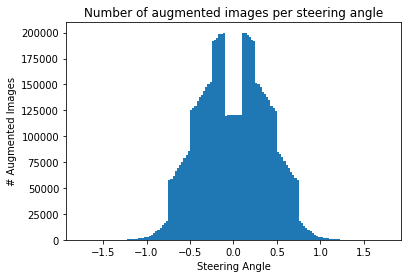

In [17]:
plt.hist(generated_steering_angles, bins=np.arange(min(generated_steering_angles), max(generated_steering_angles) + binwidth, binwidth))
plt.title('Number of augmented images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Augmented Images')
plt.show()